<img width="1337" src=images/Header1.jpg> (<a href="https://www.freepik.com/free-vector/car-accident-crossroad-city-street-vector-cartoon-illustration-auto-crash-cityscape-with-buildings-road-broken-vehicles-after-collision-glass-shards_17995555.htm#query=car%20crash&position=13&from_view=keyword&track=ais">Image by upklyak</a> on Freepik)

# Forecasting NYC Car Collisions: Steering Towards a Safer Future

Time Series Analysis of the Leading Collision Causes of the Top 5 High-Risk Zip Codes within Queens & Brooklyn

**Author:** [Annie Zheng](http://linkedin.com/in/anniezhengaz)

## Overview

This project analyzes car collision data aimed to analyze the leading causes of collisions and the top 5 high-risk zip codes within Queens and Brooklyn boroughs in order to identify accident types and driver behaviors. Analysis and modeling shows that certain causes and zip codes lead to greater risk of injury. This analysis can be used for developing target collision interventions and campaigns.

<img width="1337" src=images/Header2_QueensRoad.jpeg> (<a href="https://www.makeroadssafe.org/queens-road-safety-overview/">Image from Make Roads Safe)

## Business Problem
Car crashes have been happening every day all around the world ever since the invention of the very first car. These accidents pose a thread to everyone, but particularly to dense areas with large populations, such as Queens and Brooklyn boroughs within New York City whose population amounts to over 4 million people total. The New York City Department of Transportation may be able to mitigate preventable collisions and reallocate resources to cut down the amount of collisions that occur. In doing so, the current and future residents of Queens and Brooklyn could live in safer neighborhoods. Using NYC OpenData's data, leading causes of car collisions were identified as well as which neighborhoods are considered high-risk as a result of the number of injuries due to collisions.

## The Bottom Line
Before we proceed forth with the data, what's the bottom line up front?
Well, the top 5 zip codes that pose the greatest risk to drivers are 11236 (Brooklyn), 11207 (Brooklyn), 11234 (Brooklyn), 11368 (Queens), and 11385 (Queens). These 5 zip codes are considered high-risk due to their high injury to collision ratio based on 5-years worth of data.

The models exhibited an error of 3 crashes per day due to a moving violations and an error of 4 crashes per day due to driver inattention within these zip codes.

<img src=images/Map_Top5HighRiskZones.png>

## Data Understanding
This project utilizes data from [NYC OpenData](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) website with data received from the New York Police Department (NYPD). With nearly two million rows of collisions spanning from 2012 to 2023 within all five boroughs, the dataset provide additional information including location, number of injuries and casualities, contributing factors and vehicle types. Additional [Zip Code Boundaries](https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u) data was also provided by NYC OpenData for additional mapping efforts.

This analysis focused on the two NYC boroughs with the largest populations - Queens and Brooklyn with only collisions that occured within the last five years, 2018 to 2023. The target variable in the analysis was `CONTRIBUTING FACTOR VEHICLE 1` which laid a foundation for the rest of the analysis and modeling. The goal of this analysis to identify the leading factors in collisions and recommend the actions that could mitigate or prevent future collisions. Columns such as `ZIP CODE` and `NUMBER OF PERSONS INJURED` were vital in the identification of high-risk zip codes. The dataset contained a mixture of numerical and categorical data, however, it is important to understand that Time Series models require numerical data. 

In [1]:
#Import necessary functions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#For Maps
import folium
from folium.plugins import HeatMap
import geopandas as gpd

#For Time Series 
from datetime import datetime as dt
from fbprophet import Prophet
from itertools import product
from matplotlib.lines import Line2D
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook


#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import the dataset and merge Crash Date and Crash Time columns into one time column
df = pd.read_csv('data/Motor_Vehicle_Collisions_-_Crashes.csv', low_memory=False, parse_dates=[['CRASH DATE', 
                                                                                                'CRASH TIME']])

#Import the shapefile for choropleth map
zipcodes = gpd.read_file('data/ZIP_CODE_040114/ZIP_CODE_040114.shp')

#Initial look into dataset
df.head()

CRASH DATE_CRASH TIME   BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0   2021-09-11 02:39:00       NaN      NaN        NaN        NaN   
1   2022-03-26 11:45:00       NaN      NaN        NaN        NaN   
2   2022-06-29 06:55:00       NaN      NaN        NaN        NaN   
3   2021-09-11 09:35:00  BROOKLYN    11208  40.667202 -73.866500   
4   2021-12-14 08:13:00  BROOKLYN    11233  40.683304 -73.917274   

                  LOCATION           ON STREET NAME CROSS STREET NAME  \
0                      NaN    WHITESTONE EXPRESSWAY         20 AVENUE   
1                      NaN  QUEENSBORO BRIDGE UPPER               NaN   
2                      NaN       THROGS NECK BRIDGE               NaN   
3    (40.667202, -73.8665)                      NaN               NaN   
4  (40.683304, -73.917274)          SARATOGA AVENUE    DECATUR STREET   

           OFF STREET NAME  NUMBER OF PERSONS INJURED  ...  \
0                      NaN                        2.0  ...   
1                      NaN                        1.0  ...   
2                      NaN                        0.0  ...   
3  1211      LORING AVENUE                        0.0  ...   
4                      NaN                        0.0  ...   

   CONTRIBUTING FACTOR VEHICLE 2  CONTRIBUTING FACTOR VEHICLE 3  \
0                    Unspecified                            NaN   
1                            NaN                            NaN   
2                    Unspecified                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   

   CONTRIBUTING FACTOR VEHICLE 4  CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                            NaN                            NaN       4455765   
1                            NaN                            NaN       4513547   
2                            NaN                            NaN       4541903   
3                            NaN                            NaN       4456314   
4                            NaN                            NaN       4486609   

   VEHICLE TYPE CODE 1  VEHICLE TYPE CODE 2 VEHICLE TYPE CODE 3  \
0                Sedan                Sedan                 NaN   
1                Sedan                  NaN                 NaN   
2                Sedan        Pick-up Truck                 NaN   
3                Sedan                  NaN                 NaN   
4                  NaN                  NaN                 NaN   

  VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5  
0                 NaN                 NaN  
1                 NaN                 NaN  
2                 NaN                 NaN  
3                 NaN                 NaN  
4                 NaN                 NaN  

[5 rows x 28 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979921 entries, 0 to 1979920
Data columns (total 28 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   CRASH DATE_CRASH TIME          datetime64[ns]
 1   BOROUGH                        object        
 2   ZIP CODE                       object        
 3   LATITUDE                       float64       
 4   LONGITUDE                      float64       
 5   LOCATION                       object        
 6   ON STREET NAME                 object        
 7   CROSS STREET NAME              object        
 8   OFF STREET NAME                object        
 9   NUMBER OF PERSONS INJURED      float64       
 10  NUMBER OF PERSONS KILLED       float64       
 11  NUMBER OF PEDESTRIANS INJURED  int64         
 12  NUMBER OF PEDESTRIANS KILLED   int64         
 13  NUMBER OF CYCLIST INJURED      int64         
 14  NUMBER OF CYCLIST KILLED       int64         
 15  NUMBER OF MOTOR

In [4]:
#Check what the dates range from
df['CRASH DATE_CRASH TIME'].describe()

count                 1979921
unique                1067748
top       2015-01-18 08:00:00
freq                       51
first     2012-07-01 00:05:00
last      2023-03-27 23:46:00
Name: CRASH DATE_CRASH TIME, dtype: object

## Data Cleaning & Preparation
To prepare the data for modeling, the following data cleaning steps were performed:
* Changing to DateTime index
* Filtering to collisions that occured between 2018-2023
* Borough selection - Queens & Brooklyn
* Removal of missing and outlier values
* Removal of columns with repetitive and non-relevant data to analysis
* Imputation of missing values

In addition to data cleaning, numerous features were engingeered, including:
* Main Collision Cause Categories (10 categories)
* Season
* Time of Day
* Rush Hour
* Injury/Collision Ratio

### Changing DateTime Index

In [5]:
#Rename crash date column
df.rename(columns = {'CRASH DATE_CRASH TIME':'CRASH DATE TIME'}, inplace = True)

#Set to datetime index
df.set_index('CRASH DATE TIME', inplace=True)

The collisions within the last full 5 years will be considered in the model only.

In [6]:
#Filter to crashes between 2018-2023; crashes beyond 2023 will be separated later
df = df['2018-01-01':]

In [7]:
#Sanity check of the modeling data time frame
print (df.index.min())
print (df.index.max())

2018-01-01 00:00:00
2023-03-27 23:46:00


In [8]:
#Sort the datetime indexes in ascending order
df = df.sort_index()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 791077 entries, 2018-01-01 00:00:00 to 2023-03-27 23:46:00
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   BOROUGH                        514688 non-null  object 
 1   ZIP CODE                       514567 non-null  object 
 2   LATITUDE                       730480 non-null  float64
 3   LONGITUDE                      730480 non-null  float64
 4   LOCATION                       730480 non-null  object 
 5   ON STREET NAME                 591371 non-null  object 
 6   CROSS STREET NAME              382154 non-null  object 
 7   OFF STREET NAME                198962 non-null  object 
 8   NUMBER OF PERSONS INJURED      791071 non-null  float64
 9   NUMBER OF PERSONS KILLED       791063 non-null  float64
 10  NUMBER OF PEDESTRIANS INJURED  791077 non-null  int64  
 11  NUMBER OF PEDESTRIANS KILLED   791077 non-null  int64  
 

### Borough Selection

The two of the five NYC boroughs with the largest populations will be analyzed: Queens and Brooklyn.

In [10]:
#Filter for collisions in Brooklyn and Queens borough
df = df.loc[(df['BOROUGH'] == 'BROOKLYN') | (df['BOROUGH'] == 'QUEENS')]

In [11]:
#Sanity check to ensure only two boroughs are included
print(df['BOROUGH'].unique())

['QUEENS' 'BROOKLYN']


### Dropping Columns/Values

In [12]:
#Check for NaN values in street name columns
print(df['ON STREET NAME'].isnull().sum())
print(df['CROSS STREET NAME'].isnull().sum())
print(df['OFF STREET NAME'].isnull().sum())

115219
115422
199029


In [13]:
print(df['LOCATION'].isnull().sum())

7033


There are 6 columns dedicated to where the collision took place. The `LOCATION` column is to be dropped as it contains repetitive information from the `LATITUDE` and `LONGITUDE` columns. The columns regarding street name will be dropped as well due to the significant amount of missing values. 

There are a total of 8 columns dedicated to the number of people injured and killed as a result of the collision. The columns with the total number of injured and killed, whereas the columns specifying the type of person will be removed. 

In [14]:
#Drop non-relevant and repetitive location columns
df.drop(['LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME'], axis=1, inplace=True)

#Drop repetitive injury/death columns
df.drop(['NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 
         'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'], 
        axis=1, inplace=True)

The focus will be on the Vehicle 1 as it is to be considered the primary vehicle of the collision. The columns for the contributing factor and vehicle type code for vehicles 2-5 have a significant amount of missing values and therefore will be removed from the dataset.

In [15]:
#Drop additional contributing factor vehicle columns
df.drop(['CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 
         'CONTRIBUTING FACTOR VEHICLE 5'], axis=1, inplace=True)

#Drop additional vehicle type columns
df.drop(['VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'], 
        axis=1, inplace=True)


In [16]:
#Drop NaN values from columns of contributing factors
df = df.dropna(subset=['CONTRIBUTING FACTOR VEHICLE 1'])

In [17]:
#Filter out the collisions with Unspecified contributing factor
df = df[df['CONTRIBUTING FACTOR VEHICLE 1'] != 'Unspecified']
df

BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
CRASH DATE TIME                                                
2018-01-01 00:00:00    QUEENS    11419  40.682970 -73.828240   
2018-01-01 00:00:00  BROOKLYN    11239  40.653060 -73.882020   
2018-01-01 00:00:00  BROOKLYN    11230  40.624180 -73.970480   
2018-01-01 00:00:00  BROOKLYN    11234  40.628770 -73.918250   
2018-01-01 00:00:00  BROOKLYN    11230  40.623220 -73.961020   
...                       ...      ...        ...        ...   
2023-03-27 21:50:00    QUEENS    11385  40.709038 -73.898460   
2023-03-27 22:10:00  BROOKLYN    11218  40.640410 -73.969124   
2023-03-27 23:07:00  BROOKLYN    11218  40.640316 -73.979070   
2023-03-27 23:15:00  BROOKLYN    11207  40.674644 -73.886180   
2023-03-27 23:46:00  BROOKLYN    11211  40.713800 -73.933190   

                     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
CRASH DATE TIME                                                            
2018-01-01 00:00:00                        0.0                       0.0   
2018-01-01 00:00:00                        0.0                       0.0   
2018-01-01 00:00:00                        0.0                       0.0   
2018-01-01 00:00:00                        1.0                       0.0   
2018-01-01 00:00:00                        0.0                       0.0   
...                                        ...                       ...   
2023-03-27 21:50:00                        1.0                       0.0   
2023-03-27 22:10:00                        1.0                       0.0   
2023-03-27 23:07:00                        0.0                       0.0   
2023-03-27 23:15:00                        1.0                       0.0   
2023-03-27 23:46:00                        4.0                       0.0   

                      CONTRIBUTING FACTOR VEHICLE 1  COLLISION_ID  \
CRASH DATE TIME                                                     
2018-01-01 00:00:00             Passing Too Closely       3819067   
2018-01-01 00:00:00  Driver Inattention/Distraction       3820851   
2018-01-01 00:00:00  Driver Inattention/Distraction       3822296   
2018-01-01 00:00:00   Failure to Yield Right-of-Way       3820945   
2018-01-01 00:00:00  Driver Inattention/Distraction       3821055   
...                                             ...           ...   
2023-03-27 21:50:00   Failure to Yield Right-of-Way       4616419   
2023-03-27 22:10:00  Driver Inattention/Distraction       4616379   
2023-03-27 23:07:00                Backing Unsafely       4616380   
2023-03-27 23:15:00                    Unsafe Speed       4616303   
2023-03-27 23:46:00  Driver Inattention/Distraction       4616089   

                                     VEHICLE TYPE CODE 1  
CRASH DATE TIME                                           
2018-01-01 00:00:00                                Sedan  
2018-01-01 00:00:00                                Sedan  
2018-01-01 00:00:00  Station Wagon/Sport Utility Vehicle  
2018-01-01 00:00:00                                Sedan  
2018-01-01 00:00:00                                 Taxi  
...                                                  ...  
2023-03-27 21:50:00                                Moped  
2023-03-27 22:10:00                                Sedan  
2023-03-27 23:07:00                            Box Truck  
2023-03-27 23:15:00                                  NaN  
2023-03-27 23:46:00                                Sedan  

[227936 rows x 9 columns]

#### Number of Persons Injured & Number of Persons Killed

In [18]:
#Check for NaN values in injury/death columns
print(df['NUMBER OF PERSONS KILLED'].isnull().sum())
print(df['NUMBER OF PERSONS INJURED'].isnull().sum())

1
0


Since there were only 2 collisions with missing values from the `NUMBER OF PERSONS KILLED` column and only 3 from the `NUMBER OF PERSONS INJURED`, these rows will be dropped.  

In [19]:
#Drop NaN values from injury/death columns
df = df.dropna(subset=['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED'])

#Sanity check to verify no more NaN values
print(df['NUMBER OF PERSONS KILLED'].isnull().sum())
print(df['NUMBER OF PERSONS INJURED'].isnull().sum())

0
0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 227935 entries, 2018-01-01 00:00:00 to 2023-03-27 23:46:00
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   BOROUGH                        227935 non-null  object 
 1   ZIP CODE                       227859 non-null  object 
 2   LATITUDE                       222873 non-null  float64
 3   LONGITUDE                      222873 non-null  float64
 4   NUMBER OF PERSONS INJURED      227935 non-null  float64
 5   NUMBER OF PERSONS KILLED       227935 non-null  float64
 6   CONTRIBUTING FACTOR VEHICLE 1  227935 non-null  object 
 7   COLLISION_ID                   227935 non-null  int64  
 8   VEHICLE TYPE CODE 1            226352 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 17.4+ MB


#### Latitude and Longitude
The Latitude and Longitude columns will be kept to ensure the location of the collisions can be mapped using Folium. First, we must verify if there are any missing values.

In [21]:
#Check for NaN values in Latitude and Longitude columns
print(df['LATITUDE'].isnull().sum())
print(df['LONGITUDE'].isnull().sum())

5062
5062


Since there are a little over 5,000 rows missing values for Latitude and Longitude, these rows will be dropped.

In [22]:
#Drop missing values from Latitude and Longitude columns
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

In [23]:
#Check the minimum/maximum values of Latitude
df['LATITUDE'].describe()

count    222873.000000
mean         40.466272
std           2.996388
min           0.000000
25%          40.656980
50%          40.688150
75%          40.723885
max          40.896500
Name: LATITUDE, dtype: float64

In [24]:
#Check the minimum/maximum values of Longitude
df['LONGITUDE'].describe()

count    222873.000000
mean        -73.490381
std           5.441501
min         -74.194600
25%         -73.951200
50%         -73.907370
75%         -73.833460
max           0.000000
Name: LONGITUDE, dtype: float64

In [25]:
#Check how many collisions have a Latitude of 0
df[df['LATITUDE'] == 0]

BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
CRASH DATE TIME                                               
2018-02-14 14:23:00  BROOKLYN    11219       0.0        0.0   
2018-02-23 11:00:00    QUEENS    11374       0.0        0.0   
2018-02-28 12:00:00  BROOKLYN    11217       0.0        0.0   
2018-02-28 12:30:00    QUEENS    11385       0.0        0.0   
2018-02-28 12:44:00  BROOKLYN    11201       0.0        0.0   
...                       ...      ...       ...        ...   
2023-03-02 12:00:00  BROOKLYN    11203       0.0        0.0   
2023-03-09 16:02:00  BROOKLYN    11211       0.0        0.0   
2023-03-17 15:40:00  BROOKLYN    11236       0.0        0.0   
2023-03-20 17:20:00  BROOKLYN    11234       0.0        0.0   
2023-03-22 16:35:00  BROOKLYN    11215       0.0        0.0   

                     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
CRASH DATE TIME                                                            
2018-02-14 14:23:00                        0.0                       0.0   
2018-02-23 11:00:00                        0.0                       0.0   
2018-02-28 12:00:00                        0.0                       0.0   
2018-02-28 12:30:00                        0.0                       0.0   
2018-02-28 12:44:00                        0.0                       0.0   
...                                        ...                       ...   
2023-03-02 12:00:00                        0.0                       0.0   
2023-03-09 16:02:00                        0.0                       0.0   
2023-03-17 15:40:00                        1.0                       0.0   
2023-03-20 17:20:00                        1.0                       0.0   
2023-03-22 16:35:00                        0.0                       0.0   

                      CONTRIBUTING FACTOR VEHICLE 1  COLLISION_ID  \
CRASH DATE TIME                                                     
2018-02-14 14:23:00   Failure to Yield Right-of-Way       4025794   
2018-02-23 11:00:00   Failure to Yield Right-of-Way       3851213   
2018-02-28 12:00:00             Alcohol Involvement       3853952   
2018-02-28 12:30:00               Oversized Vehicle       3855414   
2018-02-28 12:44:00               Oversized Vehicle       3853954   
...                                             ...           ...   
2023-03-02 12:00:00  Driver Inattention/Distraction       4611376   
2023-03-09 16:02:00             Passing Too Closely       4612778   
2023-03-17 15:40:00  Driver Inattention/Distraction       4615443   
2023-03-20 17:20:00   Failure to Yield Right-of-Way       4614372   
2023-03-22 16:35:00  Driver Inattention/Distraction       4614869   

                                     VEHICLE TYPE CODE 1  
CRASH DATE TIME                                           
2018-02-14 14:23:00  Station Wagon/Sport Utility Vehicle  
2018-02-23 11:00:00  Station Wagon/Sport Utility Vehicle  
2018-02-28 12:00:00                                  Van  
2018-02-28 12:30:00                                TRAIL  
2018-02-28 12:44:00                            Box Truck  
...                                                  ...  
2023-03-02 12:00:00  Station Wagon/Sport Utility Vehicle  
2023-03-09 16:02:00                                Sedan  
2023-03-17 15:40:00                               E-Bike  
2023-03-20 17:20:00                                 Bike  
2023-03-22 16:35:00                                Sedan  

[1215 rows x 9 columns]

In [26]:
#Check how many collisions have a Longitude of 0
df[df['LONGITUDE'] == 0]

BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
CRASH DATE TIME                                               
2018-02-14 14:23:00  BROOKLYN    11219       0.0        0.0   
2018-02-23 11:00:00    QUEENS    11374       0.0        0.0   
2018-02-28 12:00:00  BROOKLYN    11217       0.0        0.0   
2018-02-28 12:30:00    QUEENS    11385       0.0        0.0   
2018-02-28 12:44:00  BROOKLYN    11201       0.0        0.0   
...                       ...      ...       ...        ...   
2023-03-02 12:00:00  BROOKLYN    11203       0.0        0.0   
2023-03-09 16:02:00  BROOKLYN    11211       0.0        0.0   
2023-03-17 15:40:00  BROOKLYN    11236       0.0        0.0   
2023-03-20 17:20:00  BROOKLYN    11234       0.0        0.0   
2023-03-22 16:35:00  BROOKLYN    11215       0.0        0.0   

                     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
CRASH DATE TIME                                                            
2018-02-14 14:23:00                        0.0                       0.0   
2018-02-23 11:00:00                        0.0                       0.0   
2018-02-28 12:00:00                        0.0                       0.0   
2018-02-28 12:30:00                        0.0                       0.0   
2018-02-28 12:44:00                        0.0                       0.0   
...                                        ...                       ...   
2023-03-02 12:00:00                        0.0                       0.0   
2023-03-09 16:02:00                        0.0                       0.0   
2023-03-17 15:40:00                        1.0                       0.0   
2023-03-20 17:20:00                        1.0                       0.0   
2023-03-22 16:35:00                        0.0                       0.0   

                      CONTRIBUTING FACTOR VEHICLE 1  COLLISION_ID  \
CRASH DATE TIME                                                     
2018-02-14 14:23:00   Failure to Yield Right-of-Way       4025794   
2018-02-23 11:00:00   Failure to Yield Right-of-Way       3851213   
2018-02-28 12:00:00             Alcohol Involvement       3853952   
2018-02-28 12:30:00               Oversized Vehicle       3855414   
2018-02-28 12:44:00               Oversized Vehicle       3853954   
...                                             ...           ...   
2023-03-02 12:00:00  Driver Inattention/Distraction       4611376   
2023-03-09 16:02:00             Passing Too Closely       4612778   
2023-03-17 15:40:00  Driver Inattention/Distraction       4615443   
2023-03-20 17:20:00   Failure to Yield Right-of-Way       4614372   
2023-03-22 16:35:00  Driver Inattention/Distraction       4614869   

                                     VEHICLE TYPE CODE 1  
CRASH DATE TIME                                           
2018-02-14 14:23:00  Station Wagon/Sport Utility Vehicle  
2018-02-23 11:00:00  Station Wagon/Sport Utility Vehicle  
2018-02-28 12:00:00                                  Van  
2018-02-28 12:30:00                                TRAIL  
2018-02-28 12:44:00                            Box Truck  
...                                                  ...  
2023-03-02 12:00:00  Station Wagon/Sport Utility Vehicle  
2023-03-09 16:02:00                                Sedan  
2023-03-17 15:40:00                               E-Bike  
2023-03-20 17:20:00                                 Bike  
2023-03-22 16:35:00                                Sedan  

[1215 rows x 9 columns]

It appears there are over a thousand of rows with both a Latitude and Longitude of 0. The collisions with Latitude and Longitude of 0 have some bad data - we know because a 0 Latitude is at the equator. To ensure our data is well-rounded with complete and accurate values, let's drop the collisions with a Longitude and Latitude of 0.

In [27]:
#Filter for collisions that do NOT have Longitude and Latitude of 0
df = df[df['LONGITUDE'] != 0]

df.head()

BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
CRASH DATE TIME                                           
2018-01-01         QUEENS    11419  40.68297  -73.82824   
2018-01-01       BROOKLYN    11239  40.65306  -73.88202   
2018-01-01       BROOKLYN    11230  40.62418  -73.97048   
2018-01-01       BROOKLYN    11234  40.62877  -73.91825   
2018-01-01       BROOKLYN    11230  40.62322  -73.96102   

                 NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
CRASH DATE TIME                                                        
2018-01-01                             0.0                       0.0   
2018-01-01                             0.0                       0.0   
2018-01-01                             0.0                       0.0   
2018-01-01                             1.0                       0.0   
2018-01-01                             0.0                       0.0   

                  CONTRIBUTING FACTOR VEHICLE 1  COLLISION_ID  \
CRASH DATE TIME                                                 
2018-01-01                  Passing Too Closely       3819067   
2018-01-01       Driver Inattention/Distraction       3820851   
2018-01-01       Driver Inattention/Distraction       3822296   
2018-01-01        Failure to Yield Right-of-Way       3820945   
2018-01-01       Driver Inattention/Distraction       3821055   

                                 VEHICLE TYPE CODE 1  
CRASH DATE TIME                                       
2018-01-01                                     Sedan  
2018-01-01                                     Sedan  
2018-01-01       Station Wagon/Sport Utility Vehicle  
2018-01-01                                     Sedan  
2018-01-01                                      Taxi

In [28]:
#Sanity check how many collisions have a Longitude of 0
df[df['LONGITUDE'] == 0]

Empty DataFrame
Columns: [BOROUGH, ZIP CODE, LATITUDE, LONGITUDE, NUMBER OF PERSONS INJURED, NUMBER OF PERSONS KILLED, CONTRIBUTING FACTOR VEHICLE 1, COLLISION_ID, VEHICLE TYPE CODE 1]
Index: []

In [29]:
#Sanity check how many collisions have a Latitude of 0
df[df['LATITUDE'] == 0]

Empty DataFrame
Columns: [BOROUGH, ZIP CODE, LATITUDE, LONGITUDE, NUMBER OF PERSONS INJURED, NUMBER OF PERSONS KILLED, CONTRIBUTING FACTOR VEHICLE 1, COLLISION_ID, VEHICLE TYPE CODE 1]
Index: []

### Imputation

In [30]:
#Check rows with missing zip code
df[df['ZIP CODE'].isna()]

BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
CRASH DATE TIME                                             
2018-01-17 20:49:00  QUEENS      NaN  40.72010  -73.79038   
2018-01-18 17:20:00  QUEENS      NaN  40.72010  -73.79038   
2018-02-01 09:00:00  QUEENS      NaN  40.72010  -73.79038   
2018-02-09 17:22:00  QUEENS      NaN  40.72010  -73.79038   
2018-03-19 21:00:00  QUEENS      NaN  40.76092  -73.82680   
...                     ...      ...       ...        ...   
2022-06-27 09:27:00  QUEENS      NaN  40.72013  -73.79038   
2022-08-09 12:30:00  QUEENS      NaN  40.75089  -73.93663   
2022-11-22 20:08:00  QUEENS      NaN  40.72013  -73.79038   
2023-02-27 18:10:00  QUEENS      NaN  40.72013  -73.79038   
2023-03-21 13:31:00  QUEENS      NaN  40.72013  -73.79038   

                     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
CRASH DATE TIME                                                            
2018-01-17 20:49:00                        0.0                       0.0   
2018-01-18 17:20:00                        0.0                       0.0   
2018-02-01 09:00:00                        0.0                       0.0   
2018-02-09 17:22:00                        0.0                       0.0   
2018-03-19 21:00:00                        0.0                       0.0   
...                                        ...                       ...   
2022-06-27 09:27:00                        1.0                       0.0   
2022-08-09 12:30:00                        0.0                       0.0   
2022-11-22 20:08:00                        4.0                       0.0   
2023-02-27 18:10:00                        0.0                       0.0   
2023-03-21 13:31:00                        1.0                       0.0   

                      CONTRIBUTING FACTOR VEHICLE 1  COLLISION_ID  \
CRASH DATE TIME                                                     
2018-01-17 20:49:00  Passing or Lane Usage Improper       3830150   
2018-01-18 17:20:00  Driver Inattention/Distraction       3831700   
2018-02-01 09:00:00           Following Too Closely       3839658   
2018-02-09 17:22:00           Following Too Closely       3843234   
2018-03-19 21:00:00           Following Too Closely       3865703   
...                                             ...           ...   
2022-06-27 09:27:00            Unsafe Lane Changing       4541523   
2022-08-09 12:30:00  Driver Inattention/Distraction       4554698   
2022-11-22 20:08:00  Driver Inattention/Distraction       4584239   
2023-02-27 18:10:00  Driver Inattention/Distraction       4608887   
2023-03-21 13:31:00     Traffic Control Disregarded       4614557   

                                     VEHICLE TYPE CODE 1  
CRASH DATE TIME                                           
2018-01-17 20:49:00                                Sedan  
2018-01-18 17:20:00                                Sedan  
2018-02-01 09:00:00                                Sedan  
2018-02-09 17:22:00                                  Bus  
2018-03-19 21:00:00                                Sedan  
...                                                  ...  
2022-06-27 09:27:00  Station Wagon/Sport Utility Vehicle  
2022-08-09 12:30:00  Station Wagon/Sport Utility Vehicle  
2022-11-22 20:08:00  Station Wagon/Sport Utility Vehicle  
2023-02-27 18:10:00  Station Wagon/Sport Utility Vehicle  
2023-03-21 13:31:00  Station Wagon/Sport Utility Vehicle  

[73 rows x 9 columns]

There are 73 missing values from the `ZIP CODE` column, however, we see that numerous rows have the same latitude and longitude. Let's impute those rows instead of dropping them.

In [31]:
#Create a dictionary that corresponds the Latitude, Longitude with the correct Zip Code
zipcode_dict = {(40.72010, -73.79038): 11432,
                (40.76092, -73.82680): 11354,
                (40.72013, -73.79038): 11433,
                (40.75089, -73.93663): 11101,
                (40.724792, -73.722916): 11426,
                (40.713050, -73.916990): 11385,
                (40.711930, -73.919365): 11385,
                (40.724792, -73.722916): 11426,
                (40.707447, -73.903870): 11385,
                (40.707485, -73.918365): 11385,
                (40.733120, -73.727900): 11426,
                (40.719124, -73.791405): 11432, 
                (40.606260, -73.744170): 11691,
                (40.707317, -73.903595): 11385,
                (40.695072, -73.990100): 11201,}

# use the map function to update the 'zipcode' column based on the dictionary
df['ZIP CODE'] = df.apply(lambda row: zipcode_dict.get((row['LATITUDE'], row['LONGITUDE']), row['ZIP CODE']), 
                          axis=1)

In [32]:
#Sanity check to confirm there's no more NaN values in Zip Code column
df[df['ZIP CODE'].isna()]

Empty DataFrame
Columns: [BOROUGH, ZIP CODE, LATITUDE, LONGITUDE, NUMBER OF PERSONS INJURED, NUMBER OF PERSONS KILLED, CONTRIBUTING FACTOR VEHICLE 1, COLLISION_ID, VEHICLE TYPE CODE 1]
Index: []

In [33]:
#Sanity check to confirm zipcode was imputed for indexed row
df[df.index.isin(['2018-01-17 20:49:00'])]

BOROUGH ZIP CODE  LATITUDE  LONGITUDE  \
CRASH DATE TIME                                             
2018-01-17 20:49:00  QUEENS    11432   40.7201  -73.79038   

                     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
CRASH DATE TIME                                                            
2018-01-17 20:49:00                        0.0                       0.0   

                      CONTRIBUTING FACTOR VEHICLE 1  COLLISION_ID  \
CRASH DATE TIME                                                     
2018-01-17 20:49:00  Passing or Lane Usage Improper       3830150   

                    VEHICLE TYPE CODE 1  
CRASH DATE TIME                          
2018-01-17 20:49:00               Sedan

### Feature Engineering

#### Contributing Categories
To get a better idea of what the main causes of collisions are, let's feature engineer a new `CONTRIBUTING CATEGORY V1` feature placing the causes into 10 main umbrella categories, especially since there are a large number of causes.

In [34]:
#Review the contributing factors
df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts(sort=True).head()

Driver Inattention/Distraction    76614
Failure to Yield Right-of-Way     26472
Following Too Closely             16305
Backing Unsafely                  15547
Passing Too Closely               13110
Name: CONTRIBUTING FACTOR VEHICLE 1, dtype: int64

In [35]:
#Check the unique values of contributing factors for vehicle 1
df['CONTRIBUTING FACTOR VEHICLE 1'].unique()

array(['Passing Too Closely', 'Driver Inattention/Distraction',
       'Failure to Yield Right-of-Way', 'Unsafe Speed',
       'Traffic Control Device Improper/Non-Working',
       'Traffic Control Disregarded', 'Pavement Slippery',
       'Following Too Closely', 'Backing Unsafely',
       'Passenger Distraction', 'Passing or Lane Usage Improper',
       'Other Vehicular', 'Alcohol Involvement', 'Driver Inexperience',
       'Fell Asleep', 'Brakes Defective', 'View Obstructed/Limited',
       'Unsafe Lane Changing', 'Obstruction/Debris', 'Turning Improperly',
       'Pavement Defective', 'Reaction to Uninvolved Vehicle',
       'Aggressive Driving/Road Rage', 'Tire Failure/Inadequate',
       'Steering Failure',
       'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
       'Animals Action', 'Glare', 'Oversized Vehicle',
       'Outside Car Distraction', 'Failure to Keep Right',
       'Other Electronic Device', 'Lost Consciousness',
       'Driverless/Runaway Vehicle', 'Other

In [36]:
#Create duplicate columns of contributing factor columns for categorizing
df['CONTRIBUTING CATEGORY V1'] = df['CONTRIBUTING FACTOR VEHICLE 1']

#Replace value with correct spelling of 'Illness'
df['CONTRIBUTING FACTOR VEHICLE 1'].replace('Illnes', 'Illness', inplace=True)

In [37]:
#Replace specific contributing factor to a more generalized category in Contributing Category Vehicle 1
df['CONTRIBUTING CATEGORY V1'].replace(('Driver Inattention/Distraction', 'Driver Inexperience', 
                                        'Reaction to Uninvolved Vehicle', 'Aggressive Driving/Road Rage', 
                                        'Eating or Drinking'), ('Driver Inattention'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Tire Failure/Inadequate', 'Headlights Defective', 'Steering Failure', 
                                        'Brakes Defective', 'Accelerator Defective', 'Tow Hitch Defective', 
                                        'Other Lighting Defects', 'Tinted Windows', 'Vehicle Vandalism', 
                                        'Windshield Inadequate'), ('Vehicle Defects'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Failure to Yield Right-of-Way','Passing or Lane Usage Improper', 
                                        'Unsafe Lane Changing','Failure to Keep Right', 
                                        'Traffic Control Disregarded','Passing Too Closely', 
                                        'Backing Unsafely', 'Unsafe Speed', 'Following Too Closely', 
                                        'Turning Improperly'), ('Moving Violation'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Glare', 'Obstruction/Debris', 'View Obstructed/Limited'), 
                                       ('Environmental Factors'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Cell Phone (hand-Held)', 'Texting', 'Using On Board Navigation Device', 
                                        'Other Electronic Device', 'Listening/Using Headphones', 
                                        'Cell Phone (hands-free)'), ('Internal Electronics Usage'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Illnes', 'Illness', 'Drugs (illegal)', 'Fell Asleep', 'Fatigued/Drowsy', 
                                        'Lost Consciousness', 'Physical Disability', 'Alcohol Involvement', 
                                        'Prescription Medication'), ('Bodily Impairment'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Traffic Control Device Improper/Non-Working', 'Pavement Slippery', 
                                        'Pavement Defective', 'Shoulders Defective/Improper', 
                                        'Lane Marking Improper/Inadequate'), ('Road Conditions'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Driverless/Runaway Vehicle', 'Other Vehicular', 'Oversized Vehicle'), 
                                       ('Third-Party (Vehicular)'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Animals Action', 
                                        'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion'), 
                                       ('Third-Party (Non-Vehicular)'), inplace=True)

df['CONTRIBUTING CATEGORY V1'].replace(('Passenger Distraction', 'Outside Car Distraction'), 
                                       ('Other Distractions'), inplace=True)

In [38]:
#Sanity check to confirm only 10 categories
df['CONTRIBUTING CATEGORY V1'].value_counts()

Moving Violation               108257
Driver Inattention              86398
Third-Party (Vehicular)          8406
Bodily Impairment                6618
Environmental Factors            3565
Road Conditions                  2507
Vehicle Defects                  2399
Third-Party (Non-Vehicular)      2056
Other Distractions               1281
Internal Electronics Usage        171
Name: CONTRIBUTING CATEGORY V1, dtype: int64

In [39]:
#Convert columns from float to integers
df = df.astype({'ZIP CODE':'int64', 'NUMBER OF PERSONS INJURED':'int64', 'NUMBER OF PERSONS KILLED':'int64'})

In [40]:
#Drop remaining NaN values
df = df.dropna()

#### Season
The `SEASON` feature was created to analyze if collisions occured in one season more than the others.

In [41]:
#Create Season column
## Months 3-5 = Spring
## Months 6-8 = Summer
## Months 9-11 = Autumn
## Months 12-2 = Winter

df['SEASON'] = np.where(((df.index.month >= 3) & (df.index.month <= 5)), 'Spring',
                          np.where(((df.index.month >= 6) & (df.index.month <= 8)), 'Summer',
                                  np.where(((df.index.month >= 9) & (df.index.month <= 11)), 'Autumn', 'Winter')))

df['SEASON'].value_counts()

Winter    56663
Summer    55723
Autumn    54181
Spring    53546
Name: SEASON, dtype: int64

Unsurprisingly, the most amount of collisions occurred in the winter. Icy roads and visibilty issues due to the snow could be a huge reason why.  Summer comes in as number 2, also not surprising since more people go out and travel when the weathers nice.

#### Time of Day
The `TIME OF DAY` feature was created to analyze if a particular time of day posed greater risk to drivers.

In [42]:
#Create time of day column
#Late Night: 12AM-4AM (0-4)
#Early Morning: 4AM-8AM (4-8)
#Morning: 8AM-12PM (8-12)
#Afternoon: 2pm-4pm (12-16)
#Evening:4pm-8pm (16-20)
#Night:8pm-midnight (20-24)

#Define the bins
bins=[0, 4, 8, 12, 16, 20, 24]

#Custom labels for time of day/hour intervals
labels=['Late Night', 'Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night']


#Add the bins to the dataframe
df['TIME OF DAY'] = pd.cut(df.index.hour, bins, labels=labels, right=False)

df['TIME OF DAY'].value_counts()

Evening          55809
Afternoon        54231
Morning          44293
Night            30302
Early Morning    17801
Late Night       17677
Name: TIME OF DAY, dtype: int64

Evening travel tops the charts, as expected, as that is when most people clock out of work and have free time to go out and enjoy themselves, especially before it gets too dark. Afternoon time is a surprising second place, as I expect more collisions to occur at night when visibly is low. However, the 2-4PM is typically when people go out for their lunch breaks and also when students are released from school. 

#### Is Rush Hour
`IS RUSH HOUR` feature was engineered to analyze if there's spike in collisions during the durations where there are the most amount of drivers are on the road trying to commute to work.

In [43]:
#Create and join dataframes indicating rush hour traffic
rush_hour = pd.concat([df.between_time('6:00', '9:00'), df.between_time('16:00', '19:00')])

#Create new column indicating if rush hour -- return True if index is in rush_hour, False if not
df['IS RUSH HOUR'] = df.index.isin(rush_hour.index)

#Sanity check to confirm there are True/False values
df['IS RUSH HOUR'].value_counts()

False    147475
True      72638
Name: IS RUSH HOUR, dtype: int64

A surprisingly false outcome has won the race. Although one may think that the number of collisions during rush hour would be higher, we must take into account the residents and transportation. A majority of the residents within the five boroughs of New York City take public transportation such as buses and subways. In addition, with high volumes of traffic, it would be harder to cause a collision with the snail-like movements in stand still traffic.

In [44]:
#Create copy of dataframe for visualizations
df_visuals = df.copy()

### Date Selection for Modeling

#### Top 10 At-Risk Zip Code Identification

In [45]:
#View number of zip codes
df['ZIP CODE'].nunique()

104

104 zip codes in just two boroughs is a lot, to hone in on the data some more, let's identify the top 10 zip codes in which the most amount of collisions occured.

In [46]:
#Count which zip code had the most amount of collisions
df['ZIP CODE'].value_counts().head(10)

11207    6961
11234    5189
11101    5143
11385    4846
11236    4804
11211    4771
11206    4717
11368    4536
11208    4383
11201    4332
Name: ZIP CODE, dtype: int64

In [47]:
#Define the top 10 high-risk zip codes
top10zips = [11207, 11234, 11101, 11385, 11236, 11211, 11206, 11368, 11201, 11373 ]

#Filter for collisions that occured within the top 10 zip codes
df = df.loc[df['ZIP CODE'].isin(top10zips)]

#Filter for top two causes
df = df.loc[df['CONTRIBUTING CATEGORY V1'].isin(['Moving Violation', 'Driver Inattention'])]

df

BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
CRASH DATE TIME                                                 
2018-01-01 00:00:00  BROOKLYN     11234  40.628770 -73.918250   
2018-01-01 00:05:00  BROOKLYN     11211  40.718460 -73.952810   
2018-01-01 00:15:00  BROOKLYN     11236  40.645176 -73.906220   
2018-01-01 00:30:00  BROOKLYN     11211  40.716805 -73.954600   
2018-01-01 01:10:00    QUEENS     11385  40.695526 -73.903950   
...                       ...       ...        ...        ...   
2023-03-27 14:05:00  BROOKLYN     11211  40.717210 -73.934710   
2023-03-27 17:15:00  BROOKLYN     11206  40.697266 -73.952330   
2023-03-27 20:13:00  BROOKLYN     11234  40.608200 -73.920715   
2023-03-27 21:50:00    QUEENS     11385  40.709038 -73.898460   
2023-03-27 23:46:00  BROOKLYN     11211  40.713800 -73.933190   

                     NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
CRASH DATE TIME                                                            
2018-01-01 00:00:00                          1                         0   
2018-01-01 00:05:00                          0                         0   
2018-01-01 00:15:00                          0                         0   
2018-01-01 00:30:00                          0                         0   
2018-01-01 01:10:00                          0                         0   
...                                        ...                       ...   
2023-03-27 14:05:00                          2                         0   
2023-03-27 17:15:00                          1                         0   
2023-03-27 20:13:00                          1                         0   
2023-03-27 21:50:00                          1                         0   
2023-03-27 23:46:00                          4                         0   

                      CONTRIBUTING FACTOR VEHICLE 1  COLLISION_ID  \
CRASH DATE TIME                                                     
2018-01-01 00:00:00   Failure to Yield Right-of-Way       3820945   
2018-01-01 00:05:00   Failure to Yield Right-of-Way       3818641   
2018-01-01 00:15:00                    Unsafe Speed       3824618   
2018-01-01 00:30:00  Driver Inattention/Distraction       3818640   
2018-01-01 01:10:00     Traffic Control Disregarded       3819354   
...                                             ...           ...   
2023-03-27 14:05:00     Traffic Control Disregarded       4616059   
2023-03-27 17:15:00  Driver Inattention/Distraction       4616293   
2023-03-27 20:13:00                    Unsafe Speed       4616087   
2023-03-27 21:50:00   Failure to Yield Right-of-Way       4616419   
2023-03-27 23:46:00  Driver Inattention/Distraction       4616089   

                                     VEHICLE TYPE CODE 1  \
CRASH DATE TIME                                            
2018-01-01 00:00:00                                Sedan   
2018-01-01 00:05:00                                Sedan   
2018-01-01 00:15:00  Station Wagon/Sport Utility Vehicle   
2018-01-01 00:30:00                                 Taxi   
2018-01-01 01:10:00                                Sedan   
...                                                  ...   
2023-03-27 14:05:00  Station Wagon/Sport Utility Vehicle   
2023-03-27 17:15:00                                Sedan   
2023-03-27 20:13:00                                Sedan   
2023-03-27 21:50:00                                Moped   
2023-03-27 23:46:00                                Sedan   

                    CONTRIBUTING CATEGORY V1  SEASON TIME OF DAY  IS RUSH HOUR  
CRASH DATE TIME                                                                 
2018-01-01 00:00:00         Moving Violation  Winter  Late Night         False  
2018-01-01 00:05:00         Moving Violation  Winter  Late Night         False  
2018-01-01 00:15:00         Moving Violation  Winter  Late Night         False  
2018-01-01 00:30:00       Driver Inattention  Winter  Late Night         False  
2018-01-01 01:10:00   

#### Additional Feature Engineering
The `INJURY/COLLISIONS TOTAL RATIO` and `INJURY/COLISION TOTAL PERCENTAGE` features were engineered to get a better understanding of the ranking of the zip codes that seem to be the most dangerous. This is to be calculated using the number of persons injured in the collision.

In [48]:
##Total number of collisions by zip code
#Group  by Zip Code, and sum the number of accidents for Zip Code
total_accidents_by_zipcode = df.groupby('ZIP CODE')['COLLISION_ID'].count()

#Create dataframe for easier viewing
total_accidents_by_zipcode = pd.DataFrame(total_accidents_by_zipcode)

#Rename column
total_accidents_by_zipcode.rename(columns = {'COLLISION_ID':'NUMBER OF COLLISIONS'}, inplace = True)

##Total number of injuries by zip code 
# Group by Zip Code, and sum the number of persons injured
injured = df.groupby(['ZIP CODE'])[['NUMBER OF PERSONS INJURED']].sum()

##Merge the two dataframes
injury_collision = total_accidents_by_zipcode.merge(injured, on='ZIP CODE')

#Create new column with injury to total number of collisions ratio
injury_collision['INJURY/COLLISION TOTAL RATIO'] = (injury_collision['NUMBER OF PERSONS INJURED'] / 
                                                    injury_collision['NUMBER OF COLLISIONS'])

#Create new column converting ratio to percentage
injury_collision['INJURY/COLLISION TOTAL PERCENTAGE'] = (round(injury_collision['INJURY/COLLISION TOTAL RATIO'] 
                                                               * 100))

#Sort by descending percentage
injury_collision.sort_values(by='INJURY/COLLISION TOTAL PERCENTAGE', ascending=False)

NUMBER OF COLLISIONS  NUMBER OF PERSONS INJURED  \
ZIP CODE                                                    
11236                     4197                       2151   
11207                     5974                       2686   
11234                     4579                       2014   
11368                     3998                       1427   
11385                     4244                       1461   
11206                     3968                       1320   
11101                     4754                       1474   
11211                     4094                       1220   
11373                     3785                       1082   
11201                     3802                       1001   

          INJURY/COLLISION TOTAL RATIO  INJURY/COLLISION TOTAL PERCENTAGE  
ZIP CODE                                                                   
11236                         0.512509                               51.0  
11207                         0.449615                               45.0  
11234                         0.439834                               44.0  
11368                         0.356928                               36.0  
11385                         0.344251                               34.0  
11206                         0.332661                               33.0  
11101                         0.310055                               31.0  
11211                         0.297997                               30.0  
11373                         0.285865                               29.0  
11201                         0.263282                               26.0

### Export Datasets as CSV
The following datasets will be exported as the master for modeling 2018-2023 collisions and the 2023 data will be exported as a dataset to future forecast comparisons.

In [49]:
#Create dataframe with only 2023 data - to be considered future
df_2023 = df['2023':]
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1287 entries, 2023-01-01 00:00:00 to 2023-03-27 23:46:00
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   BOROUGH                        1287 non-null   object  
 1   ZIP CODE                       1287 non-null   int64   
 2   LATITUDE                       1287 non-null   float64 
 3   LONGITUDE                      1287 non-null   float64 
 4   NUMBER OF PERSONS INJURED      1287 non-null   int64   
 5   NUMBER OF PERSONS KILLED       1287 non-null   int64   
 6   CONTRIBUTING FACTOR VEHICLE 1  1287 non-null   object  
 7   COLLISION_ID                   1287 non-null   int64   
 8   VEHICLE TYPE CODE 1            1287 non-null   object  
 9   CONTRIBUTING CATEGORY V1       1287 non-null   object  
 10  SEASON                         1287 non-null   object  
 11  TIME OF DAY                    1287 non-null   category
 12

In [50]:
#Export as a .csv as final cleaned 2023dataset
df_2023.to_csv('data/Final_Motor_Vehicle_Collisions_QuBr_2023-Future.csv')

In [51]:
#Filter to crashes between 2018-2023
df = df['2018-01-01':'2022-12-31']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42108 entries, 2018-01-01 00:00:00 to 2022-12-31 21:05:00
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   BOROUGH                        42108 non-null  object  
 1   ZIP CODE                       42108 non-null  int64   
 2   LATITUDE                       42108 non-null  float64 
 3   LONGITUDE                      42108 non-null  float64 
 4   NUMBER OF PERSONS INJURED      42108 non-null  int64   
 5   NUMBER OF PERSONS KILLED       42108 non-null  int64   
 6   CONTRIBUTING FACTOR VEHICLE 1  42108 non-null  object  
 7   COLLISION_ID                   42108 non-null  int64   
 8   VEHICLE TYPE CODE 1            42108 non-null  object  
 9   CONTRIBUTING CATEGORY V1       42108 non-null  object  
 10  SEASON                         42108 non-null  object  
 11  TIME OF DAY                    42108 non-null  category
 1

Export smaller dataset that can be pushed to GitHub.

In [52]:
#Export as a .csv as final cleaned dataset
df.to_csv('data/Final_Motor_Vehicle_Collisions_QuBr_2018_2023-Model.csv')

## Modeling Preparation
Time series models require numerical data and since the cause of a collision is categorical data, we must find a way to convert the data from categorical to numerical. Instead of performing the standard One Hot Encoder and resampling techniques, the groupby technique was utilized to resample the data from the time of occurence to daily and groupby each of those days by cause category to attain the number of collisions that occurred each day due to a specific cause. A pivot table was utilized to attain a more readable format. Lastly, for time series modeling, a datetime index is absolutely vital and was the last step in preparation for modeling. 

In [53]:
#Create copy of dataframes for Time Series Modeling
ts = df.copy().reset_index()
ts_2023 = df_2023.copy().reset_index()
ts.head()

CRASH DATE TIME   BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0 2018-01-01 00:00:00  BROOKLYN     11234  40.628770  -73.91825   
1 2018-01-01 00:05:00  BROOKLYN     11211  40.718460  -73.95281   
2 2018-01-01 00:15:00  BROOKLYN     11236  40.645176  -73.90622   
3 2018-01-01 00:30:00  BROOKLYN     11211  40.716805  -73.95460   
4 2018-01-01 01:10:00    QUEENS     11385  40.695526  -73.90395   

   NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
0                          1                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   

    CONTRIBUTING FACTOR VEHICLE 1  COLLISION_ID  \
0   Failure to Yield Right-of-Way       3820945   
1   Failure to Yield Right-of-Way       3818641   
2                    Unsafe Speed       3824618   
3  Driver Inattention/Distraction       3818640   
4     Traffic Control Disregarded       3819354   

                   VEHICLE TYPE CODE 1 CONTRIBUTING CATEGORY V1  SEASON  \
0                                Sedan         Moving Violation  Winter   
1                                Sedan         Moving Violation  Winter   
2  Station Wagon/Sport Utility Vehicle         Moving Violation  Winter   
3                                 Taxi       Driver Inattention  Winter   
4                                Sedan         Moving Violation  Winter   

  TIME OF DAY  IS RUSH HOUR  
0  Late Night         False  
1  Late Night         False  
2  Late Night         False  
3  Late Night         False  
4  Late Night         False

In [54]:
#Group the values by day and count the number of instances of each value
daily_count = ts.groupby([ts['CRASH DATE TIME'].dt.date, 
                          'CONTRIBUTING CATEGORY V1']).size().reset_index(name='count')

daily2023_count = ts_2023.groupby([ts_2023['CRASH DATE TIME'].dt.date, 
                                   'CONTRIBUTING CATEGORY V1']).size().reset_index(name='count')

daily_count

CRASH DATE TIME CONTRIBUTING CATEGORY V1  count
0         2018-01-01       Driver Inattention      9
1         2018-01-01         Moving Violation     17
2         2018-01-02       Driver Inattention     11
3         2018-01-02         Moving Violation     13
4         2018-01-03       Driver Inattention     12
...              ...                      ...    ...
3640      2022-12-29         Moving Violation      9
3641      2022-12-30       Driver Inattention     10
3642      2022-12-30         Moving Violation      6
3643      2022-12-31       Driver Inattention      8
3644      2022-12-31         Moving Violation      5

[3645 rows x 3 columns]

In [55]:
#Create pivot table of daily cause categories
ts_pivt = daily_count.pivot(index='CRASH DATE TIME', columns='CONTRIBUTING CATEGORY V1', values='count').fillna(0)

ts2023_pivt = daily2023_count.pivot(index='CRASH DATE TIME', columns='CONTRIBUTING CATEGORY V1', 
                                    values='count').fillna(0)

ts_pivt.head(10)

CONTRIBUTING CATEGORY V1  Driver Inattention  Moving Violation
CRASH DATE TIME                                               
2018-01-01                               9.0              17.0
2018-01-02                              11.0              13.0
2018-01-03                              12.0              19.0
2018-01-04                               6.0               6.0
2018-01-05                              10.0              26.0
2018-01-06                              12.0              22.0
2018-01-07                              11.0              18.0
2018-01-08                              11.0              26.0
2018-01-09                              14.0              29.0
2018-01-10                              13.0              23.0

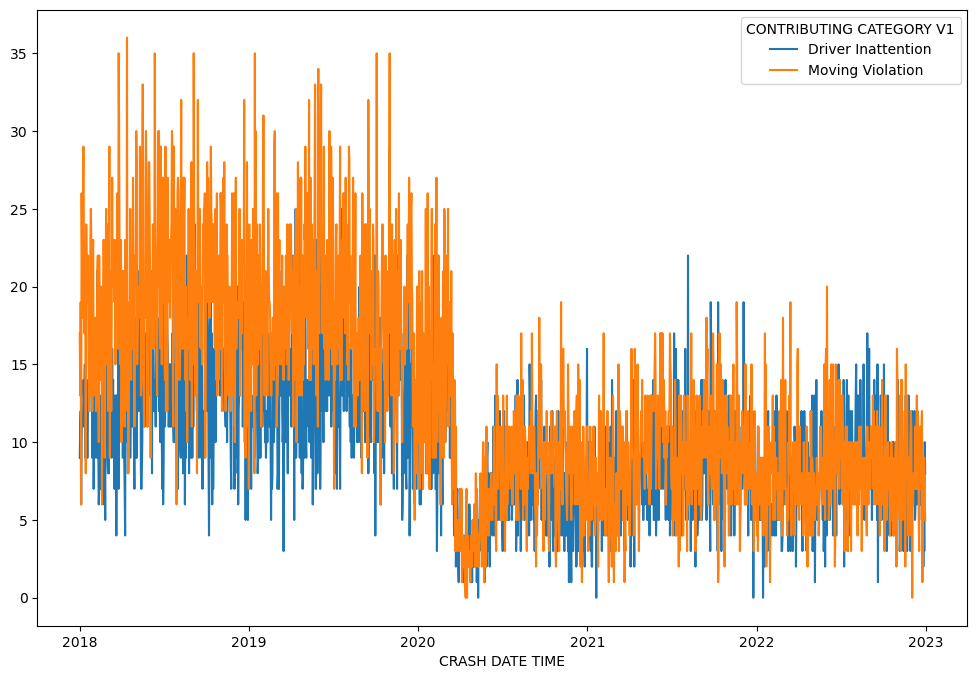

In [56]:
#Plot modeling data
ts_pivt.plot(figsize=(12,8));

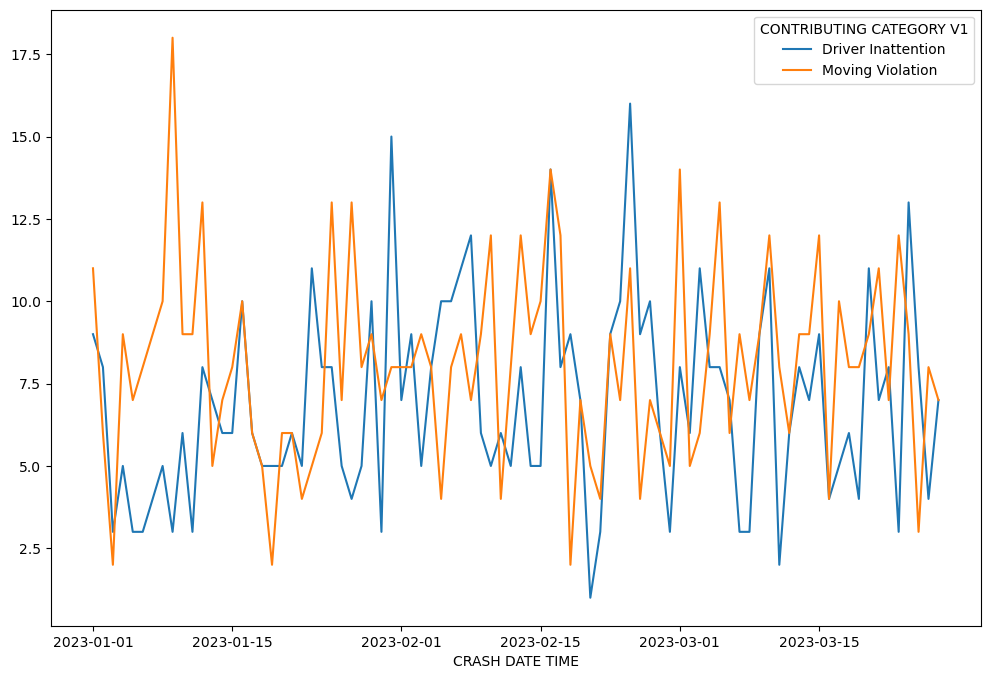

In [57]:
#Plot modeling data
ts2023_pivt.plot(figsize=(12,8));

In [58]:
#Converting back into index as datetime index
ts_pivt.index = pd.to_datetime(ts_pivt.index)
ts2023_pivt.index = pd.to_datetime(ts2023_pivt.index)

ts_pivt.head()

CONTRIBUTING CATEGORY V1  Driver Inattention  Moving Violation
CRASH DATE TIME                                               
2018-01-01                               9.0              17.0
2018-01-02                              11.0              13.0
2018-01-03                              12.0              19.0
2018-01-04                               6.0               6.0
2018-01-05                              10.0              26.0

In [59]:
#Create separate dataframes for the causes
ts_mv = ts_pivt[['Moving Violation']]
ts_di = ts_pivt[['Driver Inattention']]

ts2023_mv = ts2023_pivt[['Moving Violation']]
ts2023_di = ts2023_pivt[['Driver Inattention']]

ts_mv.head()

CONTRIBUTING CATEGORY V1  Moving Violation
CRASH DATE TIME                           
2018-01-01                            17.0
2018-01-02                            13.0
2018-01-03                            19.0
2018-01-04                             6.0
2018-01-05                            26.0

In [60]:
#Make list for leading causes
leading_causes = ['Moving Violation', 'Driver Inattention']

### Stationarity
Before we can begin modeling, we must check the stationarity of the dataset. A stationary dataset is required for time series models to perform well and accurately. The Dickey-Fuller statistical test will be utilized to verify stationarity. A non-stationary dataset could lead to poorer results and forecasting. 

The p-value associated with the Dickey-Fuller statistical test for Moving Violation is 0.47404355546228727,
 therefore we cannot reject the null hypothesis that the data is not stationary.


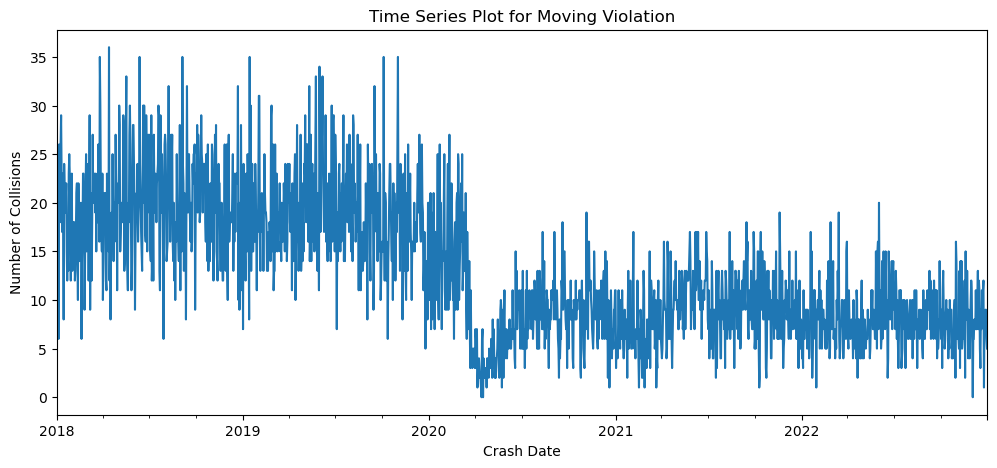

The p-value associated with the Dickey-Fuller statistical test for Driver Inattention is 0.15987072000573593,
 therefore we cannot reject the null hypothesis that the data is not stationary.


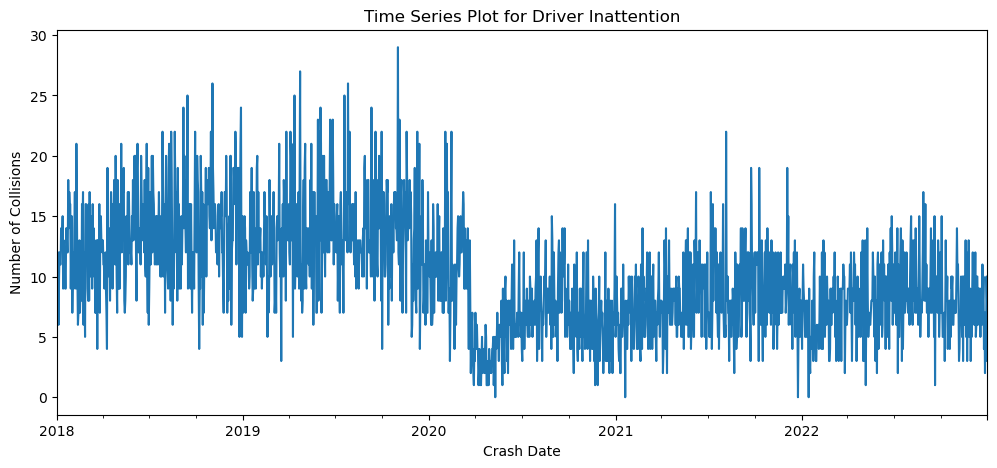

In [61]:
#Stationarity testing for loop
for cause in leading_causes:
    #Test for stationarity with the adfuller test
    ts_cause = ts_pivt[cause]
    p_val = adfuller(ts_cause)[1]
    print(f"The p-value associated with the Dickey-Fuller statistical test for {cause} is {p_val},")
    if p_val < 0.05:
        print(" therefore we can safely assume that the data is stationary.")
    else:
        print(" therefore we cannot reject the null hypothesis that the data is not stationary.")
        
    #Plot the dataset
    fig, ax = plt.subplots(figsize=(12, 5))
    ts_cause.plot(ax=ax)
    ax.set_title(f"Time Series Plot for {cause}")
    ax.set_xlabel("Crash Date")
    ax.set_ylabel("Number of Collisions")
    plt.show()

### Differencing
There are numerous methods to making a dataset stationary, however the method we will be using for this dataset is differencing. 

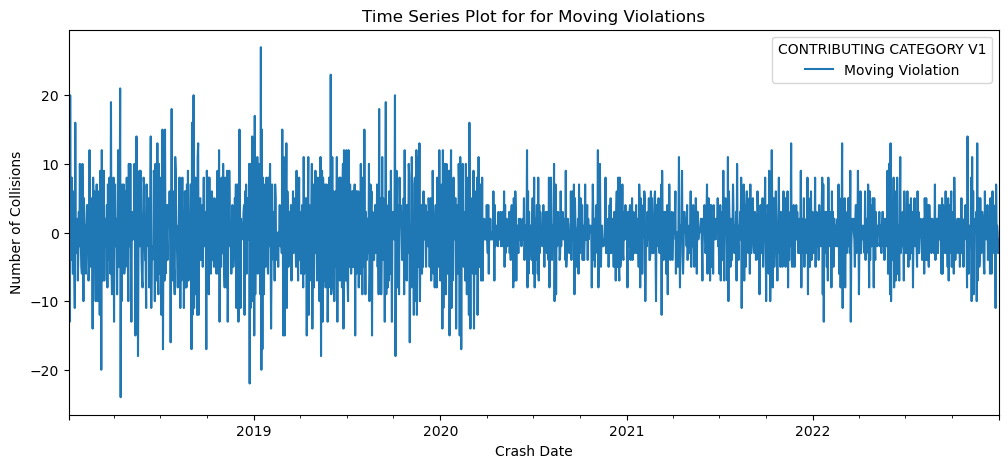

The p-value associated with the Dickey-Fuller statistical test for Moving Violations is 1.5349153910436561e-27,
 therefore we can safely assume that the differenced data is stationary.


In [62]:
#Difference the for Moving Violations data and drop the NaN values
diff_mv = ts_mv.diff().dropna()

#Plot the differenced dataset
fig, ax = plt.subplots(figsize=(12, 5))
diff_mv.plot(ax=ax)
ax.set_title(f"Time Series Plot for for Moving Violations")
ax.set_xlabel("Crash Date")
ax.set_ylabel("Number of Collisions")
plt.show()

#Sanity check to confirm stationarity
diff_pval_mv = adfuller(diff_mv)[1]

print(f"The p-value associated with the Dickey-Fuller statistical test for Moving Violations is {diff_pval_mv},")
if diff_pval_mv < 0.05:
    print(" therefore we can safely assume that the differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the differenced data is \
not stationary.");

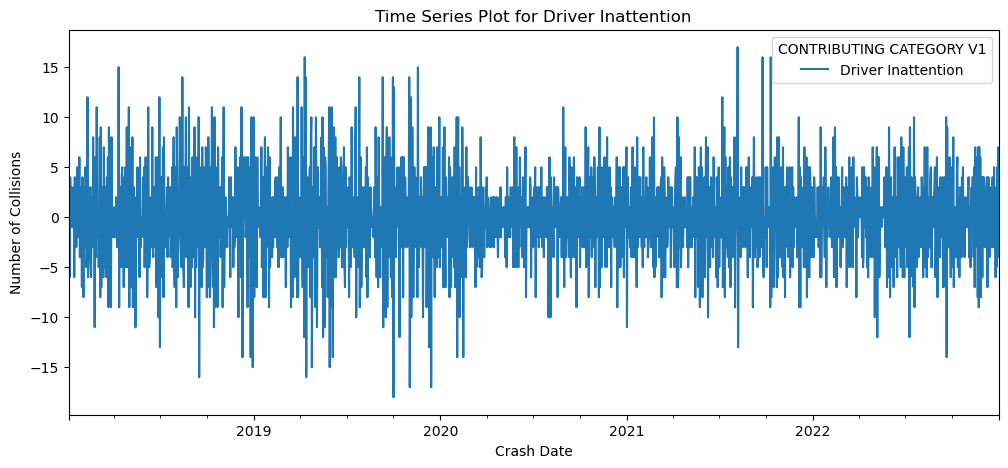

The p-value associated with the Dickey-Fuller statistical test for Driver Inattention is 6.202808846421239e-26,
 therefore we can safely assume that the differenced data is stationary.


In [63]:
#Difference the Driver Inattention data and drop the NaN values
diff_di = ts_di.diff().dropna()

#Plot the differenced dataset
fig, ax = plt.subplots(figsize=(12, 5))
diff_di.plot(ax=ax)
ax.set_title(f"Time Series Plot for Driver Inattention")
ax.set_xlabel("Crash Date")
ax.set_ylabel("Number of Collisions")
plt.show()

#Sanity check to confirm stationarity
diff_pval_di = adfuller(diff_di)[1]

print(f"The p-value associated with the Dickey-Fuller statistical test for Driver Inattention is {diff_pval_di},")
if diff_pval_di < 0.05:
    print(" therefore we can safely assume that the differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the differenced data is \
not stationary.");

### Train Test Split
To make predictions and forecasts, we must provide the model a dataset to train on. Here, we will be splitting the modeling dataset into train and test sets. It is important to remember that for time series models, the data must be continuous. Collisions ranging from 2018-2022, which is 80% of the data is to be defined as the train set, while the remaining 20% ranging from 2022-2023 will be defined as the test set.

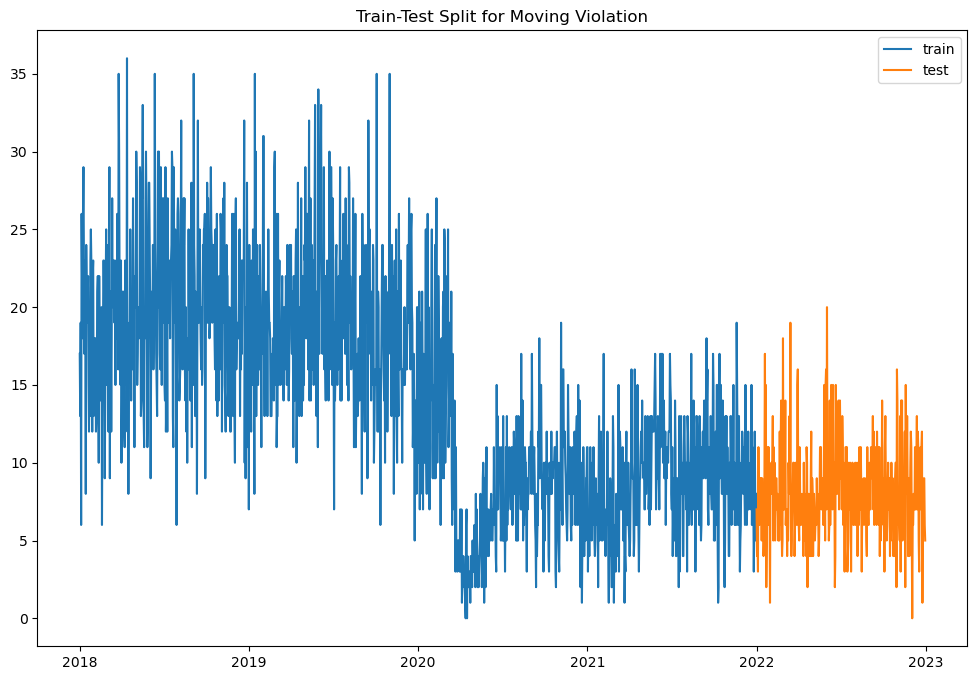

In [64]:
##Train test split for Moving Violations
#Find the index which allows us to split off 20% of the data
cutoff_mv = round(ts_mv.shape[0]*0.8) #cut off point at 80% of the data

# Define train and test sets according to the index found above
train_mv = ts_mv[:cutoff_mv] #before cut off is train set -- 80%

test_mv = ts_mv[cutoff_mv:] #after cut off is the test set --20%

#Plot the train test split
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_mv, label='train')
ax.plot(test_mv, label='test')
ax.set_title('Train-Test Split for Moving Violation');
plt.legend();

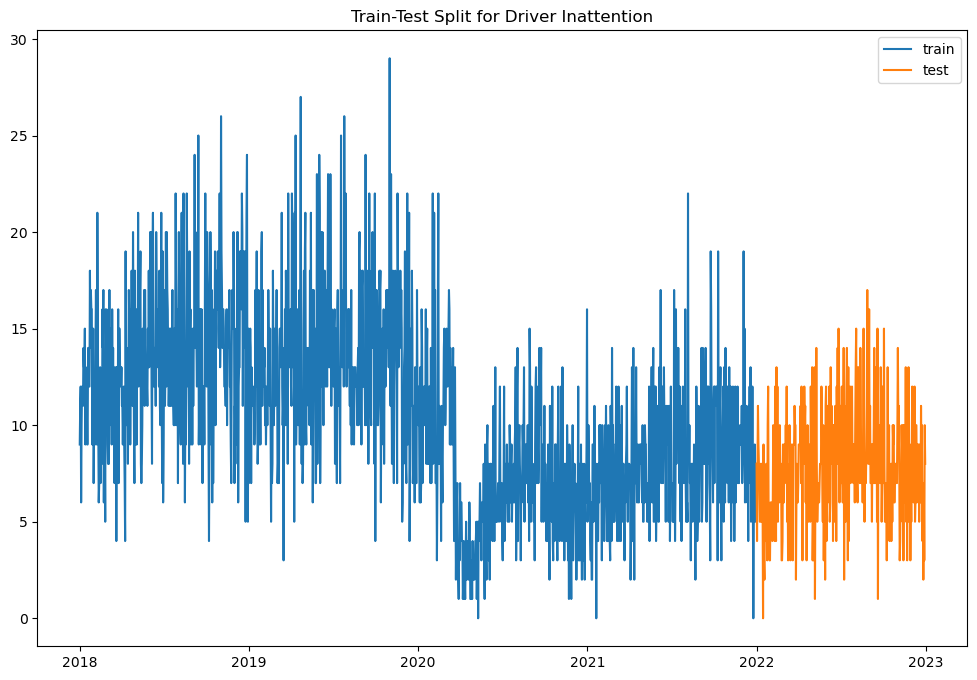

In [65]:
##Train test split for Driver Inattention

#Find the index which allows us to split off 20% of the data
cutoff_di = round(ts_di.shape[0]*0.8) #cut off point at 80% of the data

# Define train and test sets according to the index found above
train_di = ts_di[:cutoff_di] #before cut off is train set -- 80%

test_di = ts_di[cutoff_di:] #after cut off is the test set --20%

#Plot the train test split
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_di, label='train')
ax.plot(test_di, label='test')
ax.set_title('Train-Test Split for Driver Inattention');
plt.legend();

## Modeling
A total of 5 types of models, including the baseline were performed to forecast car collisions:
* Baseline Model - Naive Shift model
* First Model - ARIMA model 
* Second Model - SARIMA model
* Third Model - Prophet Model
* Fourth Model - Prophet Model with Holidays

The metric that will be used to determine the quality and effectiveness of the model will be Root Mean Squared Error (RMSE). 

Two separate datasets were modeled, one being daily Moving Violation collision count and the second being Driver Inattention collision count. As mentioned previously a datetime index is vital in time series modeling. The datetime index and the collision count collisions will be the basis of modeling.

### Baseline Model
The baseline model is a naive model, which is just one shift in time by one period in time and in this case, it would be by 1 day.

In [66]:
#Baseline model for Moving Violations
baseline_mv = train_mv.copy()
baseline_mv['One Shift'] = train_mv.shift(1)
baseline_mv.head()

CONTRIBUTING CATEGORY V1  Moving Violation  One Shift
CRASH DATE TIME                                      
2018-01-01                            17.0        NaN
2018-01-02                            13.0       17.0
2018-01-03                            19.0       13.0
2018-01-04                             6.0       19.0
2018-01-05                            26.0        6.0

In [67]:
#Baseline model for Driver Inattention
baseline_di = train_di.copy()
baseline_di['One Shift'] = train_di.shift(1)
baseline_di.head()

CONTRIBUTING CATEGORY V1  Driver Inattention  One Shift
CRASH DATE TIME                                        
2018-01-01                               9.0        NaN
2018-01-02                              11.0        9.0
2018-01-03                              12.0       11.0
2018-01-04                               6.0       12.0
2018-01-05                              10.0        6.0

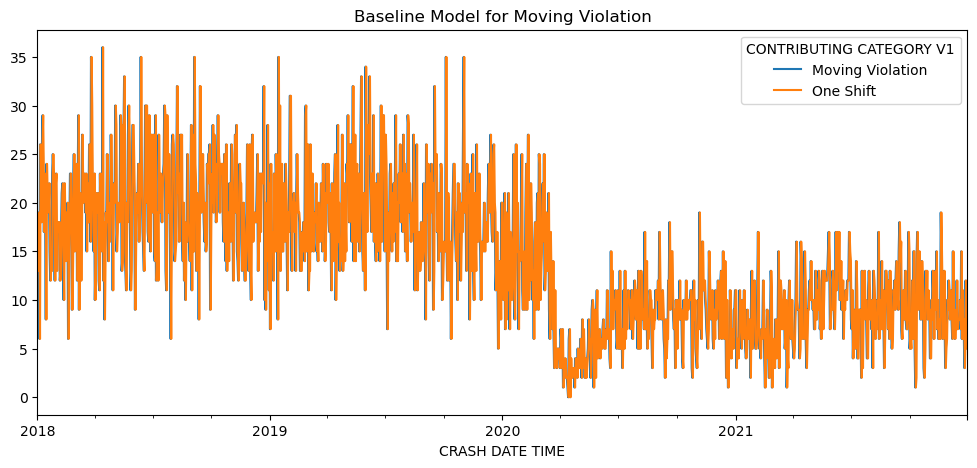

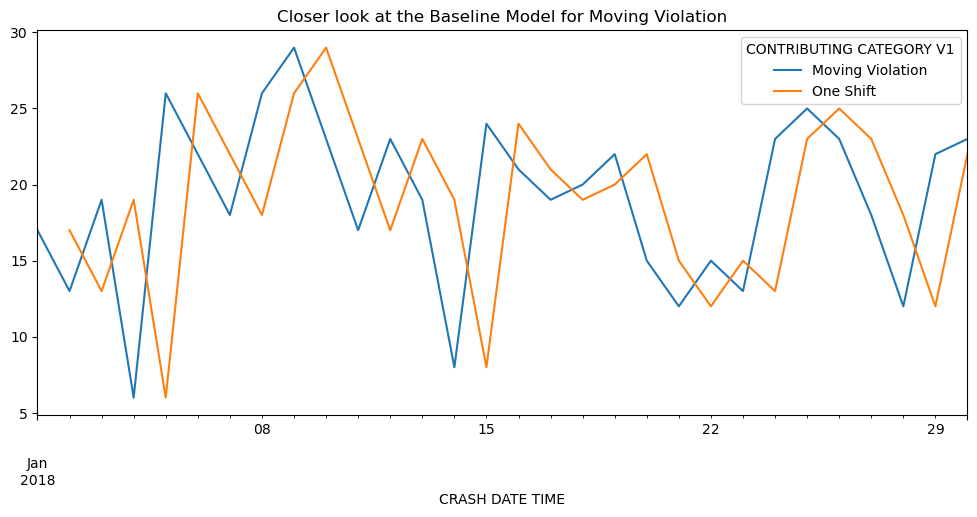

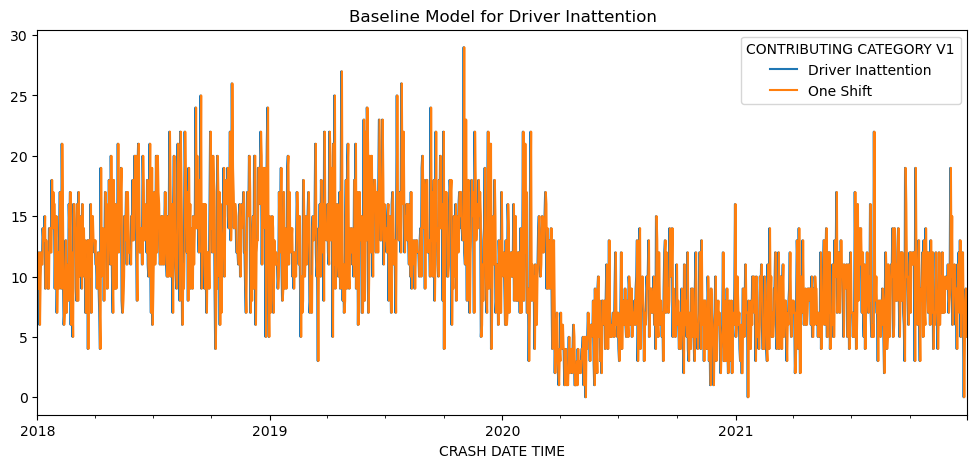

In [68]:
#Plot baseline model for Moving Violation
baseline_mv.plot(figsize=(12,5))
plt.title('Baseline Model for Moving Violation')

#A closer look
baseline_mv[0:30].plot(figsize=(12,5))
plt.title('Closer look at the Baseline Model for Moving Violation');

#Plot baseline model for Driver Inattention
baseline_di.plot(figsize=(12,5))
plt.title('Baseline Model for Driver Inattention');

In [69]:
#Calculate the Root Mean Square Error of the baseline model
baseline_mv_rmse = np.sqrt(mean_squared_error(baseline_mv['Moving Violation'][1:], 
                                              baseline_mv['One Shift'].dropna()))

print(f'Baseline Model RMSE for Moving Violation: {baseline_mv_rmse}')

#Calculate the Root Mean Square Error of the baseline model
baseline_di_rmse = np.sqrt(mean_squared_error(baseline_di['Driver Inattention'][1:], 
                                              baseline_di['One Shift'].dropna()))

print(f'Baseline Model RMSE for Driver Inattention: {baseline_di_rmse}')

Baseline Model RMSE for Moving Violation: 6.141315284583388
Baseline Model RMSE for Driver Inattention: 4.974455294748567


### First Simple Model - ARIMA
ARIMA stands for Autoregressive Integrated Moving Average. The "Autoregressive" (AR) part means that the model looks at previous values of the y value to make future predictions while the "Moving Average" (MA) means that it looks at the previous error. "Integrated" (I) means that the model will difference the dataset in order to make it stationary. AR is denoted by 'p', I is denoted by 'd' and MA denoted by 'q'. To help determine these pdq values/lags, we will be using the Partial Auto-Correlation (PACF) and Auto-Correlation (ACF) functions.

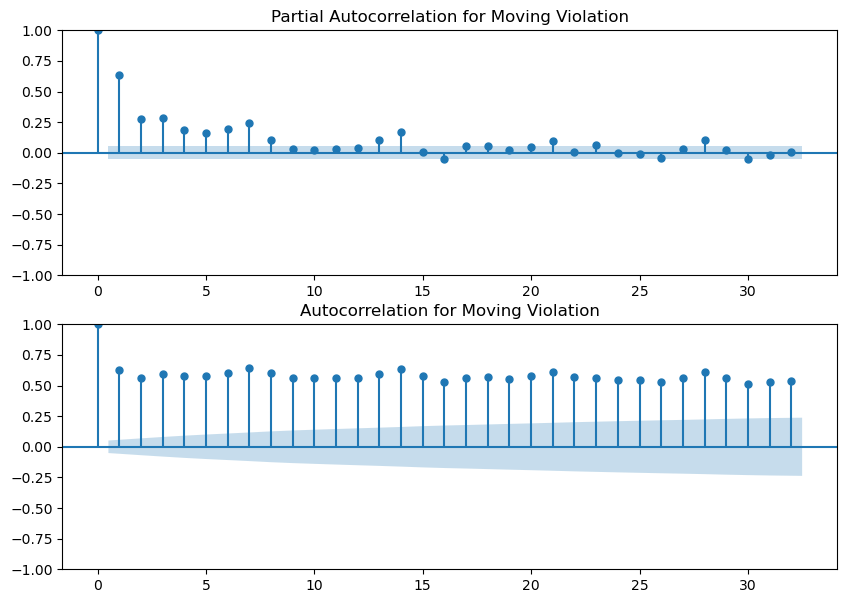

In [70]:
#Plot pacf and acf to identify p and q parameters for ARIMA modeling
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))

#Identify the p parameter 
plot_pacf(train_mv, ax=ax[0])
ax[0].set_title('Partial Autocorrelation for Moving Violation')

#Identify the q parameter 
plot_acf(train_mv, ax=ax[1])
ax[1].set_title('Autocorrelation for Moving Violation')

plt.show();

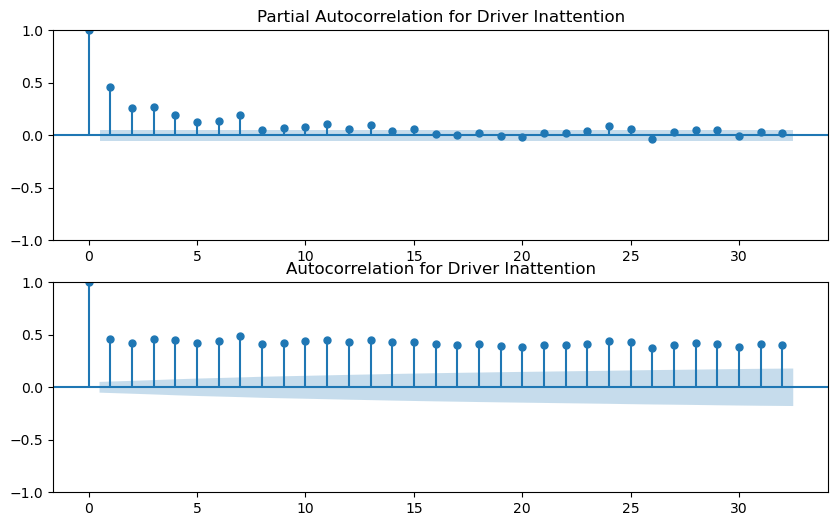

In [71]:
#Plot pacf and acf to identify p and q parameters for ARIMA modeling
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

#Identify the p parameter 
plot_pacf(train_di, ax=ax[0])
ax[0].set_title('Partial Autocorrelation for Driver Inattention')

#Identify the q parameter 
plot_acf(train_di, ax=ax[1])
ax[1].set_title('Autocorrelation for Driver Inattention')

plt.show();

In [72]:
#ARIMA model for Moving Violation
modelmv_1 = ARIMA(train_mv, order=(1, 1, 1)).fit()
modelmv_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Moving Violation   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4327.438
Date:                Wed, 19 Apr 2023   AIC                           8660.876
Time:                        19:23:58   BIC                           8676.735
Sample:                    01-01-2018   HQIC                          8666.792
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0919      0.026      3.553      0.000       0.041       0.143
ma.L1         -0.9352      0.011    -87.551      0.000      -0.956      -0.914
sigma2        21.9510      0.733     29.960      0.000      20.515      23.387
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                39.04
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
#ARIMA model for Driving Inattention
modeldi_1 = ARIMA(train_di, order=(1, 1, 1)).fit()
modeldi_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Driver Inattention   No. Observations:                 1461
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3980.895
Date:                Wed, 19 Apr 2023   AIC                           7967.790
Time:                        19:23:59   BIC                           7983.649
Sample:                    01-01-2018   HQIC                          7973.706
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0317      0.026      1.198      0.231      -0.020       0.084
ma.L1         -0.9321      0.011    -86.507      0.000      -0.953      -0.911
sigma2        13.6542      0.454     30.046      0.000      12.763      14.545
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                42.21
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [74]:
# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_mv_pred1 = modelmv_1.predict(typ='levels')
train_di_pred1 = modeldi_1.predict(typ='levels')

#Calculate the Root Mean Square Error
rmse_modelmv_1 = np.sqrt(mean_squared_error(train_mv, train_mv_pred1))
rmse_modeldi_1 = np.sqrt(mean_squared_error(train_di, train_di_pred1))

print(f'First Model RMSE for Moving Violation: {rmse_modelmv_1}')
print(f'First Model RMSE for Driver Inattention: {rmse_modeldi_1}')

First Model RMSE for Moving Violation: 4.710354422725186
First Model RMSE for Driver Inattention: 3.702425501684514


Moving Violation: The first model has performed better than the baseline, with the RMSE dropping nearly 2 collisions.

Driver Inattention: Yay! The first model for driver inattentation performed better than the baseline as well by dropping down 1 collision.

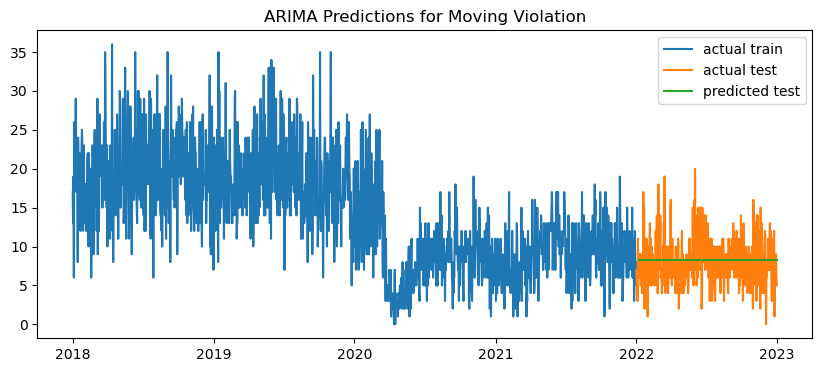

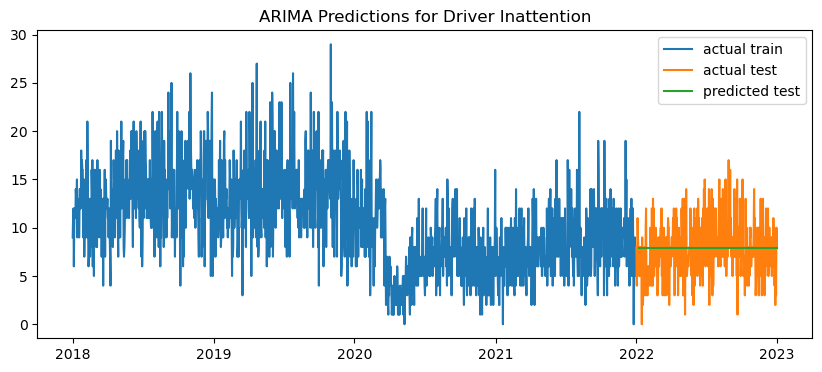

In [75]:
#Generate predictions for the test set
mv_pred = modelmv_1.predict(start='2022-01-09', end='2023-01-01')
di_pred = modeldi_1.predict(start='2022-01-09', end='2023-01-01')

# plot actual vs. predicted
fig = plt.figure(figsize=(10, 4))
plt.title('ARIMA Predictions for Moving Violation')
plt.plot(train_mv, label='actual train')
plt.plot(test_mv, label='actual test')
plt.plot(mv_pred, label='predicted test');
plt.legend()

# plot actual vs. predicted
fig = plt.figure(figsize=(10, 4))
plt.title('ARIMA Predictions for Driver Inattention')
plt.plot(train_di, label='actual train')
plt.plot(test_di, label='actual test')
plt.plot(di_pred, label='predicted test');
plt.legend();

The flat lining result confirms that there is seasonality within both datasets. With the seasonality, it is best to use a SARIMA or SARIMAX model. 

### Second Model - SARIMA 
Like ARIMA, the later part of SARIMA stands for "Autoregressive Integrated Moving Average", however the S in SARIMA stands for "Seasonality". Altogether, SARIMA stands for "Seasonal Autoregressive Integrated Moving Average". This model is an extension of the ARIMA model that takes into account any seasonal patterns that may occur within the dataset. Unlike ARIMA, the hyperparameters of a SARIMA model are denoted by "P", "D", "Q". 

To assist in finding the optimal pdq and PDQ values, we will be using a function, rather than manually searaching for the values. The optimal pdq and PDQ pairs will be determined by evaluating the AIC score - Akaike Information Criteria. For time series models, a lower AIC is better as it is a measure to evaluate the goodness of fit.  

The "optimize_SARIMA' function used in this project was written by Marco Peixeiro and is available to view on [Towards Data Science](https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b).

In [76]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], 
                                                                                 D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [77]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 7
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [78]:
params_mv = optimize_SARIMA(parameters_list, 1, 1, 7, ts_mv)
params_mv

  0%|          | 0/256 [00:00<?, ?it/s]

(p,q)x(P,Q)           AIC
0    (0, 2, 1, 2)  10413.232985
1    (1, 3, 1, 2)  10413.483767
2    (0, 3, 1, 2)  10413.639139
3    (1, 1, 1, 2)  10413.722007
4    (2, 1, 1, 2)  10413.799369
..            ...           ...
251  (0, 0, 2, 0)  11883.101687
252  (2, 0, 0, 0)  11954.279933
253  (0, 0, 1, 0)  12066.869999
254  (1, 0, 0, 0)  12210.258096
255  (0, 0, 0, 0)  12634.206134

[256 rows x 2 columns]

In [79]:
params_di = optimize_SARIMA(parameters_list, 1, 1, 7, ts_di)
params_di

  0%|          | 0/256 [00:00<?, ?it/s]

(p,q)x(P,Q)           AIC
0    (0, 1, 3, 2)   9761.330297
1    (0, 2, 3, 2)   9762.598647
2    (0, 1, 3, 1)   9763.039219
3    (0, 1, 0, 2)   9763.411481
4    (1, 1, 3, 2)   9763.426884
..            ...           ...
250  (2, 0, 0, 0)  11256.556734
251  (0, 0, 2, 0)  11358.000681
252  (1, 0, 0, 0)  11475.254813
253  (0, 0, 1, 0)  11564.112719
254  (0, 0, 0, 0)  11934.595254

[255 rows x 2 columns]

In [80]:
#SARIMA model for Moving Violation
modelmv_2 = SARIMAX(train_mv, order=(0, 1, 2), seasonal_order=(1, 1, 2, 7)).fit(dis=-1)
modelmv_2.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.02681D+00    |proj g|=  7.48224D-02


 This problem is unconstrained.



At iterate    5    f=  2.90178D+00    |proj g|=  6.76095D-03

At iterate   10    f=  2.90091D+00    |proj g|=  3.04617D-04

At iterate   15    f=  2.90091D+00    |proj g|=  2.70710D-04

At iterate   20    f=  2.90083D+00    |proj g|=  2.17876D-03

At iterate   25    f=  2.90061D+00    |proj g|=  1.40154D-03

At iterate   30    f=  2.90000D+00    |proj g|=  1.28081D-03

At iterate   35    f=  2.89966D+00    |proj g|=  5.15090D-03

At iterate   40    f=  2.89961D+00    |proj g|=  3.59161D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     50      1     0     0   2.456D-06   2.900D+00
  F =   2.89960765322

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                  Moving Violation   No. Observations:                 1461
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 7)   Log Likelihood               -4236.327
Date:                           Wed, 19 Apr 2023   AIC                           8484.654
Time:                                   20:54:19   BIC                           8516.342
Sample:                               01-01-2018   HQIC                          8496.477
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8401      0.024    -34.975      0.000      -0.887      -0.793
ma.L2         -0.0798      0.024     -3.261      0.001      -0.128      -0.032
ar.S.L7       -0.9924      0.013    -77.675      0.000      -1.017      -0.967
ma.S.L7        0.0194      0.021      0.942      0.346      -0.021       0.060
ma.S.L14      -0.9507      0.020    -48.250      0.000      -0.989      -0.912
sigma2        19.6350      0.666     29.493      0.000      18.330      20.940
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                20.10
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
#SARIMA model for Driving Inattention
modeldi_2 = SARIMAX(train_di, order=(0, 1, 2), seasonal_order=(3, 1, 2, 7)).fit(dis=-1)
modeldi_2.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86366D+00    |proj g|=  7.68945D-02

At iterate    5    f=  2.70911D+00    |proj g|=  1.40010D-02

At iterate   10    f=  2.70420D+00    |proj g|=  4.28432D-03

At iterate   15    f=  2.70414D+00    |proj g|=  8.65931D-04

At iterate   20    f=  2.70382D+00    |proj g|=  1.20489D-02

At iterate   25    f=  2.70335D+00    |proj g|=  3.60836D-03

At iterate   30    f=  2.70325D+00    |proj g|=  2.11686D-03

At iterate   35    f=  2.70299D+00    |proj g|=  8.52825D-04

At iterate   40    f=  2.70297D+00    |proj g|=  5.80165D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                Driver Inattention   No. Observations:                 1461
Model:             SARIMAX(0, 1, 2)x(3, 1, 2, 7)   Log Likelihood               -3949.039
Date:                           Wed, 19 Apr 2023   AIC                           7914.078
Time:                                   20:54:32   BIC                           7956.329
Sample:                               01-01-2018   HQIC                          7929.843
                                    - 12-31-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8949      0.025    -35.631      0.000      -0.944      -0.846
ma.L2         -0.0324      0.025     -1.288      0.198      -0.082       0.017
ar.S.L7        0.2719      0.396      0.686      0.493      -0.505       1.049
ar.S.L14      -0.0455      0.035     -1.299      0.194      -0.114       0.023
ar.S.L21      -0.0549      0.031     -1.768      0.077      -0.116       0.006
ma.S.L7       -1.2015      0.396     -3.032      0.002      -1.978      -0.425
ma.S.L14       0.2162      0.391      0.554      0.580      -0.549       0.982
sigma2        13.1814      0.458     28.801      0.000      12.284      14.078
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                34.43
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

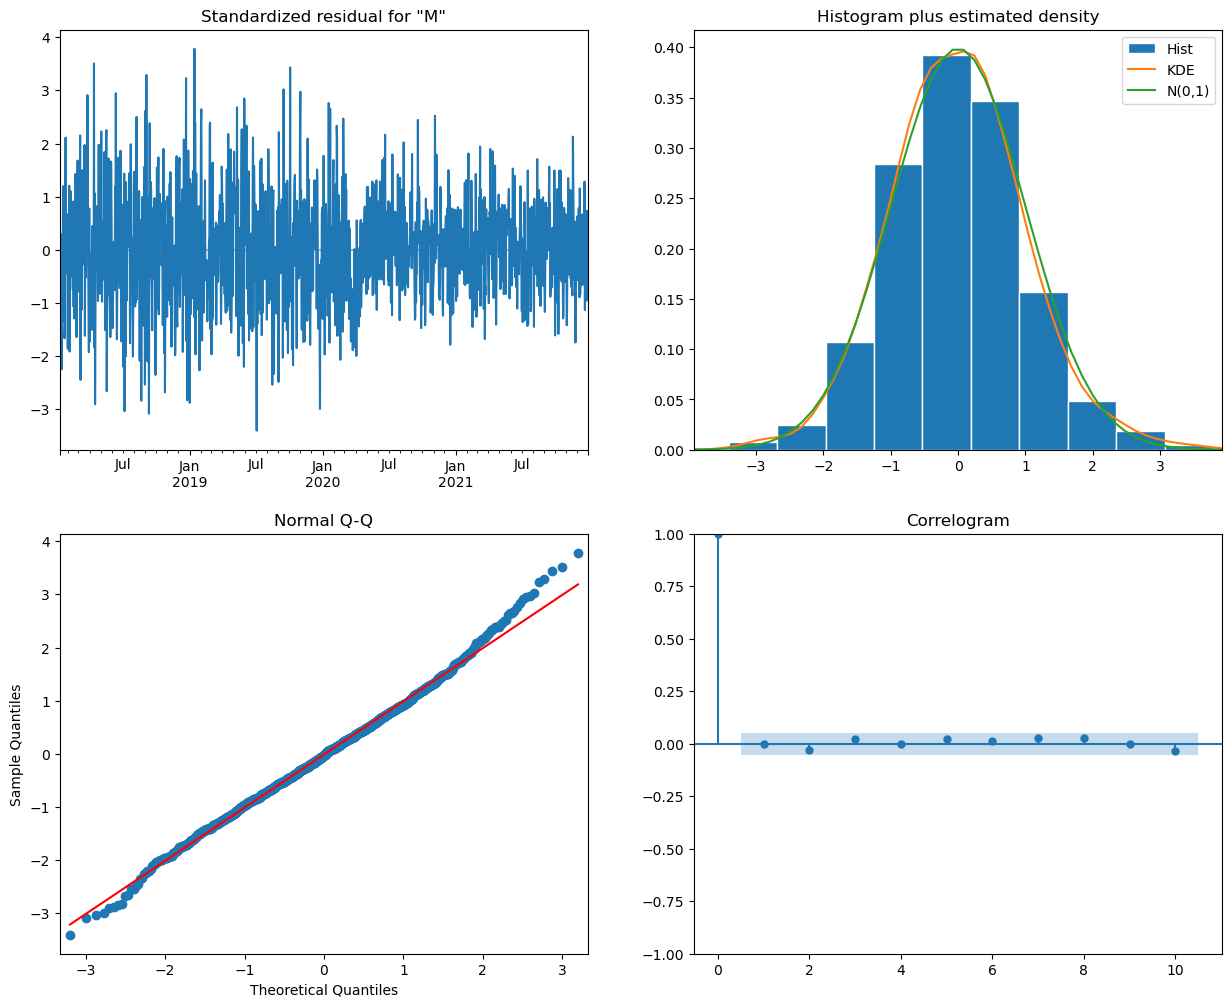

In [82]:
#Plot plot diagnostics
modelmv_2.plot_diagnostics(figsize=(15,12));

The first plot shows off the residuals which is the difference between the observed and predicted values. The plot do seem to have a rnadom distribution around 0, however around May in 2020, there is a clear gap in which looks like an upward trend. 

The second plot is a histogram that shows the distribution of the cause variable. A normal distribution is ideal and our distribution looks pretty normal to me!

The third plot is a quantile-quantile plot that compares the quantiles of the observed data vs the normal distribution quantiles. The ideal distribution would fall directly or as close to the red line as possible and the further from the line, the farther from a normal distribution the data is. 

The fourth and last plot shows the correlations between the cause variable and its past or lagged values. It can give you a look into how correlated the past and present are related to each other. The closer to zero, the weaker the correlation.

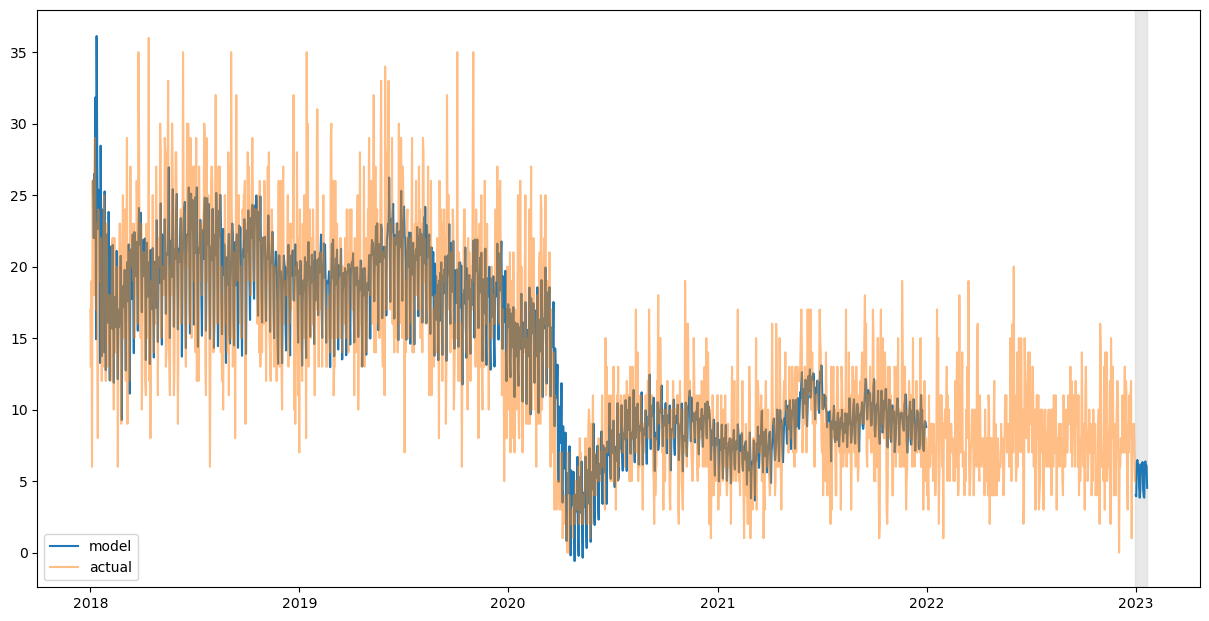

In [83]:
#Plot Model vs Actual number of Moving Violation collisions
ts_mv['arima_model'] = modelmv_2.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast_mv1 = modelmv_2.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast_mv1 = ts_mv['arima_model'].append(forecast_mv1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_mv1, label='model')
plt.axvspan(ts_mv.index[-1], forecast_mv1.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
plt.legend()
plt.show()

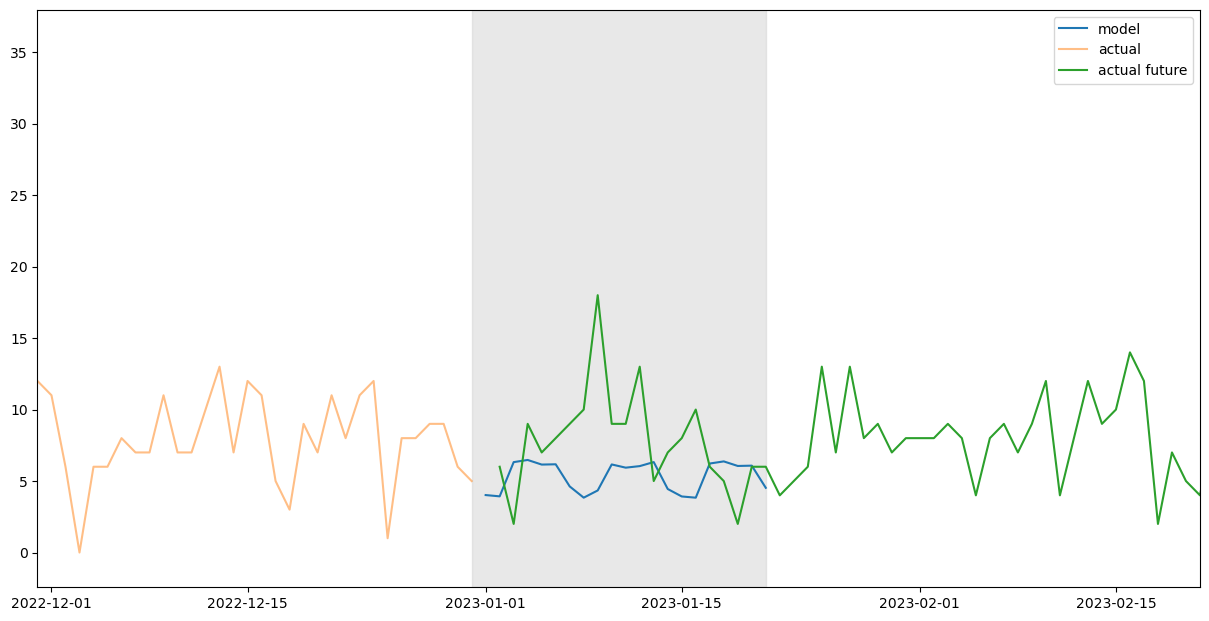

In [84]:
#Closer look
ts_mv['arima_model'] = modelmv_2.fittedvalues
ts_mv['arima_model'][:4+1] = np.NaN
forecast_mv1 = modelmv_2.predict(start=ts_mv.shape[0], end=ts_mv.shape[0] + 20)
forecast_mv1 = ts_mv['arima_model'].append(forecast_mv1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_mv1, label='model')
plt.axvspan(ts_mv.index[-1], forecast_mv1.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_mv['Moving Violation'], label='actual', alpha = 0.5)
plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.xlim(ts_mv.index[-1] - pd.DateOffset(months=1), forecast_mv1.index[-1] + pd.DateOffset(months=1))
plt.legend()
plt.show();

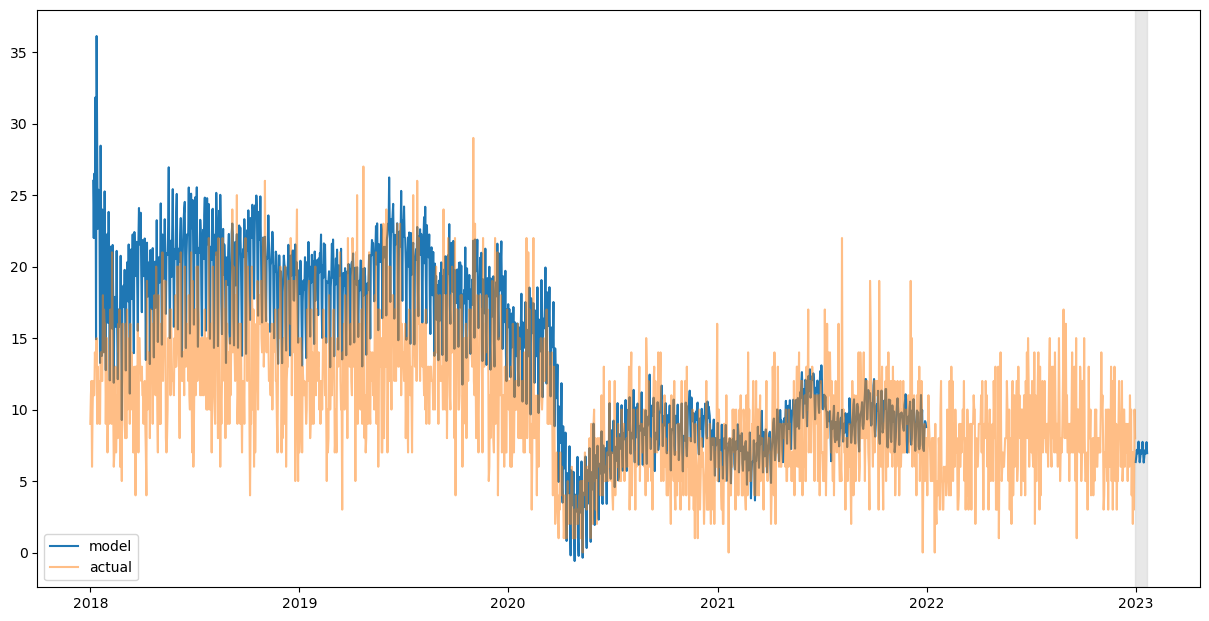

In [85]:
#Plot Model vs Actual number of Driver Inattention collisions
ts_di['arima_model'] = modeldi_2.fittedvalues
ts_di['arima_model'][:4+1] = np.NaN
forecast_di1 = modeldi_2.predict(start=ts_mv.shape[0], end=ts_di.shape[0] + 20)
forecast_di1 = ts_mv['arima_model'].append(forecast_di1)
plt.figure(figsize=(15, 7.5))
plt.plot(forecast_di1, label='model')
plt.axvspan(ts_di.index[-1], forecast_di1.index[-1], alpha=0.5, color='lightgrey')
plt.plot(ts_di['Driver Inattention'], label='actual', alpha = 0.5)
#plt.plot(ts2023_mv['Moving Violation'][1:], label='actual future')
plt.legend()
plt.show()

In [86]:
# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_mv_pred1 = modelmv_1.predict(typ='levels')
train_di_pred1 = modeldi_1.predict(typ='levels')

#Calculate the Root Mean Square Error
rmse_modelmv_1 = np.sqrt(mean_squared_error(train_mv, train_mv_pred1))
rmse_modeldi_1 = np.sqrt(mean_squared_error(train_di, train_di_pred1))

print(f'First Model RMSE for Moving Violation: {rmse_modelmv_1}')
print(f'First Model RMSE for Driver Inattention: {rmse_modeldi_1}')

First Model RMSE for Moving Violation: 4.710354422725186
First Model RMSE for Driver Inattention: 3.702425501684514


In [87]:
train_mv_pred2 = forecast_mv1.dropna()
train_mv_pred2 = train_mv_pred2[:'2023-01-05']

train_di_pred2 = forecast_di1.dropna()
train_di_pred2 = train_di_pred2[:'2023-01-05']

train_mv_pred2

2018-01-06    25.999458
2018-01-07    22.000181
2018-01-08    26.500091
2018-01-09    22.000369
2018-01-10    31.838993
                ...    
2023-01-01     4.019120
2023-01-02     3.929486
2023-01-03     6.323530
2023-01-04     6.474096
2023-01-05     6.152101
Length: 1461, dtype: float64

In [88]:
#Calculate the Root Mean Square Error
rmse_modelmv_2 = np.sqrt(mean_squared_error(train_mv, train_mv_pred2))
rmse_modeldi_2 = np.sqrt(mean_squared_error(train_di, train_di_pred2))

print(f'Second Model RMSE for Moving Violation: {rmse_modelmv_2}')
print(f'Second Model RMSE for Driver Inattention: {rmse_modeldi_2}')

Second Model RMSE for Moving Violation: 5.154329453289957
Second Model RMSE for Driver Inattention: 6.19293393952524


In [89]:
print(f'Moving Violations')
print(f'Baseline Model RMSE: {baseline_mv_rmse}')
print(f'First Model RMSE: {rmse_modelmv_1}')
print(f'Second Model RMSE: {rmse_modelmv_2}')
print()
print(f'Driver Inattention')
print(f'Baseline Model RMSE: {baseline_di_rmse}')
print(f'First Model RMSE: {rmse_modeldi_1}')
print(f'Second Model RMSE: {rmse_modeldi_2}')

Moving Violations
Baseline Model RMSE: 6.141315284583388
First Model RMSE: 4.710354422725186
Second Model RMSE: 5.154329453289957

Driver Inattention
Baseline Model RMSE: 4.974455294748567
First Model RMSE: 3.702425501684514
Second Model RMSE: 6.19293393952524


Oh no! It appears that our SARIMA model performed worse than our first model. The moving violations model still performed better than our baseline, but the driver inattention model score jumped above our baseline.

### Third Model - Prophet
The Prophet model is an open source software and forecasting model developed by Facebook that can model data that has trends such as weekly and seasonalilty in addition to the inclusion of holidays. More information on Prophet as well as installation instructions can be found [here](https://pypi.org/project/fbprophet/#:~:text=Prophet%3A%20Automatic%20Forecasting%20Procedure,daily%20seasonality%2C%20plus%20holiday%20effects). Let's first try modeling without holidays.

In [90]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [91]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X


#Moving Violation
ts_mv2= ts_mv.drop('arima_model', axis=1)
X, y = create_features(ts_mv2, label='Moving Violation')
features_and_target_mv = pd.concat([X, y], axis=1)


#Driver Inattention
ts_di2= ts_di.drop('arima_model', axis=1)
X, y = create_features(ts_di2, label='Driver Inattention')
features_and_target_di = pd.concat([X, y], axis=1)

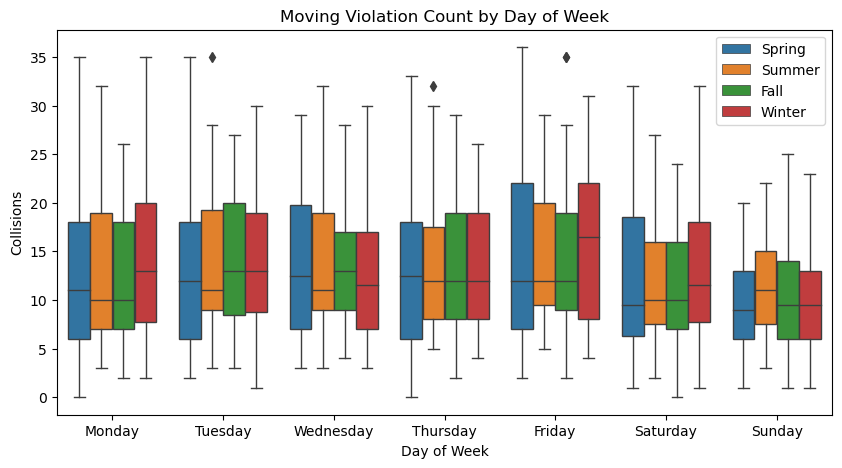

In [92]:
#Look at seasonal count by day 
fig, ax = plt.subplots(figsize=(10, 5))

sns.boxplot(data=features_and_target_mv.dropna(),
            x='weekday',
            y='Moving Violation',
            hue='season',
            ax=ax,
            linewidth=1)

#Customize appearance
ax.set_title('Moving Violation Count by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Collisions')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [93]:
# Format data for prophet model using ds and y for Moving Violation
train_mv_prophet = train_mv.reset_index() 
train_mv_prophet.rename(columns={'CRASH DATE TIME':'ds','Moving Violation':'y'}, inplace=True)

# Format test data for prophet model using ds and y
test_mv_prophet = test_mv.reset_index() 
test_mv_prophet.rename(columns={'CRASH DATE TIME':'ds','Moving Violation':'y'}, inplace=True)

test_mv_prophet.head()

CONTRIBUTING CATEGORY V1         ds     y
0                        2022-01-01   7.0
1                        2022-01-02   4.0
2                        2022-01-03   5.0
3                        2022-01-04   3.0
4                        2022-01-05  11.0

In [94]:
#Format training data for prophet model using ds and y for Driver Inattention
train_di_prophet = train_di.reset_index() 
train_di_prophet.rename(columns={'CRASH DATE TIME':'ds','Driver Inattention':'y'}, inplace=True)

#Format test data for prophet model using ds and y
test_di_prophet = test_di.reset_index() 
test_di_prophet.rename(columns={'CRASH DATE TIME':'ds','Driver Inattention':'y'}, inplace=True)

test_di_prophet.head()

CONTRIBUTING CATEGORY V1         ds     y
0                        2022-01-01   8.0
1                        2022-01-02   4.0
2                        2022-01-03   8.0
3                        2022-01-04  11.0
4                        2022-01-05   9.0

In [95]:
model_mv = Prophet()
model_mv.fit(train_mv_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -22.6766
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2242.63    0.00206049       98.7419      0.9525      0.9525      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       2243.02   0.000996035       167.894   9.482e-06       0.001      175  LS failed, Hessian reset 
     199       2243.96   3.60924e-06       70.7571           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       2243.96   1.02197e-07       73.9496      0.2529           1      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [96]:
model_di = Prophet()
model_di.fit(train_di_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -26.1448


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2255.28   6.43269e-05       62.8261      0.4813      0.4813      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2257.11   7.41594e-05       56.4613       2.612      0.2612      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       2257.11   5.29736e-06       52.7724   8.339e-08       0.001      296  LS failed, Hessian reset 
     244       2257.11   1.10476e-07       59.7174     0.09791      0.7188      356   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [97]:
#Predict for Moving Violations
mv_test_forecast = model_mv.predict(test_mv_prophet)
mv_test_forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-01-01  9.052043    0.319283   11.949913     9.052043     9.052043   
1 2022-01-02  9.054023   -1.043677    9.979844     9.054023     9.054023   
2 2022-01-03  9.056003    1.964618   13.322496     9.056003     9.056003   
3 2022-01-04  9.057983    2.236144   13.512220     9.057983     9.057983   
4 2022-01-05  9.059963    2.644420   13.636400     9.059963     9.059963   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -2.552903             -2.552903             -2.552903 -1.005177   
1       -4.623489             -4.623489             -4.623489 -3.022037   
2       -1.471419             -1.471419             -1.471419  0.160784   
3       -1.026262             -1.026262             -1.026262  0.613275   
4       -0.983597             -0.983597             -0.983597  0.639906   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -1.005177     -1.005177 -1.547726     -1.547726     -1.547726   
1     -3.022037     -3.022037 -1.601452     -1.601452     -1.601452   
2      0.160784      0.160784 -1.632203     -1.632203     -1.632203   
3      0.613275      0.613275 -1.639538     -1.639538     -1.639538   
4      0.639906      0.639906 -1.623503     -1.623503     -1.623503   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0  6.499140  
1                         0.0  4.430534  
2                         0.0  7.584584  
3                         0.0  8.031721  
4                         0.0  8.076366

In [98]:
#Predict for Driver Inattention
di_test_forecast = model_di.predict(test_di_prophet)
di_test_forecast.head()

ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2022-01-01  8.791900    2.209074   11.642463     8.791900     8.791900   
1 2022-01-02  8.796347    1.366757   10.735926     8.796347     8.796347   
2 2022-01-03  8.800793    3.035792   12.160727     8.800793     8.800793   
3 2022-01-04  8.805240    2.568198   11.928730     8.805240     8.805240   
4 2022-01-05  8.809686    2.223981   11.834794     8.809686     8.809686   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -1.648006             -1.648006             -1.648006 -0.214896   
1       -2.822957             -2.822957             -2.822957 -1.308478   
2       -1.475944             -1.475944             -1.475944  0.099550   
3       -1.392791             -1.392791             -1.392791  0.222225   
4       -1.751601             -1.751601             -1.751601 -0.119224   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0     -0.214896     -0.214896 -1.433110     -1.433110     -1.433110   
1     -1.308478     -1.308478 -1.514478     -1.514478     -1.514478   
2      0.099550      0.099550 -1.575494     -1.575494     -1.575494   
3      0.222225      0.222225 -1.615016     -1.615016     -1.615016   
4     -0.119224     -0.119224 -1.632377     -1.632377     -1.632377   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper      yhat  
0                         0.0  7.143895  
1                         0.0  5.973390  
2                         0.0  7.324849  
3                         0.0  7.412449  
4                         0.0  7.058085

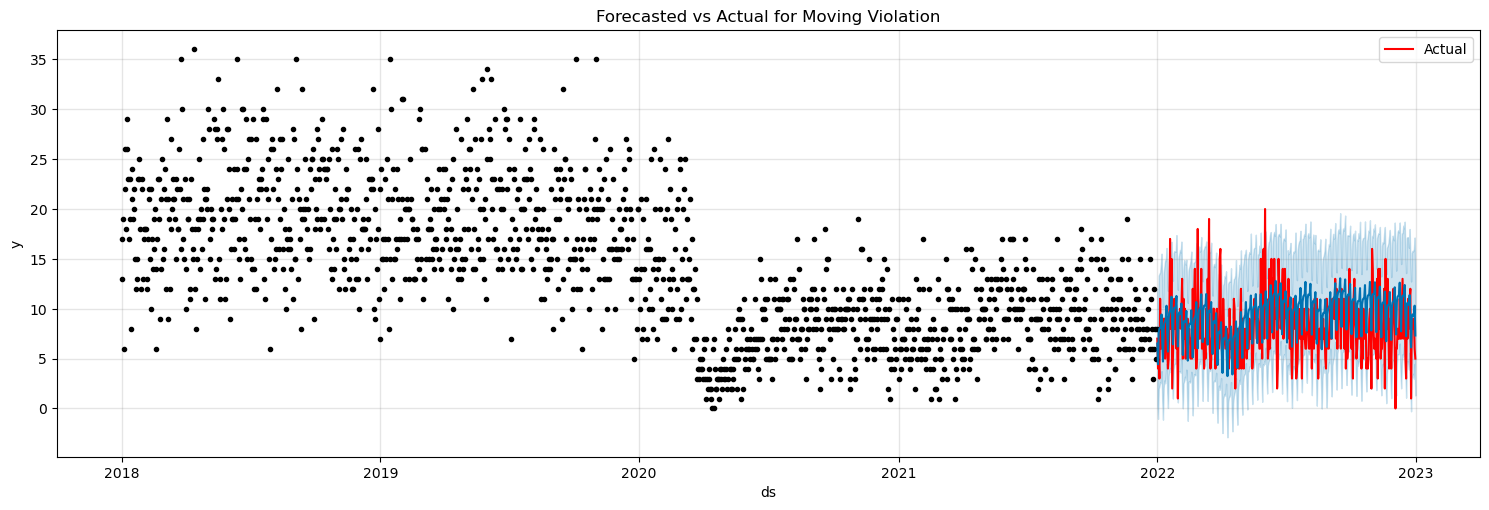

In [99]:
#Plot the forecast with the actuals for Moving Violations
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_mv_prophet['ds'], test_mv_prophet['y'], color='r', label='Actual')
model_mv.plot(mv_test_forecast, ax=ax)
ax.legend(loc='upper right')

plt.title('Forecasted vs Actual for Moving Violation');

Text(0.5, 1.0, 'January 2022 Forecast vs Actuals')

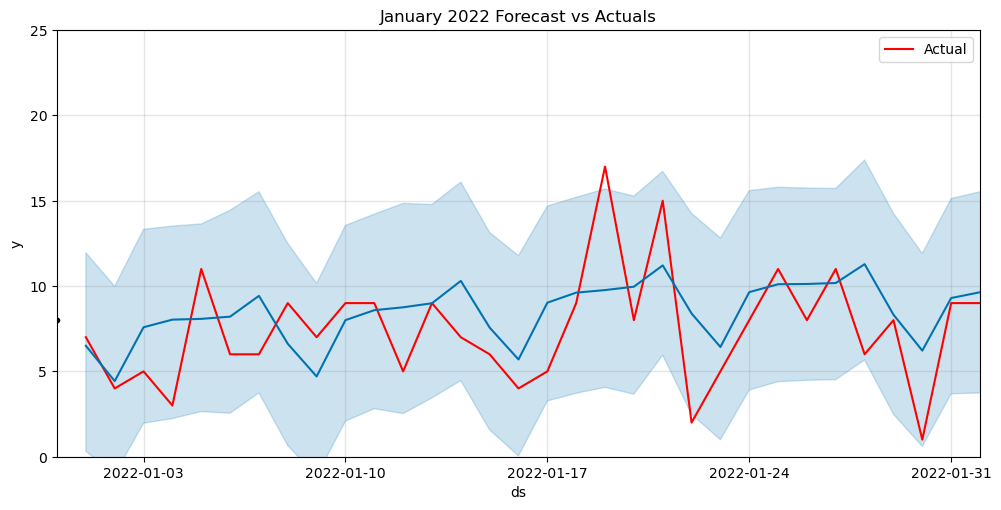

In [100]:
#Closer look at the difference between the Forecasted and Actual in January 2022 for Moving Violations
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(test_mv_prophet['ds'], test_mv_prophet['y'], color='r', label='Actual')
model_mv.plot(mv_test_forecast, ax=ax)

ax.set_xlim(pd.Timestamp('2022-03-01') - pd.Timedelta(days=60), pd.Timestamp('2022-02-01'))
ax.set_ylim(0, 25)
ax.legend(loc='upper right')

plt.title('January 2022 Forecast vs Actuals')

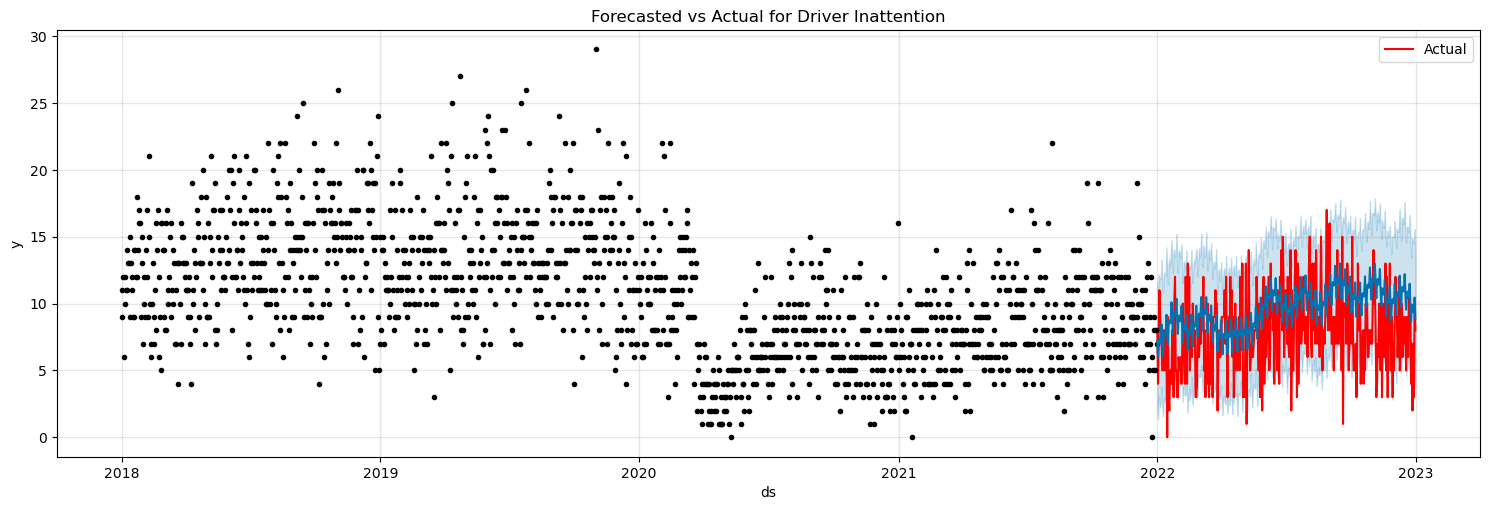

In [101]:
#Plot the forecast with the actuals for Driver Inattention
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_di_prophet['ds'], test_di_prophet['y'], color='r', label='Actual')
model_di.plot(di_test_forecast, ax=ax)
ax.legend(loc='upper right')
plt.title('Forecasted vs Actual for Driver Inattention');

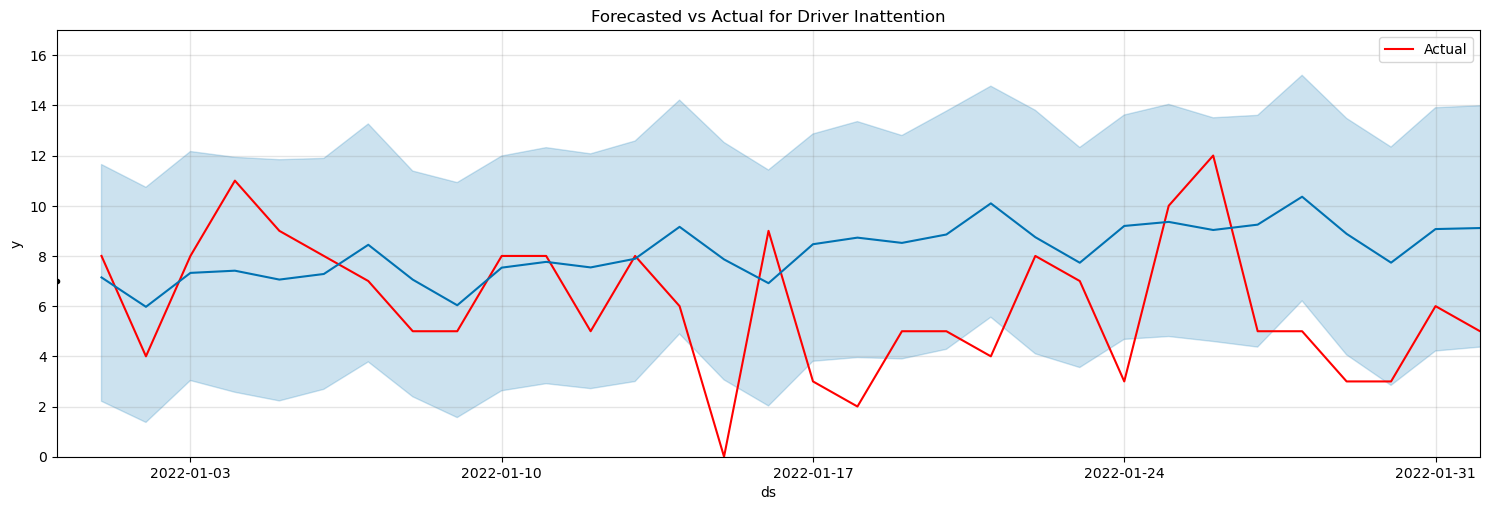

In [102]:
#Closer look at the difference between the Forecasted and Actual in January 2022 for Driver Inattention
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_di_prophet['ds'], test_di_prophet['y'], color='r', label='Actual')
model_di.plot(di_test_forecast, ax=ax)

ax.set_xlim(pd.Timestamp('2022-03-01') - pd.Timedelta(days=60), pd.Timestamp('2022-02-01'))
ax.set_ylim(0, 17)
ax.legend(loc='upper right')

plt.title('Forecasted vs Actual for Driver Inattention');

In [103]:
#Calculate RMSE 
rmse_modelmv_3 = np.sqrt(mean_squared_error(y_true=test_mv_prophet['y'],
                                          y_pred=mv_test_forecast['yhat']))

rmse_modeldi_3 = np.sqrt(mean_squared_error(y_true=test_di_prophet['y'],
                                          y_pred=di_test_forecast['yhat']))

print(f'Third Model RMSE for Moving Violation: {rmse_modelmv_3}')
print(f'Third Model RMSE for Driver Inattention: {rmse_modeldi_3}')

Third Model RMSE for Moving Violation: 3.4786830965460895
Third Model RMSE for Driver Inattention: 3.500292868631046


Fantastic! Our prophet model is our best model yet! Let's run another model that includes the addition of holidays to see if it affects performance. 

### Final Model - Prophet with Holidays
Our final model will be running a Prophet model again, but this time with the holidays. During the holidays, people tend to travel to their families so more people are on the road. This can result in longer travel times increasing fatigue, congestion increasing driver irritability, and so much more. Although holidays are great fun, they might not be the safest time for drivers to be on the road.

In [104]:
cal = calendar()

#Make dataframe that starts and ends within same time range as main dataframe
holidays = cal.holidays(start=ts_mv.index.min(),
                        end=ts_mv.index.max(),
                        return_name=True)

holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])

holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})
holidays.head()

2018-01-01                         New Year's Day
2018-01-15    Birthday of Martin Luther King, Jr.
2018-02-19                  Washington’s Birthday
2018-05-28                           Memorial Day
2018-07-04                       Independence Day
dtype: object

In [105]:
#Check the unique number of holidays 
holiday_df['holiday'].value_counts()

New Year's Day                          5
Birthday of Martin Luther King, Jr.     5
Washington’s Birthday                   5
Memorial Day                            5
Independence Day                        5
Labor Day                               5
Columbus Day                            5
Veterans Day                            5
Thanksgiving Day                        5
Christmas Day                           5
Juneteenth National Independence Day    2
Name: holiday, dtype: int64

In [106]:
#Rename MLK Day so it follows format of other holidays
holiday_df['holiday'] = holiday_df['holiday'].replace('Birthday of Martin Luther King, Jr.', 'Martin Luther King, Jr. Day')
holiday_df.head()

ds                      holiday
0 2018-01-01               New Year's Day
1 2018-01-15  Martin Luther King, Jr. Day
2 2018-02-19        Washington’s Birthday
3 2018-05-28                 Memorial Day
4 2018-07-04             Independence Day

In [107]:
#Model with holidays for Moving Violations
model_with_holidays_mv = Prophet(holidays=holiday_df)
model_with_holidays_mv.fit(train_mv_prophet)

#Model with holidays for Driver Inattention
model_with_holidays_di = Prophet(holidays=holiday_df)
model_with_holidays_di.fit(train_di_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -22.6766
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2262.26    0.00954952       113.054           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176        2264.2     0.0015483       149.158   2.172e-05       0.001      275  LS failed, Hessian reset 
     199        2264.8    0.00110388       80.8586        2.17       0.217      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       2264.95   1.44725e-05       80.4604   2.095e-07       0.001      451  LS failed, Hessian reset 
     299       2264.95   2.52999e-05       85.9646           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       2265.01   8.60077e-08       64.9034      0.2338           1      549   
Optimization terminat

      99       2261.25   6.65952e-05       72.9258      0.3586      0.3586      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       2262.59   0.000685497       69.7652    8.76e-06       0.001      219  LS failed, Hessian reset 
     199       2263.38   0.000954617       77.3247      0.4386           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       2263.43   0.000355165       77.5328   4.693e-06       0.001      361  LS failed, Hessian reset 
     275       2263.44   1.40506e-07       56.3838           1           1      427   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [108]:
#Predict on training set with model
#For Moving Violations
mv_test_fcst_with_hols_mv = model_with_holidays_mv.predict(df=test_mv_prophet)

#For Driver Inattention
mv_test_fcst_with_hols_di = model_with_holidays_di.predict(df=test_di_prophet)

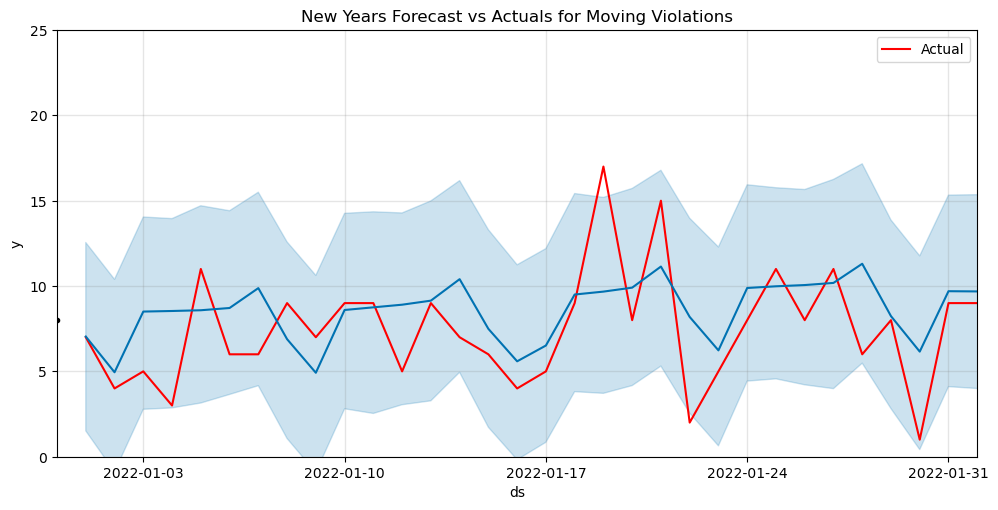

In [109]:
#Closer look at the difference between the Forecasted and Actual in January 2022
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(test_mv_prophet['ds'], test_mv_prophet['y'], color='r', label='Actual')
model_mv.plot(mv_test_fcst_with_hols_mv, ax=ax)

ax.set_xlim(pd.Timestamp('2022-03-01') - pd.Timedelta(days=60), pd.Timestamp('2022-02-01'))
ax.set_ylim(0, 25)
ax.legend(loc='upper right')
plt.title('New Years Forecast vs Actuals for Moving Violations');

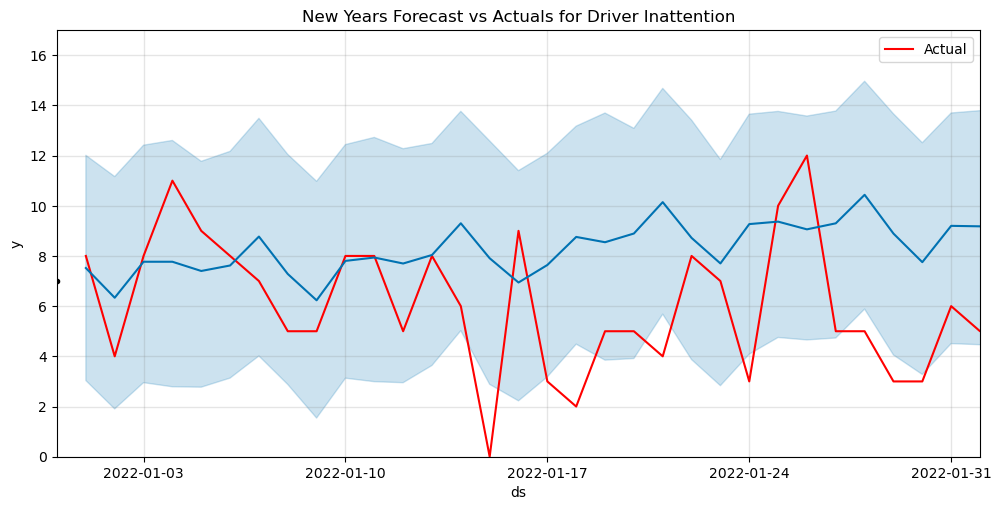

In [110]:
#Closer look at the difference between the Forecasted and Actual in January 2022
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(test_di_prophet['ds'], test_di_prophet['y'], color='r', label='Actual')
model_di.plot(mv_test_fcst_with_hols_di, ax=ax)

ax.set_xlim(pd.Timestamp('2022-03-01') - pd.Timedelta(days=60), pd.Timestamp('2022-02-01'))
ax.set_ylim(0, 17)
ax.legend(loc='upper right')

plt.title('New Years Forecast vs Actuals for Driver Inattention');

In [111]:
#Calculate RMSE
rmse_modelmv_4 = np.sqrt(mean_squared_error(y_true=test_mv_prophet['y'],
                                          y_pred=mv_test_forecast['yhat']))

rmse_modeldi_4 = np.sqrt(mean_squared_error(y_true=test_di_prophet['y'],
                                          y_pred=di_test_forecast['yhat']))

print(f'Fourth Model RMSE for Moving Violation: {rmse_modelmv_4}')
print(f'Fourth Model RMSE for Driver Inattention: {rmse_modeldi_4}')

Fourth Model RMSE for Moving Violation: 3.4786830965460895
Fourth Model RMSE for Driver Inattention: 3.500292868631046


Interesting. The addition of holidays did not improve or weak our model performance. It stayed exactly the same as the previous model. However, the RMSE of our collision causes are closer than they've ever been! Since there cannot be half of an accident, we'll round this to an error of 3 collisions per day for collisions caused by moving violations and an error of 4 collisions per day for collisions caused by driver inattention.

In [112]:
#Forcasting for Moving Violations
future_mv = model_mv.make_future_dataframe(periods=365*24, freq='D', include_history=False)
forecast_mv = model_with_holidays_mv.predict(future_mv)

#Forcasting for Driver Inattention
future_di = model_di.make_future_dataframe(periods=365*24, freq='D', include_history=False)
forecast_di = model_with_holidays_di.predict(future_di)

In [113]:
#Dataframe for forecasts for Moving Violation
forecast_2023_mv = forecast_mv[forecast_mv['ds'] <= '2024-01-01']

#Dataframe for forecasts for Driver Inattention
forecast_2023_di = forecast_di[forecast_di['ds'] <= '2024-01-01']

#Actual Moving Violation collision values
actual_mv2023 = ts2023_pivt[['Moving Violation']]

#Actual Driver Inattention collision values
actual_di2023 = ts2023_pivt[['Driver Inattention']]

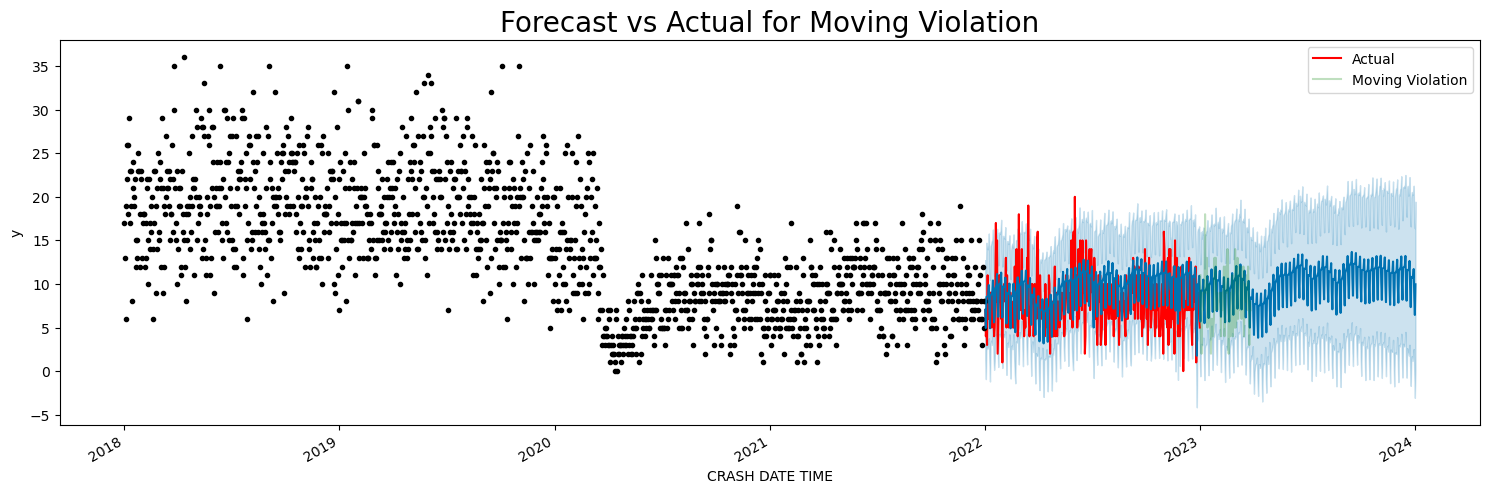

In [114]:
#Plot the forecast with the actuals for Moving Violation
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_mv_prophet['ds'], test_mv_prophet['y'], color='r', label='Actual')
model_mv.plot(forecast_2023_mv, ax=ax)
actual_mv2023.plot(ax=ax, color='g', alpha =0.25)
ax.legend(loc='upper right')

plt.title('Forecast vs Actual for Moving Violation', fontsize = 20);    

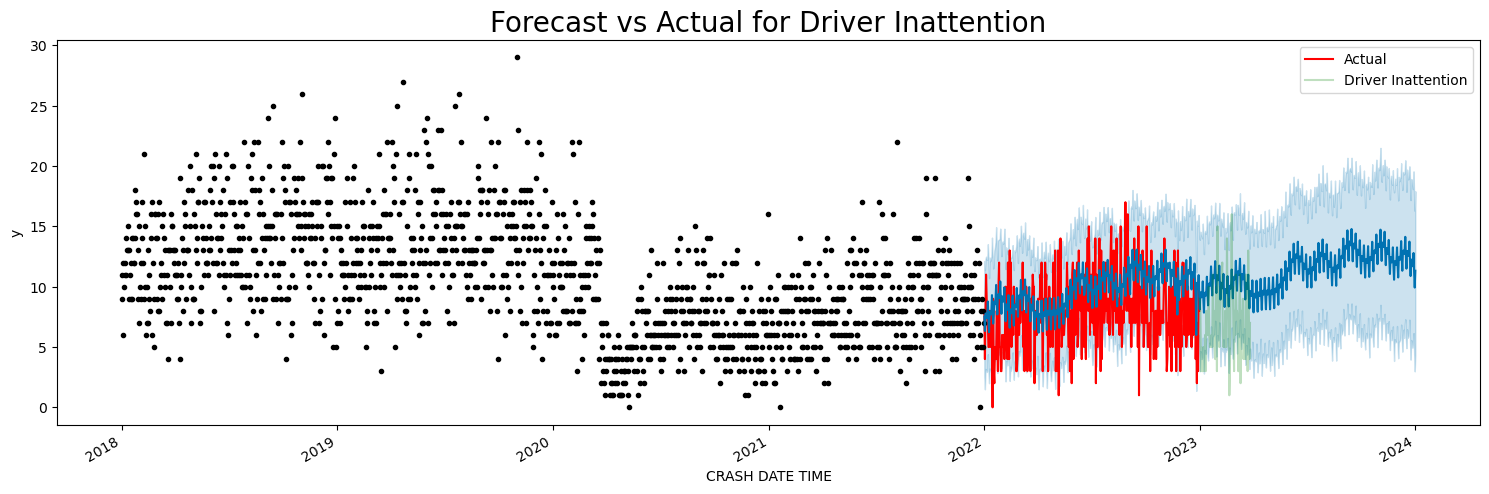

In [115]:
# Plot the forecast with the actuals for Moving Violation
f, ax = plt.subplots(figsize=(15, 5))

ax.plot(test_di_prophet['ds'], test_di_prophet['y'], color='r', label='Actual')
model_di.plot(forecast_2023_di, ax=ax)
actual_di2023.plot(ax=ax, color='g', alpha =0.25)
ax.legend(loc='upper right')

plt.title('Forecast vs Actual for Driver Inattention', fontsize = 20);    

In [116]:
#Create copies of dataframe for plotting
actual_mv2023 = actual_mv2023.copy()
actual_mv2023.rename(columns={'Moving Violation':'Actual'}, inplace=True)

actual_di2023 = actual_di2023.copy()
actual_di2023.rename(columns={'Driver Inattention':'Actual'}, inplace=True)

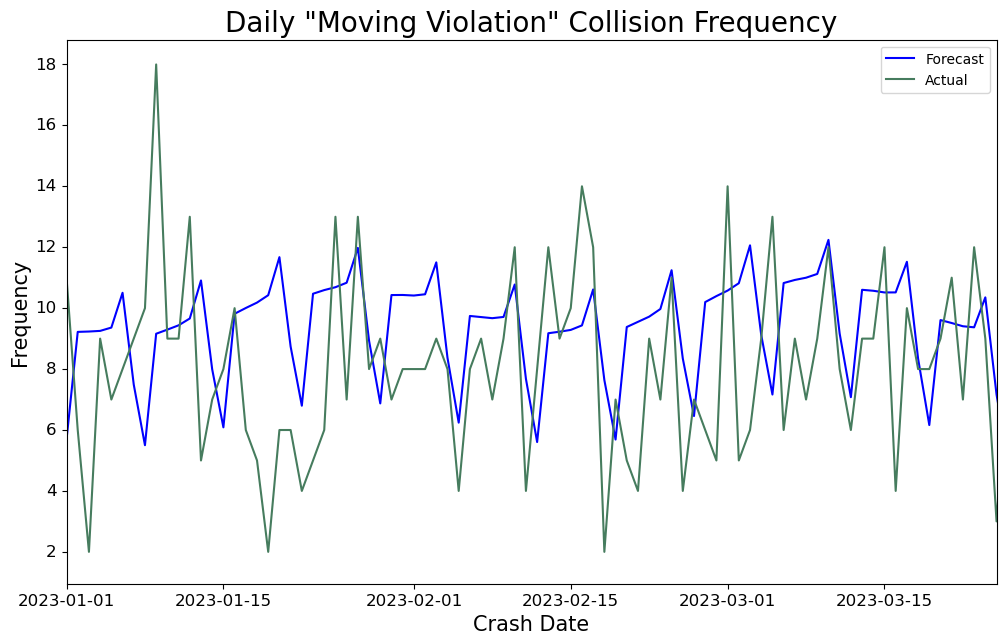

In [117]:
#Set up plot
fig, ax = plt.subplots(figsize=(12, 8))

#Create label for forecast plot
line = Line2D(forecast_2023_mv['ds'], forecast_2023_mv['yhat'], color='blue', label='Forecast')
ax.add_line(line)

actual_mv2023.plot(ax=ax, color='#467c5eff')

#Change the x-axis range to get a closer look 
ax.set_xlim(pd.Timestamp('2023-04-01') - pd.Timedelta(days=90), pd.Timestamp('2023-03-25'))

#Customize appearance
ax.set_title('Daily "Moving Violation" Collision Frequency', fontsize = 20)    
ax.set_xlabel('Crash Date', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.legend(loc='upper right')
ax.tick_params(axis='both', which='major', labelsize=12, labelrotation=0)
ax.tick_params(axis='both', which='minor', labelsize=12, labelrotation=0)

#Center the tick labels on both the x and y axes
for tick in ax.get_xticklabels():
    tick.set_horizontalalignment('center')
for tick in ax.get_yticklabels():
    tick.set_verticalalignment('center')


#Export plot
fig.savefig('images/CollisionFrequency_MovingViolation', transparent=True);

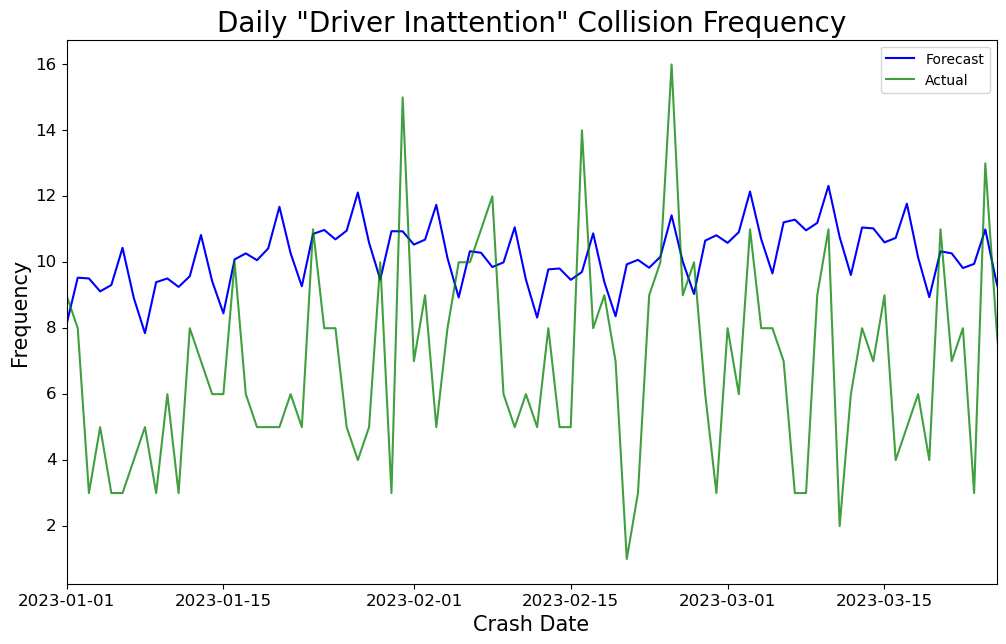

In [118]:
#Set up plot
fig, ax = plt.subplots(figsize=(12, 8))

#Create label for forecast plot
line = Line2D(forecast_2023_di['ds'], forecast_2023_di['yhat'], color='blue', label='Forecast')
ax.add_line(line)

actual_di2023.plot(ax=ax, color='g', alpha =0.75)

#Change the x-axis range to get a closer look 
ax.set_xlim(pd.Timestamp('2023-04-01') - pd.Timedelta(days=90), pd.Timestamp('2023-03-25'))

#Customize appearance
ax.set_title('Daily "Driver Inattention" Collision Frequency', fontsize = 20)    
ax.set_xlabel('Crash Date', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.legend(loc='upper right')
ax.tick_params(axis='both', which='major', labelsize=12, labelrotation=0)
ax.tick_params(axis='both', which='minor', labelsize=12, labelrotation=0)

#Center the tick labels on both the x and y axes
for tick in ax.get_xticklabels():
    tick.set_horizontalalignment('center')
for tick in ax.get_yticklabels():
    tick.set_verticalalignment('center')


#Export plot
fig.savefig('images/CollisionFrequency_DriverInattention', transparent=True);

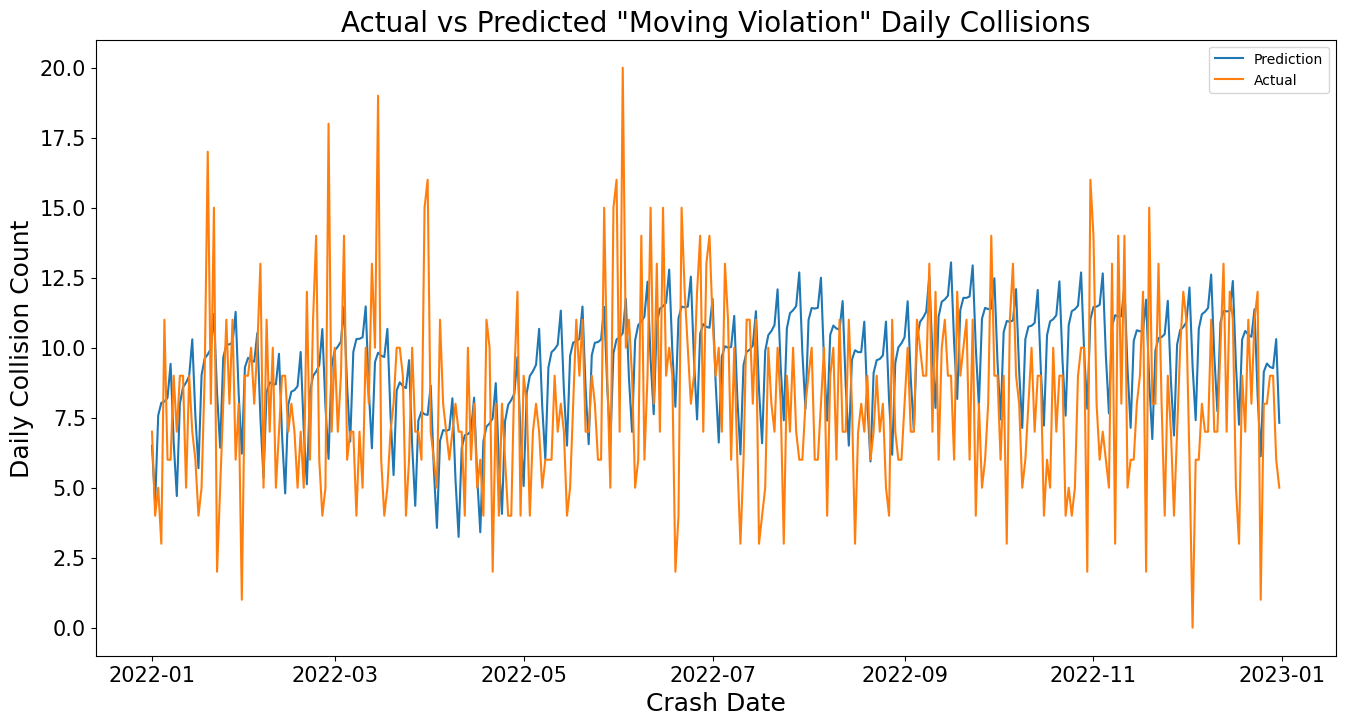

In [119]:
#Set up plot

fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_mv_prophet['ds'],mv_test_forecast['yhat'],label='Prediction')
ax.plot(test_mv_prophet['ds'],test_mv_prophet['y'],label='Actual')

#Customize appearance
ax.set_xlabel('Crash Date', fontsize = 18);
ax.set_ylabel('Daily Collision Count', fontsize = 18)
ax.set_title('Actual vs Predicted "Moving Violation" Daily Collisions', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend()

plt.show()


#Export plot
fig.savefig('images/ActualVSPredicted_MovingViolation', transparent=True);

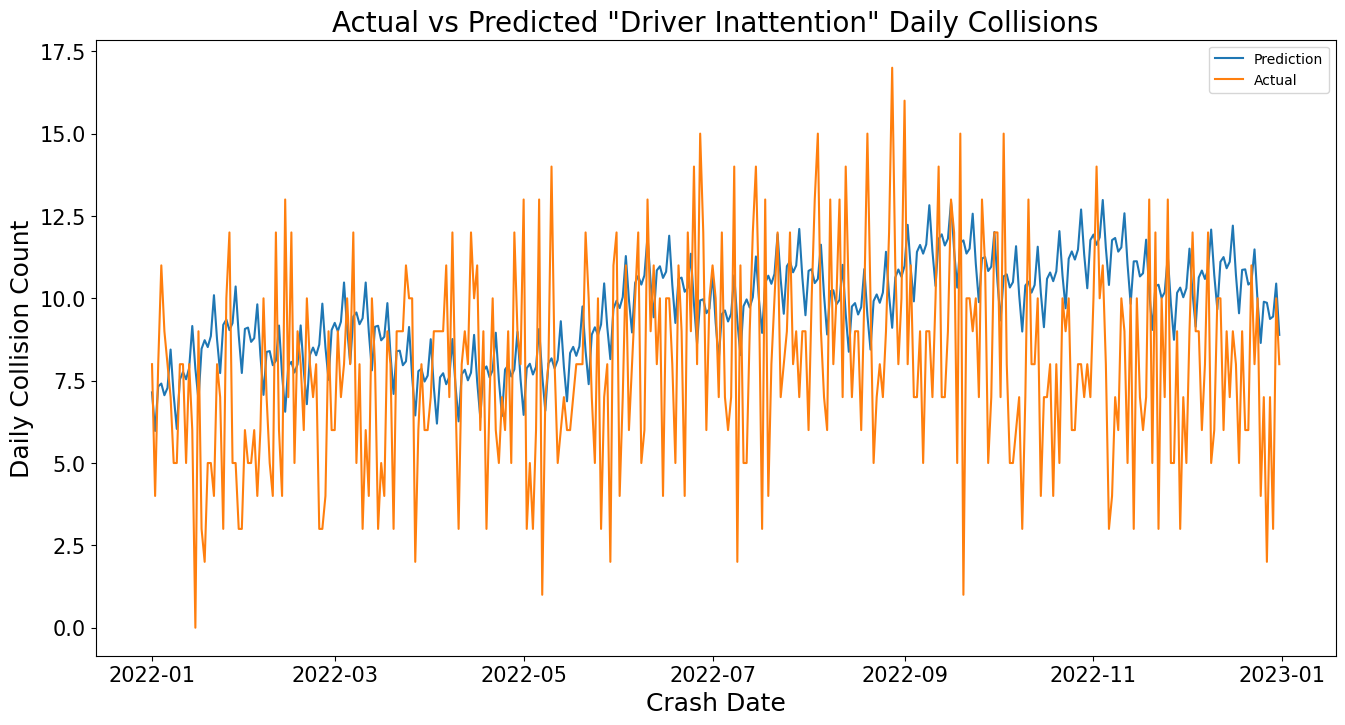

In [120]:
#Set up plot
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(test_di_prophet['ds'],di_test_forecast['yhat'],label='Prediction')
ax.plot(test_di_prophet['ds'],test_di_prophet['y'],label='Actual')

#Customize appearance
ax.set_xlabel('Crash Date', fontsize = 18);
ax.set_ylabel('Daily Collision Count', fontsize = 18)
ax.set_title('Actual vs Predicted "Driver Inattention" Daily Collisions', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.legend()

plt.show()


#Export plot
fig.savefig('images/ActualVSPredicted_DriverInattention', transparent=True);

## Visualizations
Let's make some visuals to help us better understand the information at hand. We will be making our plots first and then moving onto making some maps channeling our inner cartographer.

### Plots
Let's start! Plots here we come!

#### Season

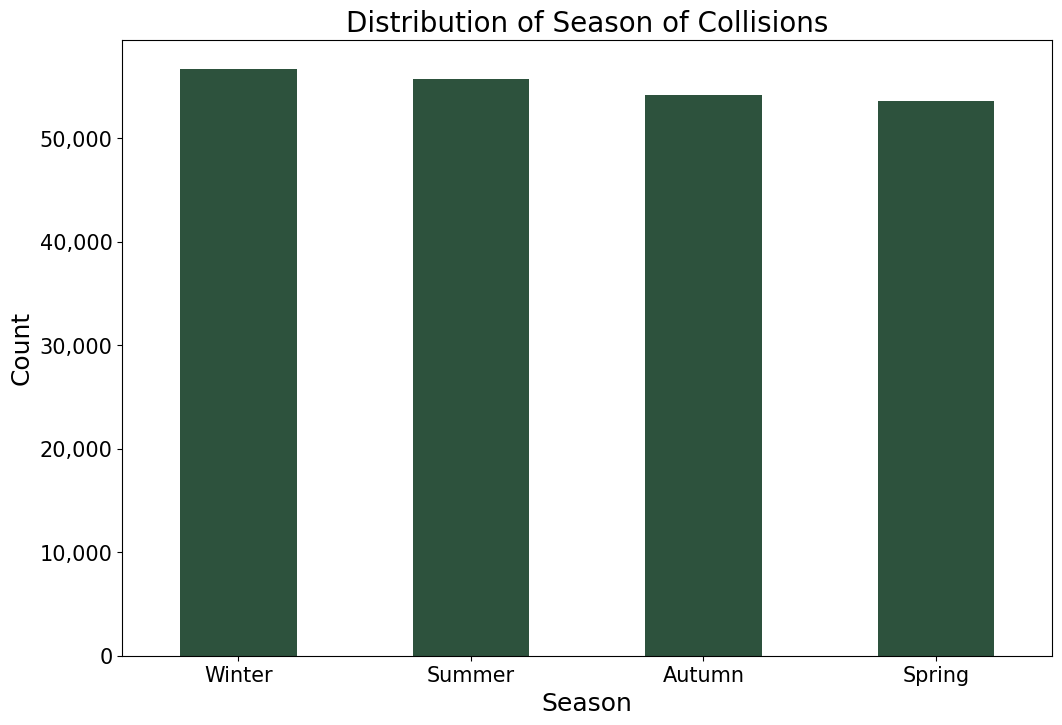

In [121]:
#Set up plot
fig, (ax) = plt.subplots(figsize=(12,8))

df_visuals['SEASON'].value_counts().plot(kind='bar', color='#2d523d')

#Customize appearance
ax.set_xlabel('Season', fontsize = 18);
ax.set_ylabel('Count', fontsize = 18)
ax.set_title('Distribution of Season of Collisions', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15, labelrotation=0)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))


#Export plot
fig.savefig('images/SeasonDistribution', transparent=True);

#### Time of Day

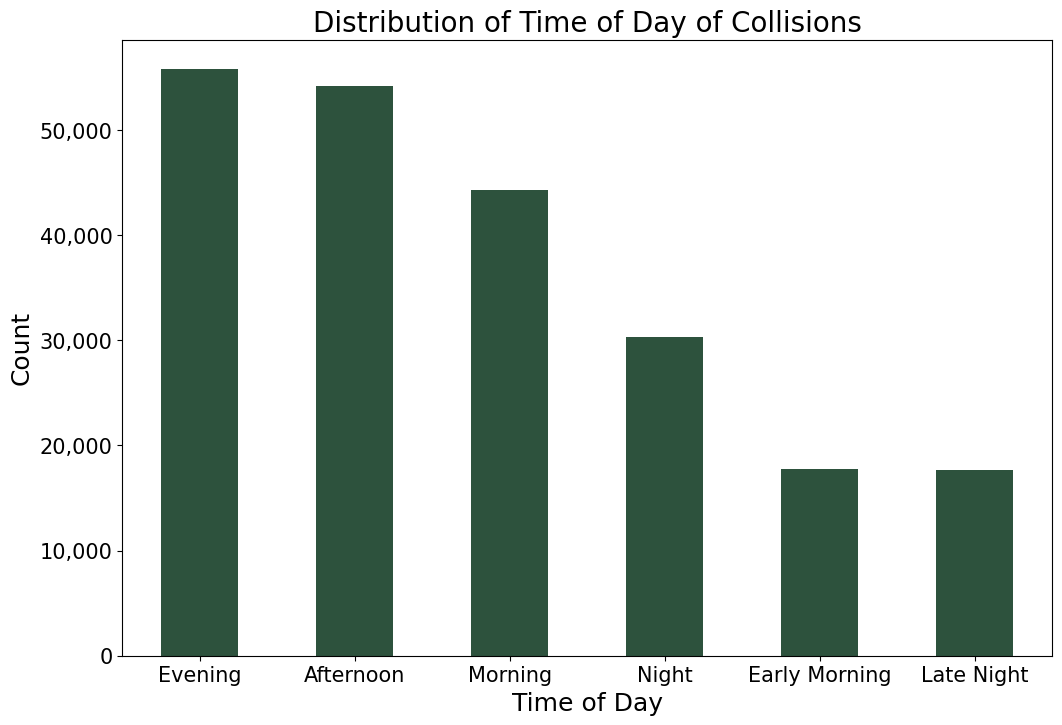

In [122]:
#Set up plot
fig, (ax) = plt.subplots(figsize=(12,8))

df_visuals['TIME OF DAY'].value_counts().plot(kind='bar', color='#2d523d')

#Customize appearance
ax.set_xlabel('Time of Day', fontsize = 18);
ax.set_ylabel('Count', fontsize = 18)
ax.set_title('Distribution of Time of Day of Collisions', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15, labelrotation=0)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))


#Export plot
fig.savefig('images/TimeOfDayDistribution', transparent=True);

#### Rush Hour

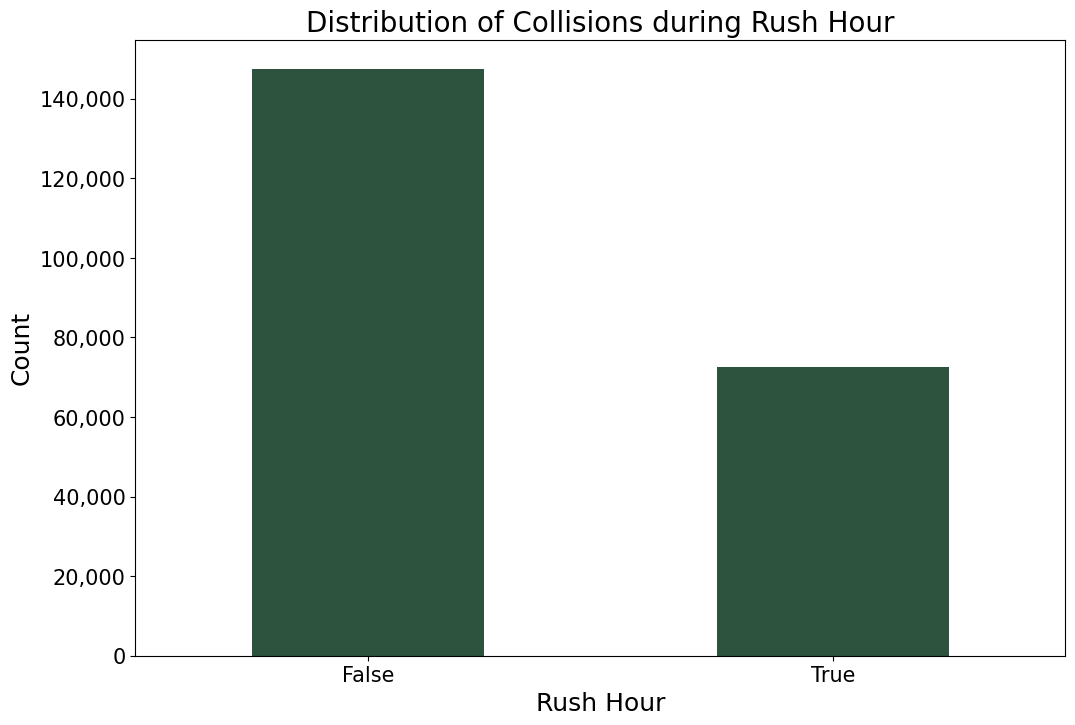

In [123]:
#Set up plot
fig, (ax) = plt.subplots(figsize=(12,8))

df_visuals['IS RUSH HOUR'].value_counts().plot(kind='bar', color='#2d523d')

#Customize appearance
ax.set_xlabel('Rush Hour', fontsize = 18);
ax.set_ylabel('Count', fontsize = 18)
ax.set_title('Distribution of Collisions during Rush Hour', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15, labelrotation=0)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))


#Export plot
fig.savefig('images/RushHourDistribution', transparent=True)

#### Zip Code

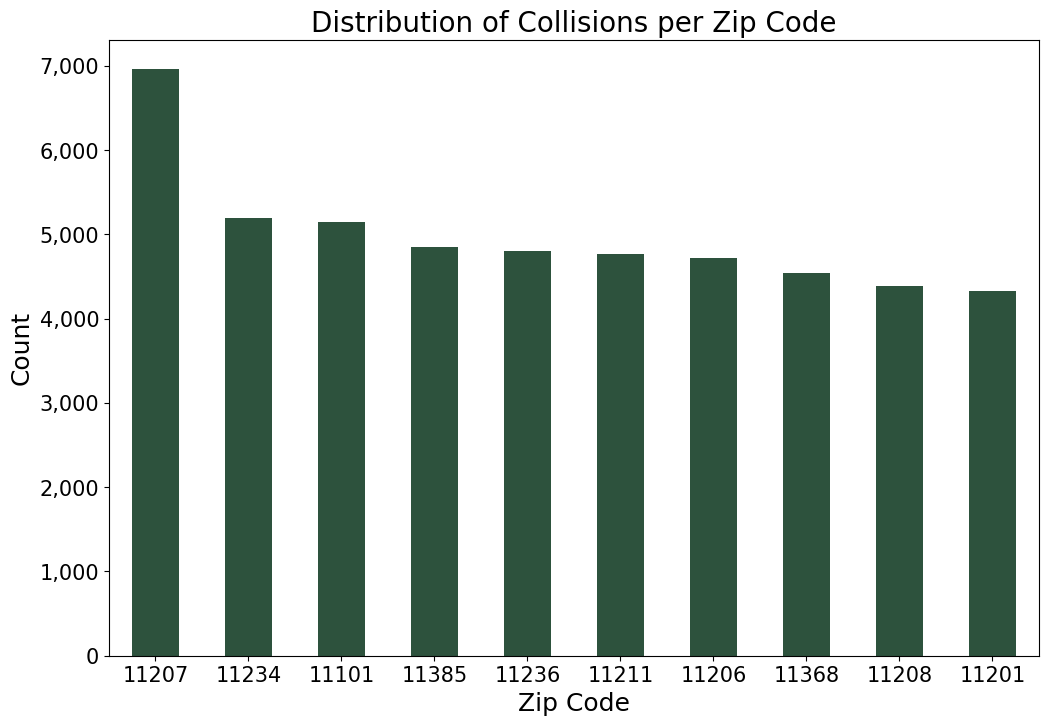

In [124]:
#Set up plot
fig, (ax) = plt.subplots(figsize=(12,8))

df_visuals['ZIP CODE'].value_counts().head(10).plot(kind='bar', color='#2d523d')

#Customize appearance
ax.set_xlabel('Zip Code', fontsize = 18);
ax.set_ylabel('Count', fontsize = 18)
ax.set_title('Distribution of Collisions per Zip Code', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15, labelrotation=0)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))


#Export plot
fig.savefig('images/ZipCodeDistribution', transparent=True)

In [125]:
#Create copy of dataframe for plotting
injured2 = injured.copy()
injured2 = injured2.sort_values(by='NUMBER OF PERSONS INJURED', ascending=False)
injured2.head()

NUMBER OF PERSONS INJURED
ZIP CODE                           
11207                          2686
11236                          2151
11234                          2014
11101                          1474
11385                          1461

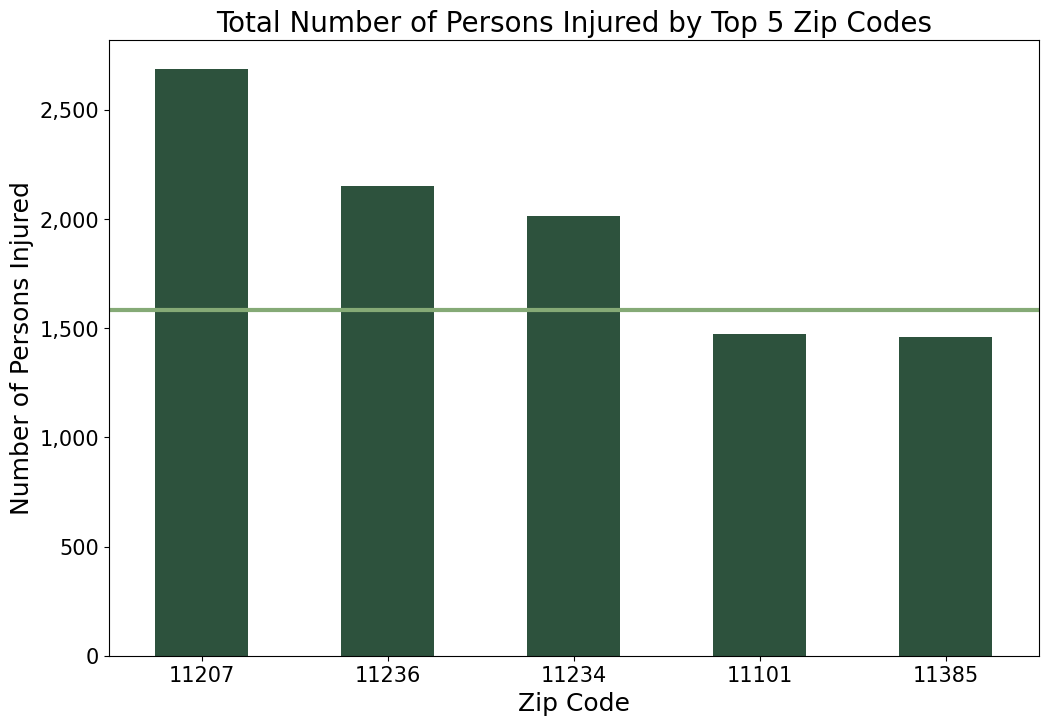

In [126]:
#Plot bar chart of injuries
ax = injured2.head().plot(kind='bar', figsize=(12, 8), color='#2d523d', legend=False)

#Customize appearance
ax.set_title('Total Number of Persons Injured by Top 5 Zip Codes', fontsize = 20)
ax.set_xlabel('Zip Code', fontsize = 18)
ax.set_ylabel('Number of Persons Injured', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=15, labelrotation=0)
ax.tick_params(axis='both', which='minor', labelsize=15)

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

ax.axhline(y=injured['NUMBER OF PERSONS INJURED'].mean(), color='#85aa76ff', linewidth=3);

#Show the plot
plt.show()

#Export plot
fig.savefig('images/Top5TotalInjuriesByZipCode', transparent=True);

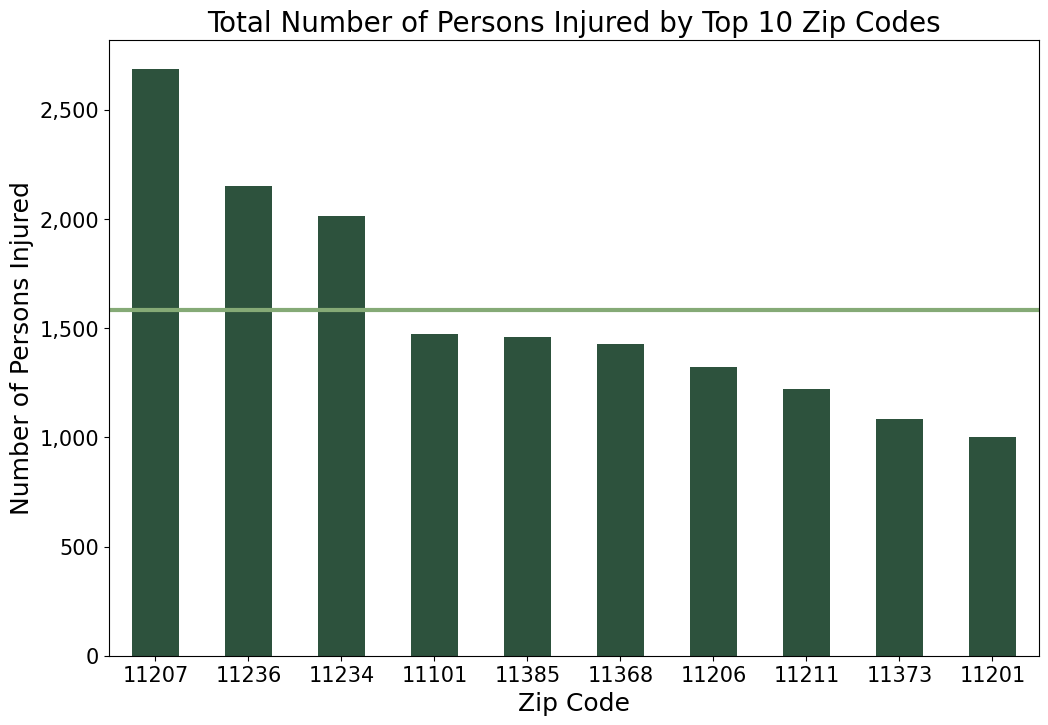

In [127]:
#Plot bar chart of injuries
ax = injured2.plot(kind='bar', figsize=(12, 8), color='#2d523d', legend=False)

#Customize appearance
ax.set_title('Total Number of Persons Injured by Top 10 Zip Codes', fontsize = 20)
ax.set_xlabel('Zip Code', fontsize = 18)
ax.set_ylabel('Number of Persons Injured', fontsize = 18)

ax.tick_params(axis='both', which='major', labelsize=15, labelrotation=0)
ax.tick_params(axis='both', which='minor', labelsize=15)

ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

ax.axhline(y=injured['NUMBER OF PERSONS INJURED'].mean(), color='#85aa76ff', linewidth=3);

#Show the plot
plt.show()

#Export plot
fig.savefig('images/Top10TotalInjuriesByZipCode', transparent=True);

In [128]:
#Group by zip code, and sum the number of persons injured
injured_killed = df.groupby(['ZIP CODE'])[['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED']].sum()

#Sort by ascending order of number of persons injured
injured_killed = injured_killed.sort_values(by='NUMBER OF PERSONS INJURED', ascending=False)
injured_killed

NUMBER OF PERSONS KILLED  NUMBER OF PERSONS INJURED
ZIP CODE                                                     
11207                           10                       2565
11236                           14                       2060
11234                           15                       1918
11385                            6                       1409
11101                            3                       1405
11368                            3                       1378
11206                            5                       1267
11211                            6                       1147
11373                            4                       1044
11201                            3                        967

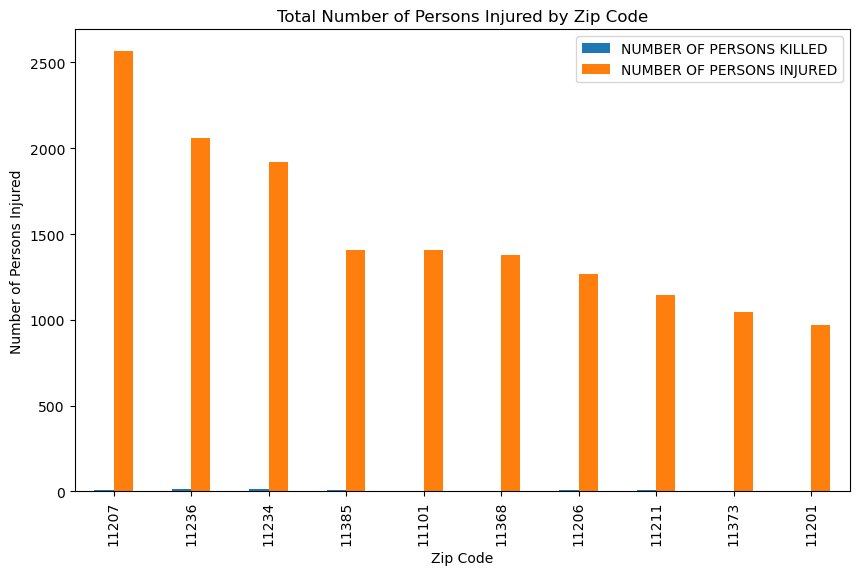

In [129]:
#Plot bar chart of persons killed vs injured
ax = injured_killed.plot(kind='bar', figsize=(10, 6))

# set the title and axis labels
ax.set_title('Total Number of Persons Injured by Zip Code')
ax.set_xlabel('Zip Code')
ax.set_ylabel('Number of Persons Injured')

plt.show();

#### Contributing Factor

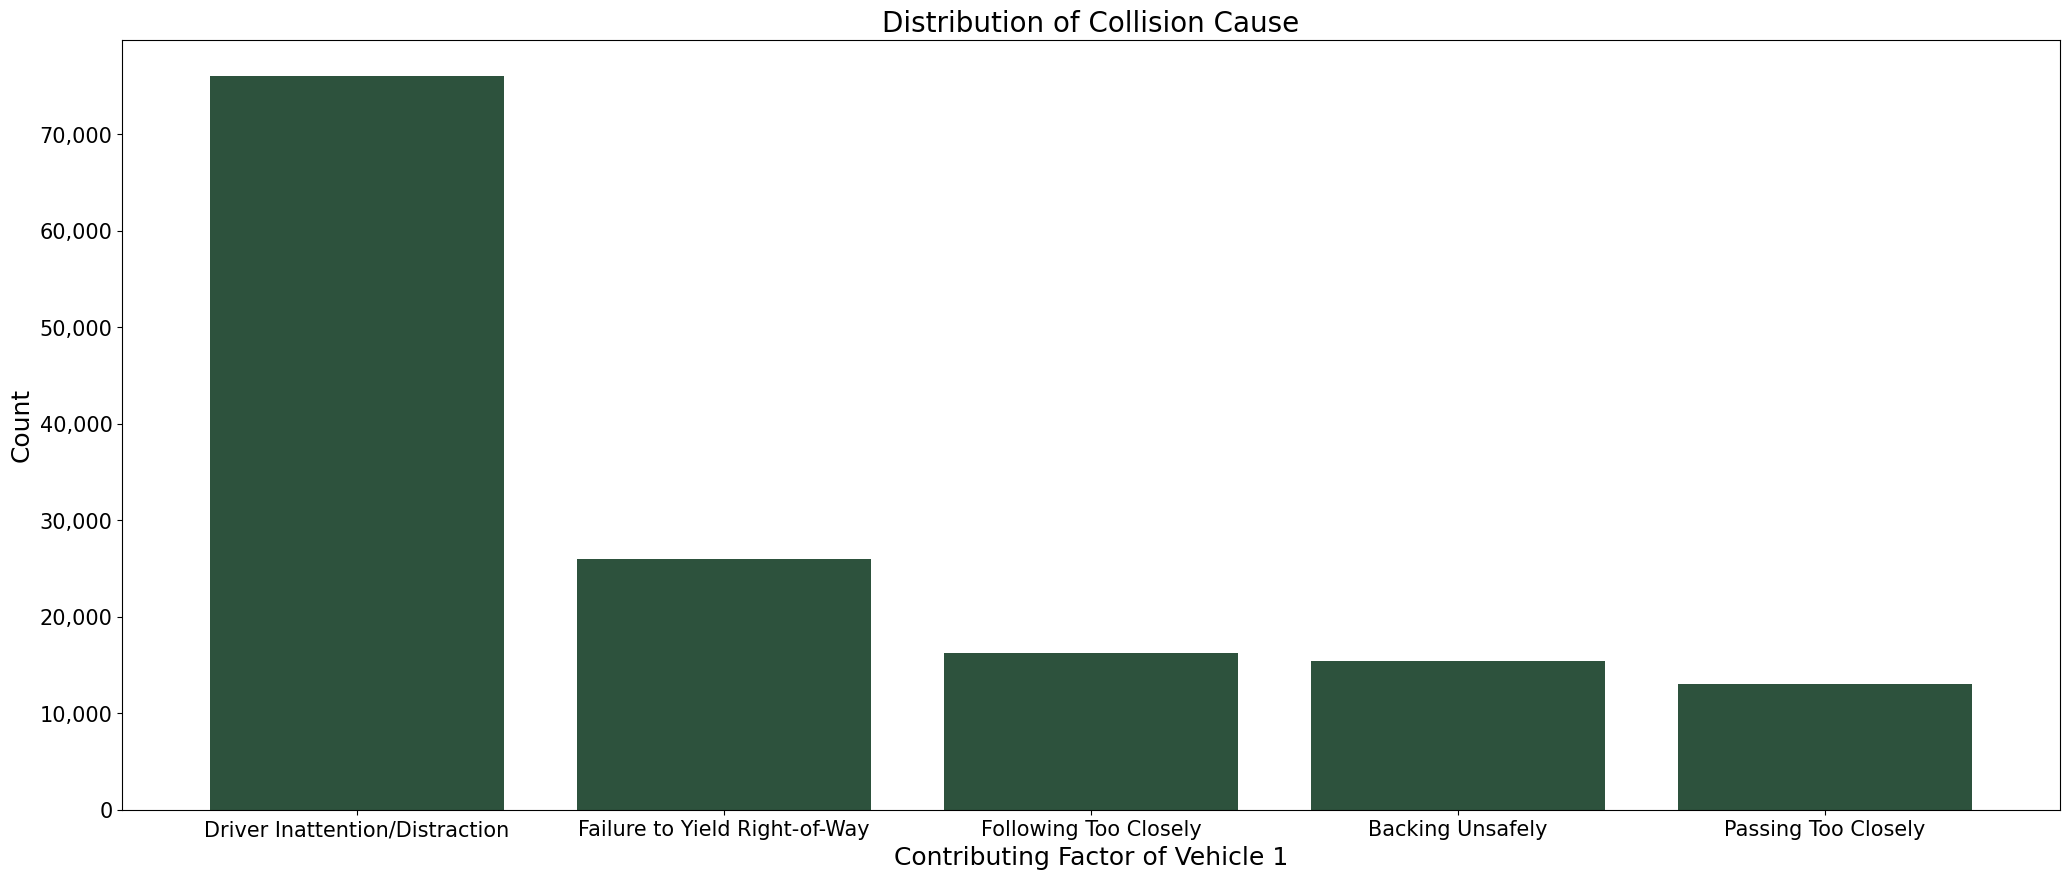

In [130]:
#Set up plot
fig, ax = plt.subplots(figsize=(25,10))

#Create variable for easier reuse
causes_counts = df_visuals['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()[:5]

#Plot bar chart 
ax.bar(causes_counts.index, causes_counts.values, color='#2d523d')

#Customize appearance
ax.set_xlabel('Contributing Factor of Vehicle 1', fontsize = 18);
ax.set_ylabel('Count', fontsize = 18)
ax.set_title('Distribution of Collision Cause', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

#Export plot
fig.savefig('images/DistributionOfCollisionCause', transparent=True)

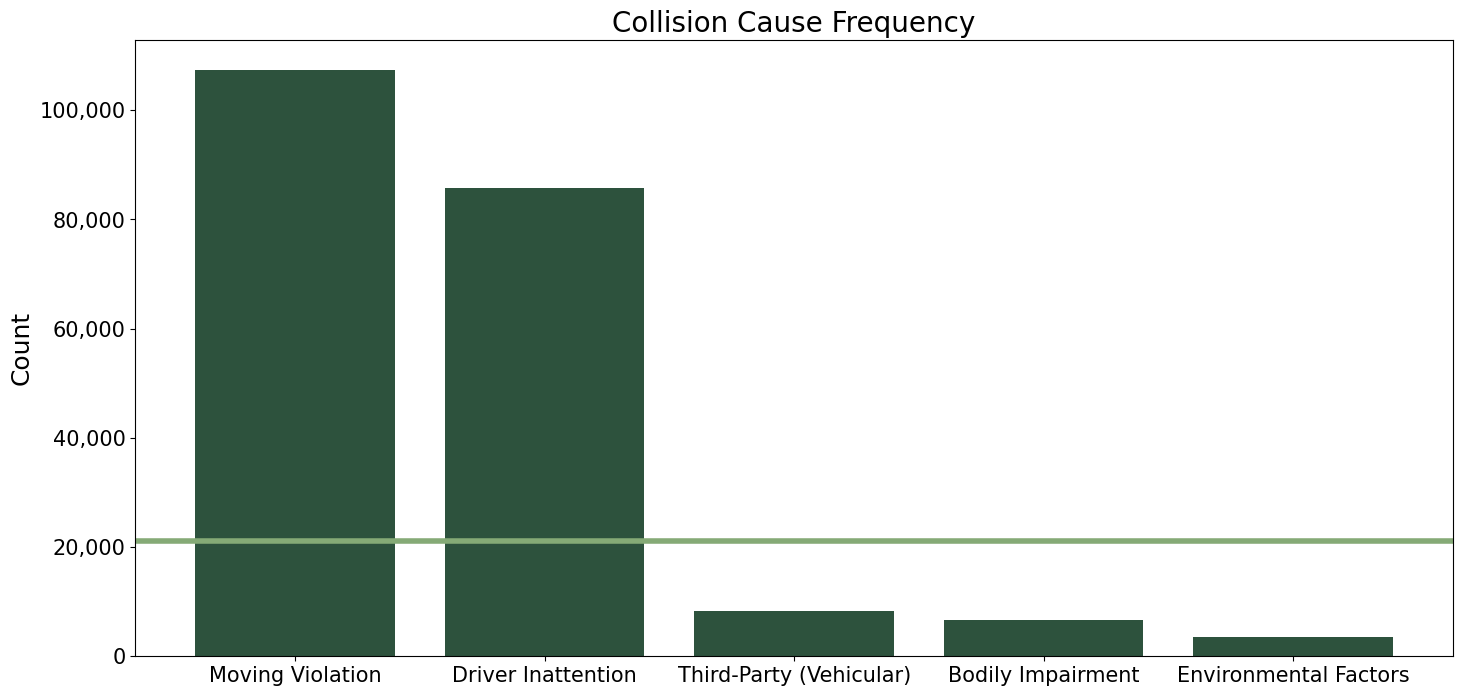

In [131]:
#Set up plot
fig, ax = plt.subplots(figsize=(17,8))

#Create variable for easier reuse
category_counts = df_visuals['CONTRIBUTING CATEGORY V1'].value_counts()[:5]

#Plot bar chart 
ax.bar(category_counts.index, category_counts.values, color='#2d523dff')

#Customize appearance
ax.set_ylabel('Count', fontsize = 18)
ax.set_title('Collision Cause Frequency', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

#Add mean line
ax.axhline(y=df['CONTRIBUTING CATEGORY V1'].value_counts().mean(), color='#85aa76ff', linewidth=4)

#Export plot
fig.savefig('images/CollisionCauseFrequency', transparent=True)

### Maps
Since we're using a dataset that contains geospatial information such as Latitude and Longitude, let's make some maps to better visualize where these crashes are occurring.

#### Heat Map using Folium
One method of making maps is through Folium. Folium is a Python library that was built on top of Leaflet library and create amazing interactive maps.  It can map individual markers or make heat maps utilizing the Longitude and Latitude data, and so much more. More information on Folium as well as installation instructions can be found [here](https://python-visualization.github.io/folium/).  

In [132]:
#Create dataframe with only relevant coliums to map making
df_collisions = df_visuals[['LATITUDE', 'LONGITUDE', 'COLLISION_ID']]
df_collisions

LATITUDE  LONGITUDE  COLLISION_ID
CRASH DATE TIME                                        
2018-01-01 00:00:00  40.682970 -73.828240       3819067
2018-01-01 00:00:00  40.653060 -73.882020       3820851
2018-01-01 00:00:00  40.624180 -73.970480       3822296
2018-01-01 00:00:00  40.628770 -73.918250       3820945
2018-01-01 00:00:00  40.623220 -73.961020       3821055
...                        ...        ...           ...
2023-03-27 20:44:00  40.670660 -73.957985       4616538
2023-03-27 21:50:00  40.709038 -73.898460       4616419
2023-03-27 22:10:00  40.640410 -73.969124       4616379
2023-03-27 23:07:00  40.640316 -73.979070       4616380
2023-03-27 23:46:00  40.713800 -73.933190       4616089

[220113 rows x 3 columns]

In [133]:
#Create a blank map
map = folium.Map(location=[df.LATITUDE.mean(), df.LONGITUDE.mean()], zoom_start=11, control_scale=True)

#List comprehension to make out list of lists
heat_data = [[row['LATITUDE'],row['LONGITUDE']] for index, row in df.iterrows()]

#Plot heat map
HeatMap(heat_data).add_to(map)

#Display map
map

#### Choropleth Map using GeoPandas
A choropleth map can be made using Folium, but GeoPandas can be used as well! GeoPandas is an open source project built on top of pandas that works with geospatial just like Folium. Although the end result is not as interactive as Folium maps, they're just as good in convey information.  More information on how to use GeoPandas can be found [here](http://darribas.org/gds15/content/labs/lab_03.html).

In [134]:
#Create dataframe counting number of accidents per zipcode
cause_count_by_zipcode = df_visuals.groupby('ZIP CODE').count()['COLLISION_ID']

#reset index
cause_count_by_zipcode = cause_count_by_zipcode.reset_index(name='COUNT')

cause_count_by_zipcode

ZIP CODE  COUNT
0       11001    109
1       11004    579
2       11005     18
3       11040     94
4       11101   5143
..        ...    ...
99      11692    532
100     11693    547
101     11694    667
102     11695      3
103     11697     47

[104 rows x 2 columns]

In [135]:
#Convert Zip Code column to integer type
zipcodes['ZIPCODE'] = zipcodes['ZIPCODE'].astype('int64')

#Merge with dataframes on the 'Zip code' column
accidentnum_zip = zipcodes.merge(cause_count_by_zipcode, left_on='ZIPCODE', right_on='ZIP CODE')
accidentnum_zip

ZIPCODE BLDGZIP       PO_NAME  POPULATION          AREA STATE  COUNTY  \
0      11436       0       Jamaica     18681.0  2.269930e+07    NY  Queens   
1      11213       0      Brooklyn     62426.0  2.963100e+07    NY   Kings   
2      11212       0      Brooklyn     83866.0  4.197210e+07    NY   Kings   
3      11225       0      Brooklyn     56527.0  2.369863e+07    NY   Kings   
4      11218       0      Brooklyn     72280.0  3.686880e+07    NY   Kings   
..       ...     ...           ...         ...           ...   ...     ...   
103    11211       0      Brooklyn     60861.0  4.047088e+07    NY   Kings   
104    11373       0      Elmhurst    101282.0  4.265486e+07    NY  Queens   
105    11361       0       Bayside     28496.0  5.016352e+07    NY  Queens   
106    11414       0  Howard Beach     26148.0  6.392882e+07    NY  Queens   
107    11249       0      Brooklyn     28481.0  1.777221e+07    NY   Kings   

    ST_FIPS CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0        36      081  http://www.usps.com/         0.0        0.0   
1        36      047  http://www.usps.com/         0.0        0.0   
2        36      047  http://www.usps.com/         0.0        0.0   
3        36      047  http://www.usps.com/         0.0        0.0   
4        36      047  http://www.usps.com/         0.0        0.0   
..      ...      ...                   ...         ...        ...   
103      36      047  http://www.usps.com/         0.0        0.0   
104      36      081  http://www.usps.com/         0.0        0.0   
105      36      081  http://www.usps.com/         0.0        0.0   
106      36      081  http://www.usps.com/         0.0        0.0   
107      36      047  http://www.usps.com/         0.0        0.0   

                                              geometry  ZIP CODE  COUNT  
0    POLYGON ((1038098.252 188138.380, 1038141.936 ...     11436    902  
1    POLYGON ((1001613.713 186926.440, 1002314.243 ...     11213   2947  
2    POLYGON ((1011174.276 183696.338, 1011373.584 ...     11212   3808  
3    POLYGON ((995908.365 183617.613, 996522.848 18...     11225   2343  
4    POLYGON ((991997.113 176307.496, 992042.798 17...     11218   1585  
..                                                 ...       ...    ...  
103  POLYGON ((1004708.889 202095.457, 1004867.276 ...     11211   4771  
104  POLYGON ((1015508.539 204353.966, 1015508.502 ...     11373   4058  
105  POLYGON ((1048944.167 222063.575, 1048950.337 ...     11361   1559  
106  POLYGON ((1025670.681 184011.380, 1025872.813 ...     11414   1529  
107  POLYGON ((995877.318 203206.075, 995968.511 20...     11249   2080  

[108 rows x 15 columns]

In [136]:
#Filter for collisions that occured within the top 10 zip codes to view polygon information
top10zips = [11207, 11234, 11101, 11385, 11236, 11211, 11206, 11368, 11201, 11208 ]

top10_choro = accidentnum_zip.loc[accidentnum_zip['ZIPCODE'].isin(top10zips)]
top10_choro

ZIPCODE BLDGZIP           PO_NAME  POPULATION          AREA STATE  \
25     11368       0            Corona    109069.0  7.248966e+07    NY   
28     11101       0  Long Island City     26254.0  7.896209e+07    NY   
37     11385       0         Ridgewood     98436.0  1.247863e+08    NY   
38     11206       0          Brooklyn     83575.0  4.070072e+07    NY   
42     11201       0          Brooklyn     53041.0  4.109489e+07    NY   
44     11208       0          Brooklyn     94410.0  7.930368e+07    NY   
45     11207       0          Brooklyn     93556.0  7.396626e+07    NY   
59     11236       0          Brooklyn     94480.0  9.637399e+07    NY   
61     11234       0          Brooklyn     85853.0  2.062010e+08    NY   
103    11211       0          Brooklyn     60861.0  4.047088e+07    NY   

     COUNTY ST_FIPS CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
25   Queens      36      081  http://www.usps.com/         0.0        0.0   
28   Queens      36      081  http://www.usps.com/         0.0        0.0   
37   Queens      36      081  http://www.usps.com/         0.0        0.0   
38    Kings      36      047  http://www.usps.com/         0.0        0.0   
42    Kings      36      047  http://www.usps.com/         0.0        0.0   
44    Kings      36      047  http://www.usps.com/         0.0        0.0   
45    Kings      36      047  http://www.usps.com/         0.0        0.0   
59    Kings      36      047  http://www.usps.com/         0.0        0.0   
61    Kings      36      047  http://www.usps.com/         0.0        0.0   
103   Kings      36      047  http://www.usps.com/         0.0        0.0   

                                              geometry  ZIP CODE  COUNT  
25   POLYGON ((1022299.623 218703.908, 1022285.600 ...     11368   4536  
28   POLYGON ((996450.660 210544.144, 996513.807 21...     11101   5143  
37   POLYGON ((1007499.885 199242.452, 1007573.769 ...     11385   4846  
38   POLYGON ((1002987.943 197218.048, 1003016.011 ...     11206   4717  
42   POLYGON ((990158.980 196291.403, 990132.710 19...     11201   4332  
44   POLYGON ((1021326.923 188270.016, 1021333.109 ...     11208   4383  
45   POLYGON ((1010961.260 190844.518, 1010984.556 ...     11207   6961  
59   POLYGON ((1012306.415 178457.610, 1012350.198 ...     11236   4804  
61   POLYGON ((1002458.956 170567.601, 1002500.000 ...     11234   5189  
103  POLYGON ((1004708.889 202095.457, 1004867.276 ...     11211   4771

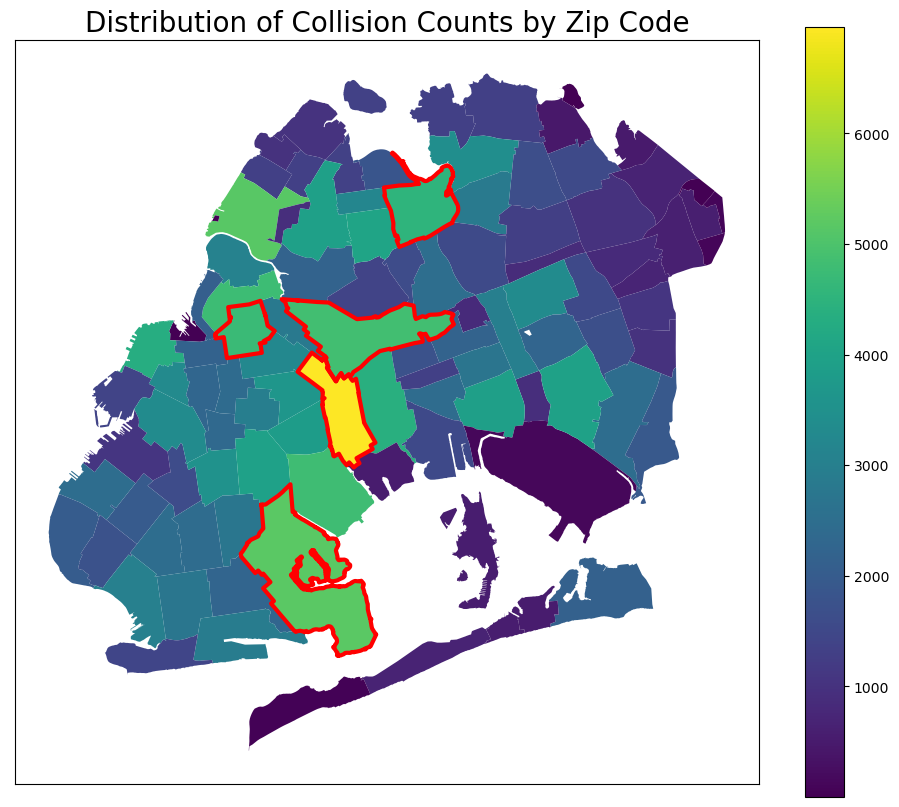

In [137]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw=dict(aspect='equal'))
accidentnum_zip.plot(column='COUNT', k=5, legend=True, ax=ax)
ax.set_title('Distribution of Collision Counts by Zip Code', fontsize = 20)

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Outline Brooklyn and Queens with a red line for top 5
bk_poly11234 = top10_choro.loc[61,'geometry']
bk_poly11207 = top10_choro.loc[45,'geometry']
bk_poly11236 = top10_choro.loc[38,'geometry']
qn_poly11385 = top10_choro.loc[37,'geometry']
qn_poly11368 = top10_choro.loc[25,'geometry']

ax.plot(bk_poly11207.exterior.xy[0], bk_poly11207.exterior.xy[1], color='red', linewidth=3)
ax.plot(bk_poly11234.exterior.xy[0], bk_poly11234.exterior.xy[1], color='red', linewidth=3)
ax.plot(bk_poly11236.exterior.xy[0], bk_poly11236.exterior.xy[1], color='red', linewidth=3)
ax.plot(qn_poly11385.exterior.xy[0], qn_poly11385.exterior.xy[1], color='red', linewidth=3)
ax.plot(qn_poly11368.exterior.xy[0], qn_poly11368.exterior.xy[1], color='red', linewidth=3)

#Zip Codes 6-10
#qn_poly11101 = num_injuryaccident_zip[num_injuryaccident_zip['COUNTY'] == 'Queens']['geometry'][28]#
#bk_poly11211 = num_injuryaccident_zip[num_injuryaccident_zip['COUNTY'] == 'Kings']['geometry'][103]#
#bk_poly11206 = num_injuryaccident_zip[num_injuryaccident_zip['COUNTY'] == 'Kings']['geometry'][38]#
#bk_poly11208 = num_injuryaccident_zip[num_injuryaccident_zip['COUNTY'] == 'Kings']['geometry'][44]#
#bk_poly11201 = num_injuryaccident_zip[num_injuryaccident_zip['COUNTY'] == 'Kings']['geometry'][42]#

#ax.plot(bk_poly11211.exterior.xy[0], bk_poly11211.exterior.xy[1], color='black', linewidth=3)
#ax.plot(bk_poly11206.exterior.xy[0], bk_poly11206.exterior.xy[1], color='black', linewidth=3)
#ax.plot(bk_poly11208.exterior.xy[0], bk_poly11208.exterior.xy[1], color='black', linewidth=3)
#ax.plot(bk_poly11201.exterior.xy[0], bk_poly11201.exterior.xy[1], color='black', linewidth=3)
#ax.plot(qn_poly11101.exterior.xy[0], qn_poly11101.exterior.xy[1], color='black', linewidth=3)

#Export plot
fig.savefig('images/Map_CollisionCountDistribution', transparent=True);

In [138]:
#Filter for collisions in Brooklyn and Queens borough
zipcodes_QuBr = zipcodes.loc[(zipcodes['COUNTY'] == 'Kings') | (zipcodes['COUNTY'] == 'Queens')]
zipcodes_QuBr

ZIPCODE BLDGZIP       PO_NAME  POPULATION          AREA STATE  COUNTY  \
0      11436       0       Jamaica     18681.0  2.269930e+07    NY  Queens   
1      11213       0      Brooklyn     62426.0  2.963100e+07    NY   Kings   
2      11212       0      Brooklyn     83866.0  4.197210e+07    NY   Kings   
3      11225       0      Brooklyn     56527.0  2.369863e+07    NY   Kings   
4      11218       0      Brooklyn     72280.0  3.686880e+07    NY   Kings   
..       ...     ...           ...         ...           ...   ...     ...   
254    11371       0      Flushing         0.0  3.055847e+07    NY  Queens   
255    11361       0       Bayside     28496.0  5.016352e+07    NY  Queens   
257    11414       0  Howard Beach     26148.0  6.392882e+07    NY  Queens   
259    11693       0  Far Rockaway     11052.0  3.497516e+06    NY   Kings   
260    11249       0      Brooklyn     28481.0  1.777221e+07    NY   Kings   

    ST_FIPS CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0        36      081  http://www.usps.com/         0.0        0.0   
1        36      047  http://www.usps.com/         0.0        0.0   
2        36      047  http://www.usps.com/         0.0        0.0   
3        36      047  http://www.usps.com/         0.0        0.0   
4        36      047  http://www.usps.com/         0.0        0.0   
..      ...      ...                   ...         ...        ...   
254      36      081  http://www.usps.com/         0.0        0.0   
255      36      081  http://www.usps.com/         0.0        0.0   
257      36      081  http://www.usps.com/         0.0        0.0   
259      36      047  http://www.usps.com/         0.0        0.0   
260      36      047  http://www.usps.com/         0.0        0.0   

                                              geometry  
0    POLYGON ((1038098.252 188138.380, 1038141.936 ...  
1    POLYGON ((1001613.713 186926.440, 1002314.243 ...  
2    POLYGON ((1011174.276 183696.338, 1011373.584 ...  
3    POLYGON ((995908.365 183617.613, 996522.848 18...  
4    POLYGON ((991997.113 176307.496, 992042.798 17...  
..                                                 ...  
254  POLYGON ((1016073.073 222913.148, 1016068.182 ...  
255  POLYGON ((1048944.167 222063.575, 1048950.337 ...  
257  POLYGON ((1025670.681 184011.380, 1025872.813 ...  
259  POLYGON ((1028453.995 167153.410, 1027813.010 ...  
260  POLYGON ((995877.318 203206.075, 995968.511 20...  

[111 rows x 13 columns]

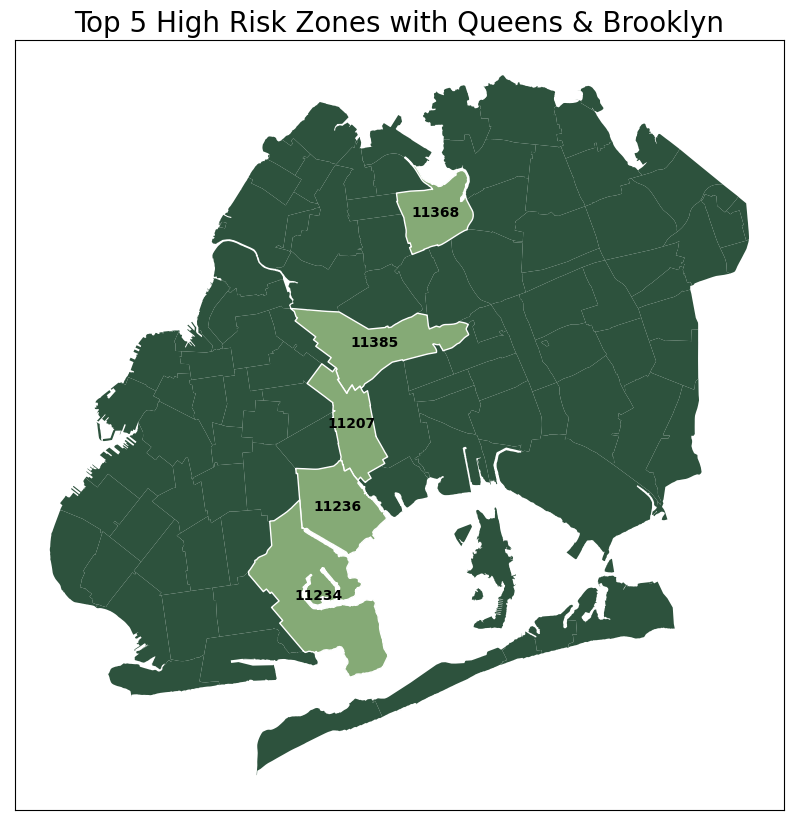

In [139]:
#Set up plot
fig, ax = plt.subplots(figsize=(12,10))

zipcodes_QuBr.plot(ax=ax, color='#2d523dff')

#Define the top 5 zip codes
top5zips = [11236, 11207, 11234, 11368, 11385]

# Highlight the top 5 zip codes with a different color
zipcodes_QuBr[zipcodes_QuBr['ZIPCODE'].isin(top5zips)].plot(ax=ax, alpha=1, facecolor='#85aa76ff', 
                                                            edgecolor='white', linewidth=1)

#Customize Appearance
ax.set_title('Top 5 High Risk Zones with Queens & Brooklyn', fontsize = 20)
ax.set_xticks([])
ax.set_yticks([])

# Add labels to the top 5 zip code polygons
for index, row in zipcodes_QuBr[zipcodes_QuBr['ZIPCODE'].isin(top5zips)].iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['ZIPCODE'], fontsize=10, 
             ha='center', va='center', color='black', weight='bold')
    
plt.show()

#Export plot
fig.savefig('images/Map_Top5HighRiskZones', transparent=True);

## Conclusion

### Recommendations
Our analysis has lead us to these three recommendations aimed to mitigate car collisions. Implementing these efforts in the top 5 high-risk zip codes could be the start of a safer future.
* **Increase safety campaign efforts.** Posting safety campaign flyers locally such as at bus stops or street corners could increase exposure as they have a significant amount of foot traffic. Other areas of interest include advertising boards by major roadways and highway electric VMS (Variable Message Signs).
* **Improve the public transit system.** Reallocation of funds towards public transportation could reduce the number of drivers on the road. More reliable and cleaner transportation methods such as the MTA bus and subways could drastically increase the amount of public transit users. 
* **Create additional safety training programs** Many people begin to learn about driving in their late teens because that's when they can take the driver's test to get their license. However, good habits are developed over time. Teaching students good driving habits at a younger age will allow them to develop better driving habits earlier on and could be more likely to bring them with them to adulthood as well as build a better foundation. These additional safety programs could be in collaboration with driving schools or the public education system. Providing additional monetary incentives such as the driver safety course that provudes a 10% reduction in a driver's base insurance rates, could also incentivize drivers to partake in the training program. 

### Future Insights & Next Steps
To improve the accuracy and comprehensiveness of this project in the future, additional information such as the following can be included in analysis:
* **Weather conditions** Weather conditions such as snow or fog affects drivers' visibility as well as driving capabilities and road conditions. 
* **Road conditions** Potholes are not a driver's best friend. Potholes, narrow roads, and even road construction can affect a driver's ability to navigate the road safely.
* **Driver information/demographics** This would allow for us to determine whether specific age group or gender are more or less likely to cause or be included in collisions. 